# akun

## [anonymous mode](https://docs.wandb.ai/guides/app/features/anon/)

In [ ]:
import wandb
# isi parameter anonymous="allow" agar log tersimpan di wandb mode anonymous
# dg mode anonymous maka log akan terhapus
wandb.init(anonymous="allow")

## api key
edc9dadd05adc26eaf20d31d146e02dc73b5b9f3

# dasar

## run (init)
run mrpkn bagian terkecil dari projek di wandb. misalnya ketika kita hyperparameter tuning maka setiap kombinasi hyperparameter dihitung 1 run dan run ini bersifat unik (run id). misalnya jika learning rate 0.1, 0.2, 0.3 maka akan ada 3 run dg id yang unik.
```python
import wandb

run = wandb.init()

# lengkap dengan parameter

run = wandb.init(
    entity="<project>",
    project="<project>",
    name="<run-name>",
    id="<run-id>"
)

# untuk mengakhiri run
run.finish()
```
run digunakan untuk
* Train a model
* Change a hyperparameter
* Use a different model
* Log data or a model as a W&B Artifact
* Download a W&B Artifact

state (keadaan) dalam run

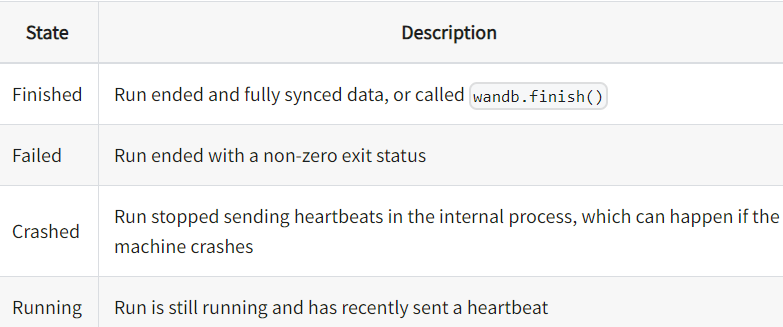

kumpulan job dari eksperimen bisa dikelompokkan kedalam 1 group dengan cara menambahkan parameter `group`

```python
wandb.init(group="experiment_1", job_type="eval")
```

grouping ini dapat digunakan untuk kasus
1. distributed training
2. multiple processes
3. k-fold cross-validation

In [ ]:
!pip install wandb -qqq

In [ ]:
# Set experiment index (for demo purposes)
experiment_index = 1

In [ ]:
# Simulate launching multiple different jobs that log to the same experiment

import wandb
import math
import random

for i in range(5):
  job_type = "rollout"
  if i == 2:
    job_type = "eval"
  if i == 3:
    job_type = "eval2"
  if i == 4:
    job_type = "optimizer"

  # Set group and job_type to see auto-grouping in the UI
  wandb.init(project="group-demo",
             group="exp_" + str(experiment_index),
             job_type=job_type)

  for j in range(100):
    acc = 0.1 * (math.log(1 + j + .1) + random.random())
    val_acc = 0.1 * (math.log(1+ j + 2) + random.random() + random.random())
    if (j % 10 == 0):
      wandb.log({"acc":acc, "val_acc":val_acc})

  # Using this to mark a run complete in a notebook context
  wandb.finish()

# I'm incrementing this so you can re-run this cell and get another experiment
# grouped in the W&B UI
experiment_index += 1

resume run

jika run mengalami crash kita bisa melanjutkan run.

untuk resume/melanjutkan run maka pada parameter `id` isi dengan `id` run yang ingin di resume, kemudian isi parameter `resume`.

```python
run = wandb.init(entity="<entity>", \
        project="<project>", id="<run ID>", resume="<resume>")
```

parameter `resume` bisa diisi `"auto"` artinya wandb bisa me-restart run. adapun pilihan lainnya

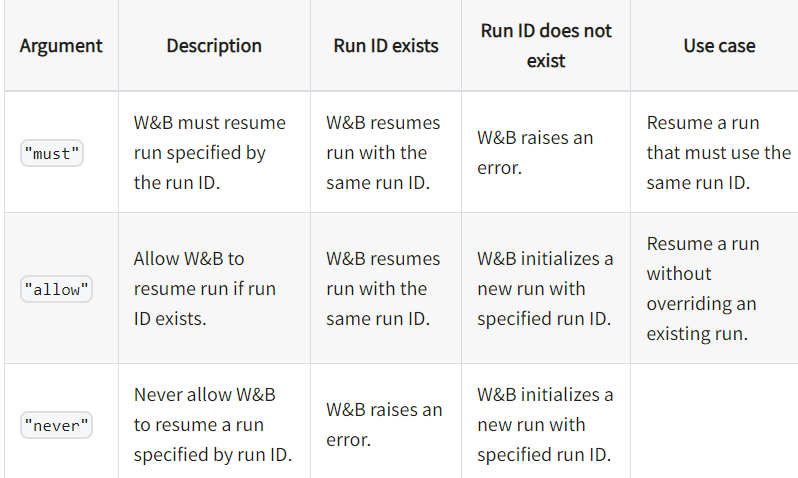

jika kita melakukan hyperparameter tuning dg sweep, dan ternyata mengalami gangguan sehingga sweep mengalami interrupt maka kita bisa menjalankan ulang bagian hyperparameter tuning yang terputus/interrupt

Gunakan fungsi mark_preempting untuk memungkinkan W&B secara otomatis meminta ulang run sweep yang terputus. Misalnya, cuplikan kode berikut ini

```python
run = wandb.init()  # Initialize a run
run.mark_preempting()
```


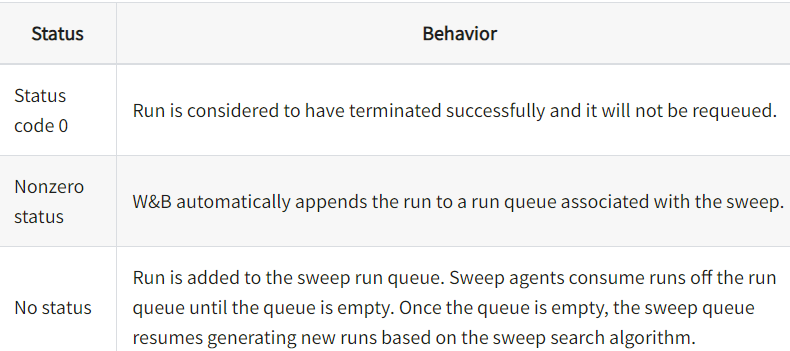

rewind run

Rewind run untuk mengoreksi atau memodifikasi riwayat run tanpa kehilangan data asli. Selain itu, ketika Anda me-rewind sebuah run, Anda dapat log data baru dari titik waktu tersebut. Summary metrics untuk run yang Anda rewind dihitung ulang berdasarkan riwayat yang baru tercatat. Ini berarti perilaku berikut ini

* History truncation: The history is truncated to the rewind point, allowing new data logging.
* Summary metrics: Recomputed based on the newly logged history.
* Configuration preservation: Original configurations are preserved and can be merged with new configurations.

When you rewind a run, W&B resets the state of the run to the specified step, preserving the original data and maintaining a consistent run ID. This means that:

* Run archiving: Original runs are archived and accessible from the Run Overview tab.
* Artifact association: Artifacts are associated with the run that produced them.
* Immutable run IDs: Introduced for consistent forking from a precise state.
* Copy immutable run ID: A button to copy the immutable run ID for improved run management.

gunakan `resume_from` untuk me-rewind suatu history run ke step yang diinginkan. ini bisa berupa nama dari run dan step yang ingin di rewind

In [ ]:
import wandb
import math

# Initialize the first run and log some metrics
# Replace with your_project_name and your_entity_name!
run1 = wandb.init(project="your_project_name", entity="your_entity_name")
for i in range(300):
    run1.log({"metric": i})
run1.finish()

# Rewind from the first run at a specific step and log the metric starting from step 200
run2 = wandb.init(project="your_project_name", entity="your_entity_name", resume_from=f"{run1.id}?_step=200")

# Continue logging in the new run
# For the first few steps, log the metric as is from run1
# After step 250, start logging the spikey pattern
for i in range(200, 300):
    if i < 250:
        run2.log({"metric": i, "step": i})  # Continue logging from run1 without spikes
    else:
        # Introduce the spikey behavior starting from step 250
        subtle_spike = i + (2 * math.sin(i / 3.0))  # Apply a subtle spikey pattern
        run2.log({"metric": subtle_spike, "step": i})
    # Additionally log the new metric at all steps
    run2.log({"additional_metric": i * 1.1, "step": i})
run2.finish()

selain itu kita bisa melakukan fork pada run yang ingin kita rewind

In [ ]:
import wandb

# Fork the run from a specific step
forked_run = wandb.init(
    project="your_project_name",
    entity="your_entity_name",
    fork_from=f"{rewind_run.id}?_step=500",
)

# Continue logging in the new run
for i in range(500, 1000):
    forked_run.log({"metric": i*3})
forked_run.finish()

### run alert
kita bisa mengirimkan notif alert ke email/slack jika run mengalami crash atau kita menerapkan trigger

contoh jika gradient saat training loop mulai mengalami blow up (NaN) atau step dalam ML pipeline nya complete maka akan dikirim notif alert

cara mengaktifkan notif adalah
1. turn on alert di [User setting](https://wandb.ai/settings)
2. tambahkan kode `run.alert()`

```python
import wandb

run = wandb.init()
run.alert(title="High Loss", text="Loss is increasing rapidly")

# contoh lainnya, ketika akurasi kurang dari threshold
# maka kirim notif alert berupa WARN (warning)
# notif alert dikirim setiap 5 menit sekali
import wandb
from wandb import AlertLevel

run = wandb.init()

if acc < threshold:
    run.alert(
        title="Low accuracy",
        text=f"Accuracy {acc} is below the acceptable threshold {threshold}",
        level=AlertLevel.WARN,
        wait_duration=300,
    )

# jika notif dikirim ke slack yang diikuti oleh user id slack,
# misalnya user id perusahaan/kita sendiri maka tambahkan @user_id
run.alert(title="Loss is NaN", text=f"Hey <@U1234ABCD> loss has gone to NaN")
```


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

In [ ]:
# contoh kirim notif alert versi lengkap
import random
from wandb import AlertLevel

# Initialize a new run in Weights & Biases
wandb.init(project="test_alerts",
                 config={
                     "threshold": 0.3, # The minimum acceptable accuracy
                     "max_steps": 1000, # The max number of steps for this run
                 })
config = wandb.config

# Simulating a model training loop
for training_step in range(config.max_steps):

  # Generate a random number for accuracy
  accuracy = round(random.random() + random.random(), 3)
  wandb.log({"Accuracy": accuracy})

  # If the accuracy is below the threshold, fire an alert and stop the run
  if accuracy <= config.threshold:
    wandb.alert(
      title='Low Accuracy',
      text=f'Accuracy {accuracy} at step {training_step} is below the acceptable theshold',
      level=AlertLevel.WARN,
      wait_duration=5
    )
    print(f"Script stopped as accuracy is below threshold, {accuracy} vs {config.threshold}")
    break

# Mark the run as finished (useful in Jupyter notebooks)
wandb.finish()

mengirim run ke team

Dalam skrip Anda, atur entity ke tim Anda. “ Entity” artinya username atau nama tim Anda. Buat dulu entity (personal account atau team account) di aplikasi web sebelum mengirim ke sana.

```python
wandb.init(entity="example-team")
```

default entity akan diupdate ketika kita join ke team. artinya dibagian [settings page](https://app.wandb.ai/settings) kita akan melihat projek bersama team. contoh seperti gambar dibawah ini

<img src="https://docs.wandb.ai/assets/images/send_new_runs_to_team-e40e0a7c5ccae7d265709be6958297b0.png">

## hal hal disaran wandb

In [ ]:
#  keep the total number of distinct metrics in a project under 10,000
# dalam projek diharapkan jumlah metrics unik tetap dibawah 10.000
# karena terlalu banyak log data menyebabkan app wandb slow
# jika workspace mendadak slow down maka hapus run yang memiliki terlalu banyak
# plot
import wandb

wandb.log(
    {
        "a": 1,  # "a" is a distinct metric
        "b": {
            "c": "hello",  # "b.c" is a distinct metric
            "d": [1, 2, 3],  # "b.d" is a distinct metric
        },
    }
)

In [ ]:
# selalu jaga agar satu log dibawah 1MB dan total 1 wandb.init() dibawah 25 MB.
# tapi hal ini tidak berlaku untuk wandb.Media seperti wandb.Image, wandb.Audio, dll
# ❌ not recommended
wandb.log({"wide_key": range(10000000)})

# ❌ not recommended
with f as open("large_file.json", "r"):
    large_data = json.load(f)
    wandb.log(large_data)

In [ ]:
# Sebagai pedoman umum, semakin luas metriknya, semakin jarang Anda harus mencatatnya.
# Artinya kita tidak perlu menyimpan semua metrics
# * Scalars: <100,000 logged points per metric
# * Media: <50,000 logged points per metric
# * Histograms: <10,000 logged points per metric
# Training loop with 1m total steps
for step in range(1000000):
    # ❌ not recommended
    wandb.log(
        {
            "scalar": step,  # 100,000 scalars
            "media": wandb.Image(...),  # 100,000 images
            "histogram": wandb.Histogram(...),  # 100,000 histograms
        }
    )

    # ✅ recommended
    if step % 1000 == 0:
        wandb.log(
            {
                "histogram": wandb.Histogram(...),  # 10,000 histograms
            },
            commit=False,
        )
    if step % 200 == 0:
        wandb.log(
            {
                "media": wandb.Image(...),  # 50,000 images
            },
            commit=False,
        )
    if step % 100 == 0:
        wandb.log(
            {
                "scalar": step,  # 100,000 scalars
            },
            commit=True,
        )  # Commit batched, per-step metrics together

In [ ]:
# ukuran config diusahakan kurang dari 10 MB karena dapat menyebabkan slow down
# ✅ recommended
wandb.init(
    config={
        "lr": 0.1,
        "batch_size": 32,
        "epochs": 4,
    }
)

# ❌ not recommended
wandb.init(
    config={
        "steps": range(10000000),
    }
)

# ❌ not recommended
with f as open("large_config.json", "r"):
    large_config = json.load(f)
    wandb.init(config=large_config)

Untuk waktu loading yang lebih cepat, usahakan agar jumlah total run dalam satu project di bawah 10.000. Jumlah run yang besar dapat memperlambat project workspaces dan run table operations, terutama ketika grouping diaktifkan atau run memiliki metrik yang berbeda (metrik yang unik) jumlahnya besar.

Jika Anda menemukan bahwa Anda atau tim Anda sering mengakses set run yang sama (misalnya, run terbaru), pertimbangkan untuk memindahkan run lainnya secara massal ke project baru yang digunakan sebagai arsip, sehingga menyisakan set run yang lebih kecil di project yang sedang dikerjakan.

<img src="https://docs.wandb.ai/assets/images/demo_move_runs-75900aa073a8169e55305c2aeec94c77.gif">

Memiliki ratusan section dalam workspace dapat menurunkan performa. Pertimbangkan untuk membuat section berdasarkan pengelompokan metrik tingkat tinggi dan hindari pola satu section untuk setiap metrik.

Jika Anda merasa memiliki terlalu banyak section dan kinerjanya lambat, pertimbangkan untuk mengatur workingspace untuk membuat section berdasarkan prefix daripada suffix, yang dapat menghasilkan lebih sedikit section dan kinerja yang lebih baik.

<img src="https://docs.wandb.ai/assets/images/section_prefix_toggle-5318afaab5b3164b1e97a69b5e1f3157.gif">

usahakan agar file yang diupload ke 1 run dibawah 1,000. jika besar maka gunakan artifact. 1,000 file dalam 1 run menyebabkan penurunan kinerja pada run page di web wandb

### kinerja code python

Ada beberapa cara untuk mengurangi kinerja kode python Anda:
1. ukuran data yang terlalu besar. Ukuran data yang besar dapat menimbulkan overhead > 1 ms pada training loop
2. kecepatan jaringan internet dan konfigurasi backend wandb
3. memanggil `wandb.log` lebih dari beberapa kali per detik. Hal ini disebabkan oleh latensi yang kecil yang ditambahkan ke training loop setiap kali `wandb.log` dipanggil

jika log mempengaruhi kinerja training dimana proses training menjadi lebih lambat maka [berikut cara mengatasinya](http://wandb.me/log-hf-colab) dg mengubah strategi log


W&B tidak memberikan limit apa pun di luar rate limiting. W&B Python SDK secara otomatis akan menyelesaikan permintaan "backoff" dan "retry" secara eksponensial yang melebihi limit. W&B Python SDK merespons dengan “ Network failure” pada command line. Untuk akun yang tidak berbayar, W&B dapat menjangkau dalam kasus-kasus ekstrem di mana penggunaan melebihi threshold yang wajar.

## [registry](https://docs.wandb.ai/guides/registry/)
ibaratnya repository sehingga kita dapat menyimpan dan melakukan versioning, alias, lineage tracking, dan governance model dan dataset. Registry memungkinkan individu dan tim di seluruh organisasi untuk berbagi dan secara kolaboratif mengelola lifecycle semua model, dataset, dan artefak lainnya. Sebagai single source of truth untuk model mana yang sedang diproduksi, Registry menyediakan fondasi untuk pipeline CI/CD yang efektif dengan mengidentifikasi model yang tepat untuk direproduksi, retrain, evaluate, dan deploy.

<img src="https://docs.wandb.ai/assets/images/registry_landing_page-4b4fcaef47cd39938af7300c02a71bf8.png">

Cara kerjanya
1. Log versi artefak: Dalam training atau experiment script Anda, tambahkan beberapa baris kode untuk menyimpan artefak ke dalam W&B run.
2. Link ke registry: Bookmark versi artefak yang paling relevan dan paling berharga dengan membuat link ke registry.

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# how to log and link a model to the model registry inside W&B Registry
import wandb
import random

# Start a new W&B run to track your experiment
run = wandb.init(project="registry_quickstart")

# Simulate logging model metrics
run.log({"acc": random.random()})

# Create a simulated model file
with open("my_model.txt", "w") as f:
   f.write("Model: " + str(random.random()))

# log and link the model to the model registry inside W&B Registry
logged_artifact = run.log_artifact(artifact_or_path="./my_model.txt", name="gemma-finetuned-3twsov9e", type="model")
run.link_artifact(artifact=logged_artifact, target_path=f"<INSERT-ORG-NAME>/wandb-registry-model/registry-quickstart-collection"),

run.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


wandb: ERROR LinkArtifact: registry-quickstart-collection, error: returned error 404 Not Found: {"errors":[{"message":"entity \u003cINSERT-ORG-NAME\u003e not found","path":["linkArtifact"]}],"data":{"linkArtifact":null}}


acc,▁
acc,0.52364


kondisi pada registry yang mungkin terjadi

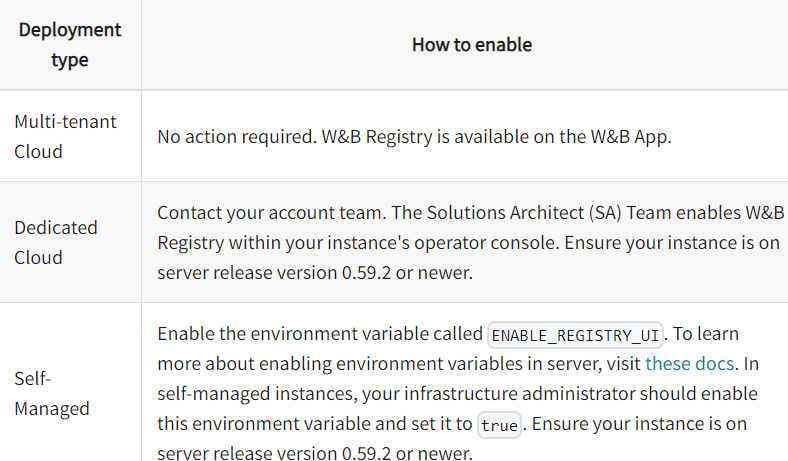

[tutorial video](https://www.youtube.com/watch?v=p4XkVOsjIeM)

### [tipe registry](https://docs.wandb.ai/guides/registry/registry_types)
terdapat 2 tipe registry yaitu core dan custom

1. core

terbagi 2 jenis yaitu `model` (defaultnya) dan `dataset`

<img src="https://docs.wandb.ai/assets/images/core_registry_example-c9d2dd43a171e9817f4d41e3308b40e5.png">

2. custom

kita bisa buat registry sendiri. contohnya **Fine_Tuned_Models** untuk model fine-tuning, **Benchmark_Datasets** untuk mengatur dataset yang telah diseleksi untuk mengevaluasi kinerja model yang telah dilatih. Di dalam registry ini, Anda mungkin memiliki collection yang disebut “User_Query_Insurance_Answer_Test_Data” yang berisi set pertanyaan dari user dan jawaban yang telah divalidasi oleh ahli yang belum pernah dilihat oleh model selama pelatihan.

<img src="https://docs.wandb.ai/assets/images/custom_registry_example-40523c2388297e578a286cb11e3a0ed9.png">


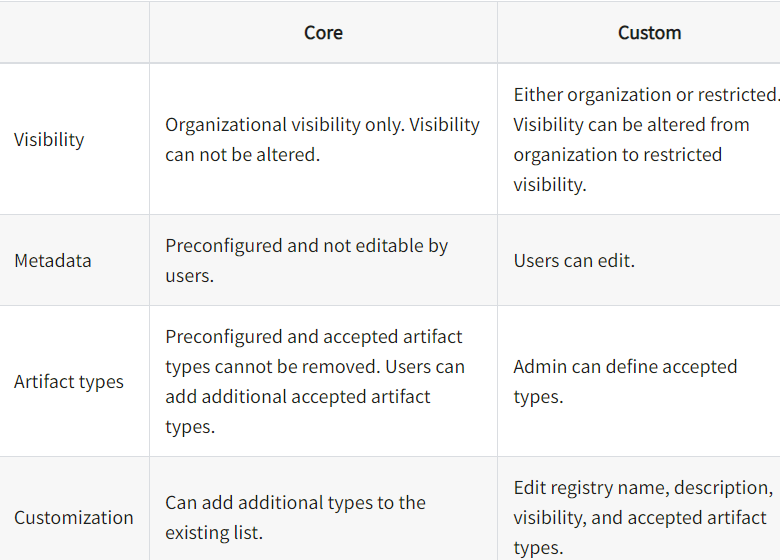

membuat custom registry

<img src="https://docs.wandb.ai/assets/images/create_registry-932fa48c51a74578fc19fa9b58d75c18.gif">

role permission untuk registry, [lihat dibagian tabel](https://docs.wandb.ai/guides/registry/configure_registry)

create collection

Membuat collection di dalam registry untuk mengelola artefak Anda. Collection adalah sekumpulan versi artefak yang ditautkan di dalam registry. Setiap collection merepresentasikan distinct task atau use case dan berfungsi sebagai container untuk memilih versi artefak yang terkait dengan task atau use case tersebut.

ketika membuat collection kita tentukan tipe atifact nya agar dpt link(ditautkan) ke collection. aturannya 1 collection untuk 1 tipe artifact

tipe artifact tidak dapat di mix misalnya artifact model tdk dpt di link ke dataset registry

```python
import wandb

# Initialize a run
run = wandb.init(entity="<team_entity>", project="<project>")

# Create an artifact object
artifact = wandb.Artifact(
    name="<artifact_name>",
    type="<artifact_type>"
    )
```

melihat tipe artifact

```python
import wandb

registry_name = "<registryName>"
org_entity = "<org_entity>"
artifact_types = wandb.Api().project(name=f"wandb-registry-{registry_name}", entity=org_entity).artifact_types()
print(artifact_type.name for artifact_type in artifact_types)
```
buat colleciton

```python
import wandb

# Initialize a run
run = wandb.init(entity="<team_entity>", project="<project>")

# Create an artifact object
artifact = wandb.Artifact(name="<artifact_name>", type="<artifact_type>")

org_entity = "<organization_entity>"
registry_name = "<registry_name>"
collection_name = "<collection_name>"
target_path = f"{org_entity}/wandb-registry-{registry_name}/{collection_name}"

# Link the artifact to a collection
run.link_artifact(artifact = artifact, target_path = target_path)

run.finish()
```

buat collection lewat web

<img src="https://docs.wandb.ai/assets/images/create_collection-399b311a76a9c06114bc84302c1e591c.gif">

Link an artifact version to a registry

menautkan (link) versi artifact ke registry (lebih tepatnya collection) maka gunakan `link_artifact`. sblmnya harap pastikan collection yang akan terhubug registry sdh ada (collection dan registrynya sdh ada)

gunakan parameter `target_path` untuk collection dan registry yang dipilih akan ditautkan (link) ke versi artifact. isinya `{ORG_ENTITY_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}`

In [ ]:
# berikut contoh link an artifact version to a collection within an existing registry
import wandb

TEAM_ENTITY_NAME = "<team_entity_name>"
ORG_ENTITY_NAME = "<org_entity_name>"

REGISTRY_NAME = "<registry_name>"
COLLECTION_NAME = "<collection_name>"

run = wandb.init(
        entity=TEAM_ENTITY_NAME, project="<project_name>")

artifact = wandb.Artifact(name="<artifact_name>", type="<collection_type>")
artifact.add_file(local_path="<local_path_to_artifact>")

target_path=f"{ORG_ENTITY_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
run.link_artifact(artifact = artifact, target_path = target_path)

jika ingin link (menautkan) versi artifact ke registry model atau dataset maka ubah tipe artifactnya menjadi `model` atau `dataset` pada parameter `type` di `wandb.Artifact()`

In [ ]:
# contoh artifact model "my_model.txt" dimasukkan kedalam collection bernama "Example ML Task" dalam
# registry model
import wandb

TEAM_ENTITY_NAME = "<team_entity_name>"
ORG_ENTITY_NAME = "<org_entity_name>"

REGISTRY_NAME = "model"
COLLECTION_NAME = "Example ML Task"

COLLECTION_TYPE = "model"


with wandb.init(entity=TEAM_ENTITY_NAME, project="link_quickstart") as run:
  # BUAT FILE ARTIFACT MODEL
  with open("my_model.txt", "w") as f:
    f.write("simulated model file")

  # MASUKKAN KEDALAM ARTIFACT
  logged_artifact = run.log_artifact("./my_model.txt", "artifact-name", type=COLLECTION_TYPE)
  # TAUTKAN (BUAT REGISTRY (BERUPA LINK) AGAR DAPAT DIAKSES) ARTIFACT MODEL
  run.link_artifact(
    artifact=logged_artifact,
    target_path=f"{ORG_ENTITY_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
  )

In [ ]:
# prompt: jelaskan dan apa fungsi dari log_artifact(), link_artifact(), dan parameter target_path pada wandb. buatkan juga contoh implementasi kode pythonnya

import wandb

# Fungsi log_artifact()
# Fungsi ini digunakan untuk melacak dan menyimpan artefak (file atau direktori) dalam sebuah run W&B.
# Artefak dapat berupa model, dataset, atau file konfigurasi yang ingin Anda pantau dan kelola dalam eksperimen Anda.

# Contoh implementasi log_artifact()
with wandb.init(project="my-project", entity="my-entity") as run:
    artifact = wandb.Artifact('my_dataset', type='dataset')
    artifact.add_file('my_data.csv')
    run.log_artifact(artifact)


# Fungsi link_artifact()
# Fungsi ini memungkinkan Anda untuk menautkan (link) artefak yang telah Anda log ke suatu registry atau koleksi dalam W&B.
# Registry dan koleksi adalah cara untuk mengatur dan berbagi artefak Anda secara terstruktur, memungkinkan Anda untuk mengelola versi dan mengakses artefak dengan mudah.

# Contoh implementasi link_artifact()
with wandb.init(project="my-project", entity="my-entity") as run:
    artifact = wandb.Artifact('my_model', type='model')
    artifact.add_file('my_model.h5')
    run.log_artifact(artifact)

    # Link artifact ke collection "my-collection" di registry "model"
    run.link_artifact(artifact, target_path="my-entity/wandb-registry-model/my-collection")


# Parameter target_path
# Parameter ini menentukan path atau lokasi di mana artefak akan ditautkan (link) dalam registry W&B.
# Path ini harus berupa string yang berisi informasi organisasi/entitas, nama registry, dan nama koleksi.
# Formatnya adalah: "{entity}/wandb-registry-{registry_name}/{collection_name}"

# Contoh target_path:
# "my-entity/wandb-registry-model/my-collection"
# - entity: my-entity
# - registry_name: model
# - collection_name: my-collection

# Dengan menggunakan target_path, Anda dapat mengontrol lokasi penyimpanan artefak di registry dan dengan mudah mengaksesnya nanti.


untuk menggunakan artifact yang ada di wandb gunakan `use_artifact()` dan jika ingin mendownloadnya artifact di wandb menjadi local gunakan `.download()`

```python
import wandb

ORG_ENTITY_NAME = '<org-entity-name>'
REGISTRY_NAME = '<registry-name>'
COLLECTION_NAME = '<collection-name>'
ALIAS = '<artifact-alias>'
INDEX = '<artifact-index>'

run = wandb.init()  # Optionally use the entity, project arguments to specify where the run should be created

registered_artifact_name = f"{ORG_ENTITY_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:{ALIAS}"
registered_artifact = run.use_artifact(artifact_or_name=name)  # marks this artifact as an input to your run
artifact_dir = registered_artifact.download()  
```
untuk versi registry artifact bisa menggunakan index atau alias. bisa juga latest untuk versi terbaru, kemudian index v1 untuk versi 1  
```python
# Artifact name with version index specified
f"{ORG_ENTITY}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{INDEX}"

# Artifact name with alias specified
f"{ORG_ENTITY}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:{ALIAS}"
```
cara mencari registry lewat web
<img src="https://docs.wandb.ai/assets/images/find_usage_in_registry_ui-f934a71147f5b0c5f9d4a77c005d018f.gif">

In [ ]:
# prompt: jelaskan dan fungsi dari use_artifact(), dan .downloda() pada wandb

# Fungsi use_artifact()
# Fungsi ini digunakan untuk mengakses dan menggunakan artefak yang telah tersimpan di registry W&B.
# Anda dapat mengakses artefak berdasarkan nama, tipe, versi, atau path-nya.

# Contoh implementasi use_artifact()
with wandb.init(project="my-project", entity="my-entity") as run:
    artifact = run.use_artifact('my-entity/wandb-registry-model/my-collection:latest')
    artifact_dir = artifact.download()

# Parameter artifact
# Parameter ini menentukan artefak yang akan diakses.
# Anda dapat mendefinisikannya menggunakan string yang merepresentasikan nama, tipe, versi, atau path artefak di registry.
# Contohnya: 'my-entity/wandb-registry-model/my-collection:latest'

# .download()
# Metode ini digunakan untuk mengunduh artefak ke direktori lokal.
# Setelah Anda mengakses artefak menggunakan use_artifact(), Anda dapat menggunakan metode download() untuk mendapatkan file atau direktori yang terkait dengan artefak tersebut.

# Contoh penggunaan download()
artifact_dir = artifact.download()
# Setelah mengunduh, isi dari artefak akan tersedia di direktori artifact_dir


#Penjelasan lebih detail:
# use_artifact() digunakan untuk menghubungkan artefak dari registry ke run yang sedang berjalan. Dengan menggunakan fungsi ini, Anda dapat mengakses metadata, file, dan informasi lain yang terkait dengan artefak tersebut.

# .download() mengunduh artefak yang telah digunakan ke direktori lokal. Direktori ini akan berisi semua file dan folder yang termasuk dalam artefak. Dengan demikian, Anda dapat menggunakan file-file tersebut untuk berbagai tujuan, misalnya untuk memuat model yang sudah dilatih, menggunakan dataset, atau mengakses file konfigurasi yang terkait dengan artefak.


#Contoh penggunaan use_artifact() dan .download()
# Misalkan Anda memiliki model yang telah dilatih dan disimpan di registry W&B.
# Anda ingin menggunakan model tersebut di dalam skrip Anda.

with wandb.init(project="my-project", entity="my-entity") as run:
    artifact = run.use_artifact('my-entity/wandb-registry-model/my-collection:v0') #mengakses artefak dengan versi v0
    artifact_dir = artifact.download() #mendownload ke direktori lokal
    #mulai melakukan sesuatu dengan model
    model_path = os.path.join(artifact_dir, 'my_model.h5') #mengambil path model
    model = load_model(model_path) #memuat model menggunakan path yang didapat




menambahkan tag (sblmnya tdk ada) pada registry artifact

1. lewat web

<img src="https://docs.wandb.ai/assets/images/add_tag_collection-27dfc43ce547274744f5f2bdf4973ca9.gif">

2. lewat python

```python
import wandb

COLLECTION_TYPE = "<collection_type>"
ORG_NAME = "<org_name>"
REGISTRY_NAME = "<registry_name>"
COLLECTION_NAME = "<collection_name>"

full_name = f"{ORG_NAME}/wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"

collection = wandb.Api().artifact_collection(
    type_name = COLLECTION_TYPE,
    name = full_name
    )

collection.tags = ["your-tag"]
collection.save()
```

update tag

```python
collection.tags = [*collection.tags, "new-tag", "other-tag"]
collection.tags = collection.tags + ["new-tag", "other-tag"]

collection.tags = set(collection.tags) - set(tags_to_delete)
collection.tags = []  # deletes all tags
```

update tag pada versi artifact yg ditentukan

```python
collection.tags += ["new-tag", "other-tag"]
collection.tags.append("new-tag")

collection.tags.extend(["new-tag", "other-tag"])
collection.tags[:] = ["new-tag", "other-tag"]
collection.tags.remove("existing-tag")
collection.tags.pop()
collection.tags.clear()
```

### model registry

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      S

In [ ]:
import wandb
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from wandb.integration.keras import WandbMetricsLogger
from sklearn.model_selection import train_test_split

In [ ]:
wandb.login() # edc9dadd05adc26eaf20d31d146e02dc73b5b9f3

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# !wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
entity = "entity"

In [ ]:
def generate_raw_data(train_size=6000):
    eval_size = int(train_size / 6)
    (x_train, y_train), (x_eval, y_eval) = keras.datasets.mnist.load_data()

    x_train = x_train.astype("float32") / 255
    x_eval = x_eval.astype("float32") / 255
    x_train = np.expand_dims(x_train, -1)
    x_eval = np.expand_dims(x_eval, -1)

    print("Generated {} rows of training data.".format(train_size))
    print("Generated {} rows of eval data.".format(eval_size))

    return (x_train[:train_size], y_train[:train_size]), (
        x_eval[:eval_size],
        y_eval[:eval_size],
    )

# Create dataset
(x_train, y_train), (x_eval, y_eval) = generate_raw_data()

11490434/11490434 [==============================] - 0s 0us/step
Generated 6000 rows of training data.
Generated 1000 rows of eval data.


In [ ]:
import os
os.environ["WANDB_INIT_TIMEOUT"] = "3600"

In [ ]:
# DATASET ARTIFACT (SIMPAN DATASET KE ARTIFACT)
project = "model-registry-dev"

model_use_case_id = "mnist"
job_type = "build_dataset"

# Initialize a W&B run
# run = wandb.init(entity="entity", project="model-registry-dev", job_type="build_dataset")
run = wandb.init(project="model-registry-dev", job_type="build_dataset")

# Create W&B Table for training data
train_table = wandb.Table(data=[], columns=[])
train_table.add_column("x_train", x_train)
train_table.add_column("y_train", y_train)
train_table.add_computed_columns(lambda ndx, row: {"img": wandb.Image(row["x_train"])})

# Create W&B Table for eval data
eval_table = wandb.Table(data=[], columns=[])
eval_table.add_column("x_eval", x_eval)
eval_table.add_column("y_eval", y_eval)
eval_table.add_computed_columns(lambda ndx, row: {"img": wandb.Image(row["x_eval"])})

# Create an artifact object
artifact_name = "{}_dataset".format(model_use_case_id)
artifact = wandb.Artifact(name=artifact_name, type="dataset")

# Add wandb.WBValue obj to the artifact.
artifact.add(train_table, "train_table")
artifact.add(eval_table, "eval_table")

# Persist any changes made to the artifact.
artifact.save()

# Tell W&B this run is finished.
run.finish()

wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


In [ ]:
# GUNAKAN DATASET DI ARTIFACT WANDB
job_type = "train_model"
config = {
    "optimizer": "adam",
    "batch_size": 128,
    "epochs": 5,
    "validation_split": 0.1,
}

# Initialize a W&B run
run = wandb.init(project=project, job_type=job_type, config=config)

# Retrieve the dataset artifact
version = "latest"
name = "{}:{}".format("{}_dataset".format(model_use_case_id), version) # dataset artifact yang ingin digunakan
artifact = run.use_artifact(artifact_or_name=name) # gunakan dataset artifact

# Get specific content from the dataframe
train_table = artifact.get("train_table")
x_train = train_table.get_column("x_train", convert_to="numpy")
y_train = train_table.get_column("y_train", convert_to="numpy")

wandb: Downloading large artifact mnist_dataset:latest, 4.97MB. 7004 files... 
wandb:   7004 of 7004 files downloaded.  
Done. 0:0:19.7


In [ ]:
# BUILD MODEL KLASIFIKASI
# Store values from our config dictionary into variables for easy accessing
num_classes = 10
input_shape = (28, 28, 1)
loss = "categorical_crossentropy"
optimizer = run.config["optimizer"]
metrics = ["accuracy"]
batch_size = run.config["batch_size"]
epochs = run.config["epochs"]
validation_split = run.config["validation_split"]

# Create model architecture
model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Generate labels for training data
y_train = keras.utils.to_categorical(y_train, num_classes)

# Create training and test set
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.33)

In [ ]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback
# Train the model
model.fit(
    x=x_t,
    y=y_t,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_v, y_v),
    callbacks=[WandbCallback(log_weights=True, log_evaluation=True)],
)

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING WandbCallback is unable to read validation_data from trainer and therefore cannot log validation data. Ensure Keras is properly patched by calling `from wandb.keras import WandbCallback` at the top of your script.


Epoch 1/5
 6/32 [====>.........................] - ETA: 9s - loss: 2.2682 - accuracy: 0.1654 

31/32 [============================>.] - ETA: 0s - loss: 1.7868 - accuracy: 0.4952

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240927_094519-t9kwrsat/files/model-best)... Done. 0.0s


32/32 [==============================] - 10s 288ms/step - loss: 1.7770 - accuracy: 0.4983 - val_loss: 0.7894 - val_accuracy: 0.8141
Epoch 2/5
31/32 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.8024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240927_094519-t9kwrsat/files/model-best)... Done. 0.0s


32/32 [==============================] - 9s 287ms/step - loss: 0.6263 - accuracy: 0.8042 - val_loss: 0.3319 - val_accuracy: 0.9000
Epoch 3/5
31/32 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.8810

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240927_094519-t9kwrsat/files/model-best)... Done. 0.0s


32/32 [==============================] - 12s 392ms/step - loss: 0.3735 - accuracy: 0.8816 - val_loss: 0.2441 - val_accuracy: 0.9273
Epoch 4/5
31/32 [============================>.] - ETA: 0s - loss: 0.2902 - accuracy: 0.9158

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240927_094519-t9kwrsat/files/model-best)... Done. 0.0s


32/32 [==============================] - 16s 516ms/step - loss: 0.2916 - accuracy: 0.9152 - val_loss: 0.1907 - val_accuracy: 0.9485
Epoch 5/5
31/32 [============================>.] - ETA: 0s - loss: 0.2403 - accuracy: 0.9279

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240927_094519-t9kwrsat/files/model-best)... Done. 0.0s


32/32 [==============================] - 6s 194ms/step - loss: 0.2396 - accuracy: 0.9284 - val_loss: 0.1667 - val_accuracy: 0.9540


In [ ]:
# Save model locally
path = "model.h5"
model.save(path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# LOG DAN LINK MODEL KE REGISTRY MODEL
path = "./model.h5"
registered_model_name = "MNIST-dev"
# tautkan model
run.link_model(path=path, registered_model_name=registered_model_name)
run.finish()

accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▅▇██
val_loss,█▃▂▁▁
accuracy,0.92836
best_epoch,4
best_val_loss,0.16669
epoch,4
loss,0.23962
val_accuracy,0.95404


In [ ]:
# EVALUASI
job_type = "evaluate_model"

# Initialize a run
# run = wandb.init(project=project, entity=entity, job_type=job_type)
run = wandb.init(project=project, job_type=job_type)

model_use_case_id = "mnist"
version = "latest"

# Get dataset artifact, mark it as a dependency
artifact = run.use_artifact(
    "{}:{}".format("{}_dataset".format(model_use_case_id), version)
)

# Get desired dataframe
eval_table = artifact.get("eval_table")
x_eval = eval_table.get_column("x_eval", convert_to="numpy")
y_eval = eval_table.get_column("y_eval", convert_to="numpy")

wandb: Downloading large artifact mnist_dataset:latest, 4.97MB. 7004 files... 
wandb:   7004 of 7004 files downloaded.  
Done. 0:0:18.4


In [ ]:
# AKSES DAN DOWNLOAD VERSION MODEL yg akan digunakan untuk evaluasi
alias = "latest"  # alias
name = "mnist_model"  # name of the model artifact

# Access and download model. Returns path to downloaded artifact
# downloaded_model_path = run.use_model(name=f"{name}:{alias}")
downloaded_model_path = run.use_model("latihanwandb-tracking/model-registry-dev/run-t9kwrsat-model.h5:v0")

wandb:   1 of 1 files downloaded.  


In [ ]:
# LOAD MODEL KERAS DAN HITUNG LOSS
model = keras.models.load_model(downloaded_model_path)

y_eval = keras.utils.to_categorical(y_eval, 10)
(loss, _) = model.evaluate(x_eval, y_eval)
score = (loss, _)

32/32 [==============================] - 0s 7ms/step - loss: 0.2002 - accuracy: 0.9370


In [ ]:
# LOG LOSS METRICS
# Log metrics, images, tables, or any data useful for evaluation.
run.log(data={"loss": (loss, _)})

In [ ]:
run.finish()

tambahkan alias ke model

<img src="https://docs.wandb.ai/assets/images/promote_model_production-2f601d6cbb1608f347a6e104540b12c1.gif">

menggunakan model yang telah ada serta alias.

umumnya alias adalah versi dari model dg isi `'best','latest', 'production', 'staging'`

contoh gunakan model dari artifact versi best

<img scr="https://docs.wandb.ai/assets/images/mr1c-09e502d4fe058c79c7000cd20bbbd6ef.png">

In [ ]:
import wandb
run = wandb.init()
name = f"{entity/project/model_artifact_name}:{alias}"
run.use_model(name=name)

`run.log_model` digunakan untuk log model dan parameter `path` adalh lokasi dimana model disimpan dan ini bisa berupa uri, lokal, direktori contohnya di uri s3://bucket/path

```python
import wandb

# Initialize a W&B run
run = wandb.init(project="<project>", entity="<entity>")

# Log the model
run.log_model(path="<path-to-model>", name="<name>")
```

In [ ]:
import os
import wandb
from tensorflow import keras
from tensorflow.keras import layers

config = {"optimizer": "adam", "loss": "categorical_crossentropy"}

# Initialize a W&B run
run = wandb.init(entity="charlie", project="mnist-project", config=config)

# Training algorithm
loss = run.config["loss"]
optimizer = run.config["optimizer"]
metrics = ["accuracy"]
num_classes = 10
input_shape = (28, 28, 1)

model = keras.Sequential(
    [
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

# Save model
model_filename = "model.h5"
local_filepath = "./"
full_path = os.path.join(local_filepath, model_filename)
model.save(filepath=full_path)

# Log the model
run.log_model(path=full_path, name="MNIST")

# Explicitly tell W&B to end the run.
run.finish()

semua versi model dapat disimpan di registry model wandb

```python
import wandb

run = wandb.init(entity="<entity>", project="<project>")
run.link_model(path="<path-to-model>", registered_model_name="<registered-model-name>")
run.finish()
```

kita juga bisa membuatnya lewat web
1. ke model registry
<img src="https://docs.wandb.ai/assets/images/create_registered_model_1-1f4ad3818e42411f5c329d9a3e20d45a.png">
2. pilih new registered model
<img src="https://docs.wandb.ai/assets/images/create_registered_model_model_reg_app-1ff00503c9b4a1161dc4abeca41c36a5.png">
3. isi field
<img src="https://docs.wandb.ai/assets/images/create_registered_model_3-fddb5a53240b7d9f866096807dc5097b.png">

### [end2end registry (dataset and model)](https://www.youtube.com/watch?v=p4XkVOsjIeM)
[code](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb_registry/zoo_wandb.ipynb#scrollTo=b87ee0c6-4e88-4c77-9cf5-dde109bb7ebd)

In [ ]:
!pip install wandb torch ucimlrepo scikit-learn pandas

ucimlrepo adalah library untuk dataset

In [ ]:
import torch
from torch import nn
import pandas as pd
import wandb
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split

In [ ]:
wandb.login() # login ab4cf58942ab22b6663d83f24d0f3f6a591be172

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# DATASAET
# fetch dataset
zoo = fetch_ucirepo(id=111)

# data (as pandas dataframes)
X = zoo.data.features
y = zoo.data.targets

In [ ]:
print("features: ", X.shape, "type: ", type(X))
print("labels: ", y.shape, "type: ", type(y))

features:  (101, 16) type:  <class 'pandas.core.frame.DataFrame'>
labels:  (101, 1) type:  <class 'pandas.core.frame.DataFrame'>


In [ ]:
X.head(5)

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


In [ ]:
y.head(5)

,type
0,1
1,1
2,4
3,1
4,1


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   hair      101 non-null    int64
 1   feathers  101 non-null    int64
 2   eggs      101 non-null    int64
 3   milk      101 non-null    int64
 4   airborne  101 non-null    int64
 5   aquatic   101 non-null    int64
 6   predator  101 non-null    int64
 7   toothed   101 non-null    int64
 8   backbone  101 non-null    int64
 9   breathes  101 non-null    int64
 10  venomous  101 non-null    int64
 11  fins      101 non-null    int64
 12  legs      101 non-null    int64
 13  tail      101 non-null    int64
 14  domestic  101 non-null    int64
 15  catsize   101 non-null    int64
dtypes: int64(16)
memory usage: 12.8 KB


In [ ]:
# UBAH TIPE DATA DARI float64 JADI float32
# Data type of the data must match the data type of the model, the default dtype for nn.Linear is torch.float32
dataset = torch.tensor(X.values).type(torch.float32)

# UBAH DATA PADA FEATURE LABEL MENJADI ANGKA 0-6 (ENCODE)
# Convert to tensor and format labels from 0 - 6 for indexing
labels = torch.tensor(y.values)  - 1

print("dataset: ", dataset.shape, "dtype: ",dataset.dtype)
print("labels: ", labels.shape, "dtype: ",labels.dtype)

dataset:  torch.Size([101, 16]) dtype:  torch.float32
labels:  torch.Size([101, 1]) dtype:  torch.int64


In [ ]:
# SIMPAN DATASET YANG DIPROCESSING
torch.save(dataset, "zoo_dataset.pt")
torch.save(labels, "zoo_labels.pt")

pada dataset registry kita buat collection yang bernama `zoo-dataset-tensors`. collection ini akan mengarah ke artifact version dari suatu registry.

untuk membuat collection kita perlu 2 hal yaitu
1. artifact version akan diarahkan ke collection serta registry yang kita tentukan. kita tentukan "target path" untuk artifact version kita
2. gunakan ` wandb.run.link_artifact` dan passing artifact object serta target path

target path dari suatu collection terdiri dari 2 komponen yaitu
1. nama registry
2. nama collection dalam registry (collection ada didalam registry)

`target_path = f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"`


publish dataset ke registry

1. buat target path

In [ ]:
REGISTRY_NAME = "Dataset" # nama registry
COLLECTION_NAME = "zoo-dataset-tensors" # nama collection

# buat target path
# Path to link the artifact to a collection
dataset_target_path = f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"

2. publish dataset ke Dataset registry.



ENTITY : bisa berupa organisasi/individu/tim ibaratnya folder

PROJECT : kumpulan eksperimen. letaknya ada didalam ENTITY. jadi didalam ENTITY akan memiliki banyak PROJECT. ibaratnya subfolder. contoh rekommender system, image classification, dll

Intinya, Entity digunakan untuk mengelompokkan proyek-proyek yang terkait dengan organisasi atau individu tertentu, sementara Project digunakan untuk mengelompokkan run yang terkait dengan tugas atau model tertentu di dalam entity.  Anda harus menentukan Entity dan Project saat menginisialisasi sebuah run dengan `wandb.init(entity="your-entity", project="your-project")`.  Jika Anda tidak menentukan Entity, WandB akan menggunakan Entity bawaan Anda.


In [ ]:
TEAM_ENTITY = "mlops-proj" # di menu wandb bagian Teams kita punya mlops-proj
PROJECT = "zoo_experiment" # di menu wandb bagian Projects kita akan punya projek baru yaitu zoo_experiment

# BUAT RUN BARU
run = wandb.init(
    entity=TEAM_ENTITY,
    project=PROJECT,
    job_type="publish_dataset"
)

wandb: Currently logged in as: materimts (mlops-proj). Use `wandb login --relogin` to force relogin


wandb.Artifact() : membuat objek artefak di Weights & Biases (W&B).
* Artefak adalah cara untuk melacak dan berbagi data, model, dan aset lainnya di W&B.
* Digunakan untuk membuat objek artefak.
* Artefak dapat berisi berbagai jenis data, termasuk file, direktori, dan tabel W&B.
* Anda dapat menambahkan tag ke artefak untuk memudahkan pencarian dan pengorganisasian.
* Metode add_file(), add_dir(), dan add() digunakan untuk menambahkan data ke artefak.
* Metode save() digunakan untuk menyimpan artefak ke registry W&B.

In [ ]:
# BUAT ARTIFACT
artifact = wandb.Artifact(
    name="zoo_dataset",
    type="dataset",
    description="Processed dataset and labels."
)

# SIMPAN FILE dataset zoo_dataset.pt dan file zoo_labels.pt
artifact.add_file(local_path="zoo_dataset.pt", name="zoo_dataset")
artifact.add_file(local_path="zoo_labels.pt", name="zoo_labels")

ArtifactManifestEntry(path='zoo_labels', digest='J4SjwwSzMRdfbvCTdaIPtw==', size=1963, local_path='/root/.local/share/wandb/artifacts/staging/tmpks1uzh9b', skip_cache=False)

.link_artifact()
* menautkan artefak ke suatu collection pada registry. Artefak tersebut tidak harus ada pada run saat ini.
* Link artefak ke sebuah collection pada registry W&B.
* Berguna jika anda ingin memasukkan artefak yang sudah pernah tersimpan (atau baru di log) ke dalam sebuah collection di wandb registry

In [ ]:
run.link_artifact(artifact=artifact, target_path=dataset_target_path)

wandb.finish()

lihat ke project `zoo_experiment` dibagian artifact akan ada `zoo_dataset`. lebih jelas lagi lihat menu Files

kita split dataset lalu simpan ke registry

In [ ]:
# Describe how we split the training dataset for future reference, reproducibility.
config = {
    "random_state" : 42,
    "test_size" : 0.25,
    "shuffle" : True
}

In [ ]:
# Split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    dataset,labels,
    random_state=config["random_state"],
    test_size=config["test_size"],
    shuffle=config["shuffle"]
)

# Save the files locally
torch.save(X_train, "zoo_dataset_X_train.pt")
torch.save(y_train, "zoo_labels_y_train.pt")

torch.save(X_test, "zoo_dataset_X_test.pt")
torch.save(y_test, "zoo_labels_y_test.pt")

publish dataset yang telah displit ke registry

In [ ]:
# buat run baru
run = wandb.init(
    entity=TEAM_ENTITY,
    project=PROJECT,
    job_type="publish_split_dataset",
    config=config
)

# BUAT ARTIFACT
# Let's add a description to let others know which file to use in future experiments
artifact = wandb.Artifact(
    name="split_zoo_dataset",
    type="dataset",
    description="Artifact contains `zoo_dataset` split into 4 datasets. \
                For training, use `zoo_dataset_X_train` and `zoo_labels_y_train`. \
                For testing, use `zoo_dataset_X_test` and `zoo_labels_y_test`."
)

# PUSH FILE KE REGISTRY
artifact.add_file(local_path="zoo_dataset_X_train.pt", name="zoo_dataset_X_train")
artifact.add_file(local_path="zoo_labels_y_train.pt", name="zoo_labels_y_train")
artifact.add_file(local_path="zoo_dataset_X_test.pt", name="zoo_dataset_X_test")
artifact.add_file(local_path="zoo_labels_y_test.pt", name="zoo_labels_y_test")

# BUAT TARGET PATH
# Create a target path for our artifact in the registry
REGISTRY_NAME = "Dataset"
COLLECTION_NAME = "zoo-dataset-tensors-split"
target_dataset_path=f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"

# BUAT LINK SEHINGGA target path AKAN MENGARAH KE ARTIFACT YANG KITA TENTUKAN
run.link_artifact(artifact=artifact, target_path=target_dataset_path)

wandb.finish()

In [ ]:
# BUAT MODEL
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=16 , out_features=16),
            nn.Sigmoid(),
            nn.Linear(in_features=16, out_features=7)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (linear_stack): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [ ]:
# DEFINISIKAN HYPERPARAMETER, LOSS DAN OPTIMIZER
hyperparameter_config = {
    "learning_rate": 0.1,
    "epochs": 1000,
    "model_type": "Multivariate_neural_network_classifier",
}
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameter_config["learning_rate"])

next kita lakukan training.

1. kita gunakan dataset yang telah dipublish ke dataset registry. untuk itu kita perlu tahu nama registry, collection serta versi dari artifact yang akan digunakan

`f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{VERSION}"`

use_artifact()
* digunakan untuk mengakses dan menggunakan artefak yang telah tersimpan di registry W&B. Kita dapat mengakses artefak berdasarkan nama, tipe, versi, atau path-nya.
* Digunakan untuk mengakses artefak dari registry W&B.
* Anda dapat menentukan artefak berdasarkan nama, tipe, versi, atau path-nya.
* Metode download() digunakan untuk mengunduh artefak ke direktori lokal.



In [ ]:
# BUAT RUN BARU
run = wandb.init(entity = TEAM_ENTITY, project = PROJECT, job_type = "training", config = hyperparameter_config)

# DAPATKAN DATASET ARTIFACT YANG BERASAL DARI REGISTRY
VERSION = 0
artifact_name = f"wandb-registry-{REGISTRY_NAME.lower()}/{COLLECTION_NAME}:v{VERSION}"
# artifact_name = "mlops-proj/zoo_experiment/split_zoo_dataset:v0"
dataset_artifact = run.use_artifact(artifact_or_name=artifact_name)

In [ ]:
# Download only the training data
# download() digunakan untuk mengunduh artefak ke direktori lokal.
X_train_path = dataset_artifact.download(path_prefix="zoo_dataset_X_train")
y_train_path = dataset_artifact.download(path_prefix="zoo_labels_y_train")

In [ ]:
# Load data as tensors
X_train = torch.load(f=X_train_path+"/zoo_dataset_X_train")
y_train = torch.load(f=y_train_path+"/zoo_labels_y_train")

<ipython-input-22-ef198976472c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train = torch.load(f=X_train_path+"/zoo_dataset_X_train")
<ipython-input-22-ef198976472c>:

In [ ]:
# Set initial dummy loss value to compare to in training loop
prev_best_loss = 1e10

# Training loop
for e in range(hyperparameter_config["epochs"] + 1):
    pred = model(X_train)
    loss = loss_fn(pred, y_train.squeeze(1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # simpan nilai error dan loss ke wandb
    wandb.log({
            "train/epoch_ndx": e,
            "train/train_loss": loss
        })

    # Checkpoint/save model if loss improves
    if (e % 100 == 0) and (loss <= prev_best_loss):
        print("epoch: ", e, "loss:", loss.item())

        # SIMPAN MODEL KE REGISTRY
        PATH = f'zoo_wandb_{e}.pth'
        torch.save(model.state_dict(), PATH) # simpan model

        # nama artifact untuk model
        model_artifact_name = f"zoo-{wandb.run.id}"
        # buat artifact untuk model
        artifact = wandb.Artifact(
            name=model_artifact_name,
            type="model",
            metadata={
                "num_classes": 7,
                "model_type": hyperparameter_config["model_type"]
            }
        )


        # Store new best loss
        prev_best_loss = loss

print(f'Saving model artifact {model_artifact_name}')

epoch:  0 loss: 1.947788953781128
epoch:  100 loss: 1.3282650709152222
epoch:  200 loss: 0.9269710183143616
epoch:  300 loss: 0.6625772714614868
epoch:  400 loss: 0.5229383111000061
epoch:  500 loss: 0.4389531910419464
epoch:  600 loss: 0.380449503660202
epoch:  700 loss: 0.3356773257255554
epoch:  800 loss: 0.2994791567325592
epoch:  900 loss: 0.269271582365036
epoch:  1000 loss: 0.24358493089675903
Saving model artifact zoo-pptl9wpd


In [ ]:
# Add saved model to artifact
artifact.add_file(PATH)
artifact.save()

wandb.finish()

train/epoch_ndx,▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
train/train_loss,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch_ndx,1000
train/train_loss,0.24358


di link https://wandb.ai/mlops-proj/zoo_experiment/artifacts/model/ atau artifact akan ada model registry yang berisi file model

publish model ke registry

dalam model registry buat collection baru dengan format

`artifact_name = f'{ENTITY}/{PROJECT}/{ARTIFACT_NAME}:v{VERSION}'`

buat artifact dengan `wandb.Artifact()` dan nama artifactnya adalah format diatas

In [ ]:
# Artifact name specifies the specific artifact version within our team's project
artifact_name = f'{TEAM_ENTITY}/{PROJECT}/{model_artifact_name}:v0'
print("Artifact name: ", artifact_name)

Artifact name:  mlops-proj/zoo_experiment/zoo-pptl9wpd:v0


buat target path ke model registry dengan format. ini juga akan me-link dari target path ke model registry

```
# Target path used to link artifact to registry
target_path = f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
```

In [ ]:
REGISTRY_NAME = "Model"
COLLECTION_NAME = "Zoo_Classifier_Models"

target_path = f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}"
print("Target path: ", target_path)

Target path:  wandb-registry-Model/Zoo_Classifier_Models


In [ ]:
run = wandb.init(entity=TEAM_ENTITY, project=PROJECT)
# GUNAKAN ARTIFACT YANG ADA DI REGISTRY (ARTINYA GUNAKAN MODEL REGISTRY)
model_artifact = run.use_artifact(artifact_or_name=artifact_name, type="model")
# BUAT LINK NYA
run.link_artifact(artifact=model_artifact, target_path=target_path)
wandb.finish()

In [ ]:
api = wandb.Api()
collections = [
    coll for coll in api.artifact_type(type_name='dataset', project=PROJECT).collections()
]
collections

[<ArtifactCollection split_zoo_dataset (dataset)>,
 <ArtifactCollection zoo_dataset (dataset)>]

In [ ]:
api = wandb.Api()
collections = [
    coll for coll in api.artifact_type(type_name='model', project=PROJECT).collections()
]
collections

[<ArtifactCollection zoo-pptl9wpd (model)>]

lineage

misal kita ingin tahu model version yang bisa digunakan. cara untuk mengetahuinya dengan melihat lineage

contoh pada model registry dengan collection bernama Zoo_Classifier_Models

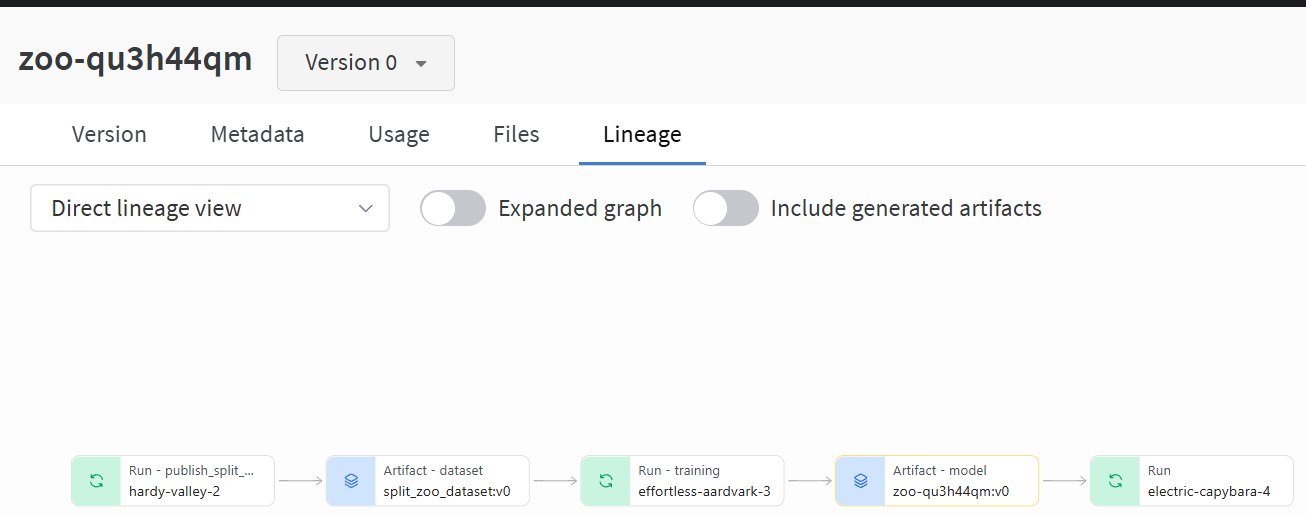

zoo-qu warna bordernya kuning artinya model registry saat ini diarahkan/direferensikan ke model artifact version zoo-qu

hardy-valley-2 menggunakan artifact split_zoo yang merupakan dataset (ingat ini adalah dataset yang telah di split ke train dan test)

effortless akan melakukan training (train model) menggunakan dataset split_zoo (dataset yang telah di split) dan hasil trainingnya (file hasil training) akan dimasukkan kedalam model artifact zoo-qu3. model ini akan linked ke "Zoo_Classifier_Models

misal suatu team akan menggunakan model dan dataset untuk tujuan inference. hal tersebut disimpan dalam project `Check_Zoo_Model`

team tersebut ingin menggunakan dan download artifact dengan [role permission](https://docs.wandb.ai/guides/registry/configure_registry/#registry-roles-permissions). Dengan demikian team tersebut dapat view dan download dari registry

untuk melakukan hal tersebut kita perlu tahu
1. full name dari artifact yang akan kita gunakan, full name (path) ini akan dimasukkan ke `.use_artifact()`
2. download artifact nya

In [ ]:
# Create model artifact name
REGISTRY_NAME = "model"
COLLECTION_NAME = "Zoo_Classifier_Models"
VERSION = 0

model_artifact_name = f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{VERSION}"
print(f"Model artifact name: {model_artifact_name}")

Model artifact name: wandb-registry-model/Zoo_Classifier_Models:v0


In [ ]:
# Enter information about your team and your team's project
DIFFERENT_TEAM_ENTITY = "mlops-proj" # seharusnya ini Team yang berbeda misal TEAM_B
DIFFERENT_PROJECT = "Check_Zoo_Model"

run = wandb.init(entity=DIFFERENT_TEAM_ENTITY, project=DIFFERENT_PROJECT)
registry_model = run.use_artifact(artifact_or_name=model_artifact_name)
local_model_path = registry_model.download()

wandb:   1 of 1 files downloaded.  


buat ulang modelnya

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=16 , out_features=16),
            nn.Sigmoid(),
            nn.Linear(in_features=16, out_features=7)
        )

    def forward(self, x):
        logits = self.linear_stack(x)
        return logits

loaded_model = NeuralNetwork()
# LOAD MODEL DARI ARTIFACT
loaded_model.load_state_dict(torch.load(f=local_model_path + "/zoo_wandb_1000.pth"))

<ipython-input-32-34b97e9f178b>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=local_model_path + "/zoo_wandb_1000.pth"))


<All keys matched successfully>

Lalukan inference menggunakan dataset test yang berasal dari artifact

In [ ]:
# Create dataset artifact name
REGISTRY_NAME = "dataset"
COLLECTION_NAME = "zoo-dataset-tensors-split"
VERSION = 0

data_artifact_name = f"wandb-registry-{REGISTRY_NAME}/{COLLECTION_NAME}:v{VERSION}"
print(f"Dataset artifact name: {data_artifact_name}")

Dataset artifact name: wandb-registry-dataset/zoo-dataset-tensors-split:v0


download artifact dataset

In [ ]:
run = wandb.init(entity=DIFFERENT_TEAM_ENTITY, project=DIFFERENT_PROJECT)
dataset_artifact = run.use_artifact(artifact_or_name=data_artifact_name, type="dataset")
local_dataset_path = dataset_artifact.download()

wandb:   4 of 4 files downloaded.  


In [ ]:
# Test data and label filenames
test_data_filename = "zoo_dataset_X_test"
test_labels_filename = "zoo_labels_y_test"

# Load dataset and labels into notebook
loaded_data = torch.load(f"{local_dataset_path}/{test_data_filename}")
loaded_labels = torch.load(f"{local_dataset_path}/{test_labels_filename}")

wandb.finish()

<ipython-input-35-1a4e7c669e86>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load(f"{local_dataset_path}/{test_data_filename}")
<ipython-input-35-1a4

prediksi

In [ ]:
# DECODE ANGKA MENJADI KELAS
class_labels = {
    0: "Aves",
    1: "Mammalia",
    2: "Reptilia",
    3: "Actinopterygii",
    4: "Amphibia",
    5: "Insecta",
    6: "Crustacea",
}

In [ ]:
outputs = loaded_model(loaded_data) # LOAD MODEL
__, predicted = torch.max(outputs, 1) # PREDIKSI
predicted

tensor([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 3, 5, 5, 1, 6, 0, 0, 1, 3, 0, 3, 6, 6, 6,
        0, 6])

Bandingkan antara prediksi dengan actually

In [ ]:
results = list(map(lambda x: class_labels.get(x), predicted.numpy()))
true_values = list(map(lambda x: class_labels.get(x), loaded_labels.squeeze().numpy()))

# Create pandas DataFrame
df = pd.DataFrame(
    {
        'Predicted': results,
        'True values': true_values
    }
)

# Create new column where we compare the predicted vs true
df["Predicted correctly"] = df["Predicted"] == df["True values"]

In [ ]:
df

,Predicted,True values,Predicted correctly
0,Aves,Aves,True
1,Aves,Aves,True
2,Aves,Aves,True
3,Aves,Aves,True
4,Aves,Aves,True
5,Insecta,Insecta,True
6,Aves,Aves,True
7,Aves,Aves,True
8,Aves,Aves,True
9,Aves,Aves,True


In [ ]:
# MODEL MEMPREDIKSI DENGAN BENAR
# Count how many predictions were wrong
df['Predicted correctly'].value_counts()

,count
Predicted correctly,
True,22
False,4


In [ ]:
# LIHAT PERSENTASE PREDIKSI YANG BENAR
# Get percentage
df['Predicted correctly'].value_counts(normalize=True).mul(100).astype(str)+'%'

,proportion
Predicted correctly,
True,84.61538461538461%
False,15.384615384615385%


https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-artifacts/Pipeline_Versioning_with_W%26B_Artifacts.ipynb#scrollTo=tm04A2cdBLpF

## repository huggingface

## simpan dataset ke huggingface hub

In [ ]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `qna` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

format dataset yang kita buat

In [ ]:
message = [
        {
            "content": "Translate this from sas to python\n Some sas code",
            "role": "user"},
        {
            "content": "python code.",
            "role": "assistant",
        }
    ]

buat 600 data dummy

In [ ]:
messages  = [message for i in range(600)]
dataset_messages = {"messages": messages}

In [ ]:
dataset_messages

{'messages': [[{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'assistant'}],
  [{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'assistant'}],
  [{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'assistant'}],
  [{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'assistant'}],
  [{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'assistant'}],
  [{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'assistant'}],
  [{'content': 'Translate this from sas to python\n Some sas code',
    'role': 'user'},
   {'content': 'python code.', 'role': 'a

load dataset ke huggingface dataset

In [ ]:
from datasets import Dataset
msg_ds = Dataset.from_dict(dataset_messages)
msg_ds = msg_ds.train_test_split(test_size=0.1, seed=42)

In [ ]:
msg_ds

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 60
    })
})

upload dataset ke huggingface yang di private

In [ ]:
msg_ds.push_to_hub("practice-ac/simple_dict_dataset", private=True)
msg_ds["train"].push_to_hub("practice-ac/simple_dict_dataset", split="train_ift", private=True)
msg_ds["test"].push_to_hub("practice-ac/simple_dict_dataset", split="test_ift", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/practice-ac/simple_dict_dataset/commit/da401907646ece8a702f7151302ae6f8c289ccd2', commit_message='Upload dataset', commit_description='', oid='da401907646ece8a702f7151302ae6f8c289ccd2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/practice-ac/simple_dict_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='practice-ac/simple_dict_dataset'), pr_revision=None, pr_num=None)

karena private artinya kita ingin yang mengakses dataset harus punya otentikasi (punya token) sehingga ketika load model harus disertakan token=True

In [ ]:
ds = load_dataset("practice-ac/simple_dict_dataset", token=True)
ds

Generating train split:   0%|          | 0/540 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating train_ift split:   0%|          | 0/540 [00:00<?, ? examples/s]

Generating test_ift split:   0%|          | 0/60 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 60
    })
    train_ift: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test_ift: Dataset({
        features: ['messages'],
        num_rows: 60
    })
})

hapus dataset

In [ ]:
from huggingface_hub import delete_repo
delete_repo(repo_id="practice-ac/simple_dict_dataset", repo_type="dataset")

load dataset yang telah dihapus, ketika dihapus masih ada karena yang ditampilkan adalah cache

In [ ]:
ds = load_dataset("practice-ac/simple_dict_dataset")
ds

Using the latest cached version of the dataset since practice-ac/simple_dict_dataset couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/practice-ac___simple_dict_dataset/default/0.0.0/da401907646ece8a702f7151302ae6f8c289ccd2 (last modified on Sat Jan  4 08:48:58 2025).


DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 60
    })
    train_ift: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test_ift: Dataset({
        features: ['messages'],
        num_rows: 60
    })
})

jadi kita harus hapus cache nya

In [ ]:
!rm -rf /root/.cache/huggingface/datasets/*

load ulang dataset yang telah dihapus

In [ ]:
ds = load_dataset("practice-ac/simple_dict_dataset")
ds

RepositoryNotFoundError: 404 Client Error. (Request ID: Root=1-6778f74d-2b2e0c8c7ca938813322787a;a61ba70b-6042-4d0e-9211-34735c239532)

Repository Not Found for url: https://huggingface.co/datasets/practice-ac/simple_dict_dataset/resolve/da401907646ece8a702f7151302ae6f8c289ccd2/simple_dict_dataset.py.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated.

sekarang sudah benar, error karena memang datasetnya tidak ada (sudah kita hapus)

selain dengan cara diatas, kita bisa membuat dulu repo bertipe dataset

In [ ]:
from huggingface_hub import create_repo
create_repo("practice-ac/simple_dict_dataset", repo_type="dataset")

RepoUrl('https://huggingface.co/datasets/practice-ac/simple_dict_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='practice-ac/simple_dict_dataset')

kita cek isi repo, seharusnya kosong

In [ ]:
ds = load_dataset("practice-ac/simple_dict_dataset")
ds

EmptyDatasetError: The directory at hf://datasets/practice-ac/simple_dict_dataset@486aa250e91b4e2565b34c0c8af662b976afa9b6 doesn't contain any data files

pesan errornya sesuai harapan yaitu tidak ada data files

kita push dataset ke repo yang telah dibuat, kita buat public

In [ ]:
msg_ds.push_to_hub("practice-ac/simple_dict_dataset")
msg_ds["train"].push_to_hub("practice-ac/simple_dict_dataset", split="train_ift")
msg_ds["test"].push_to_hub("practice-ac/simple_dict_dataset", split="test_ift")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/practice-ac/simple_dict_dataset/commit/6a5027b2f3a75e9d7b7f2b0b46db0e96cf7b964d', commit_message='Upload dataset', commit_description='', oid='6a5027b2f3a75e9d7b7f2b0b46db0e96cf7b964d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/practice-ac/simple_dict_dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='practice-ac/simple_dict_dataset'), pr_revision=None, pr_num=None)

load dataset

In [ ]:
ds = load_dataset("practice-ac/simple_dict_dataset")
ds

Generating train split:   0%|          | 0/540 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating train_ift split:   0%|          | 0/540 [00:00<?, ? examples/s]

Generating test_ift split:   0%|          | 0/60 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test: Dataset({
        features: ['messages'],
        num_rows: 60
    })
    train_ift: Dataset({
        features: ['messages'],
        num_rows: 540
    })
    test_ift: Dataset({
        features: ['messages'],
        num_rows: 60
    })
})

hapus dataset

In [ ]:
delete_repo(repo_id="practice-ac/simple_dict_dataset", repo_type="dataset")

sumber

https://twodatadetectives.medium.com/push-your-custom-dataset-to-huggingface-two-ways-47482e8a0f34

https://huggingface.co/docs/datasets/upload_dataset

https://huggingface.co/docs/huggingface_hub/guides/repository

## simpan model ke huggingface hub

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
dataset = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
training_args = TrainingArguments(
 output_dir="./results",
 learning_rate=2e-5,
 per_device_train_batch_size=16,
 per_device_eval_batch_size=16,
 num_train_epochs=3,
 weight_decay=0.01,
 evaluation_strategy="epoch"
)
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return {"accuracy": (predictions == labels).mean()}
trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_datasets["train"],
  eval_dataset=tokenized_datasets["test"],
  compute_metrics=compute_metrics
)
trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.204900,0.207810,0.924560
2,0.128800,0.216585,0.937240
3,0.067600,0.257120,0.942360


TrainOutput(global_step=4689, training_loss=0.1476855405131035, metrics={'train_runtime': 10742.8744, 'train_samples_per_second': 6.981, 'train_steps_per_second': 0.436, 'total_flos': 1.9733329152e+16, 'train_loss': 0.1476855405131035, 'epoch': 3.0})

In [ ]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `qna` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when

In [ ]:
trainer.push_to_hub("practice-ac/finetuning-model")

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

events.out.tfevents.1735990998.72d2474637fc.451.0:   0%|          | 0.00/8.25k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/practice-ac/results/commit/42d17eee331349acff19636fc2f5424414a29052', commit_message='practice-ac/finetuning-model', commit_description='', oid='42d17eee331349acff19636fc2f5424414a29052', pr_url=None, repo_url=RepoUrl('https://huggingface.co/practice-ac/results', endpoint='https://huggingface.co', repo_type='model', repo_id='practice-ac/results'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("practice-ac/results", num_labels=2)
text = "I love this movie!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
output

SequenceClassifierOutput(loss=None, logits=tensor([[-3.6036,  3.0325]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
output.logits.argmax()

tensor(1)

In [ ]:
text = "hate this movie!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
output

SequenceClassifierOutput(loss=None, logits=tensor([[ 3.0329, -2.5733]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
output.logits.argmax()

tensor(0)

In [ ]:
text = "fucking this movie!"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
output.logits.argmax()

tensor(0)

In [1]:
from transformers import pipeline
model_name = "practice-ac/results"
classifier = pipeline("text-classification", model=model_name, tokenizer="bert-base-uncased")
print(classifier("I love this movie!"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'LABEL_1', 'score': 0.9986894726753235}]


In [2]:
print(classifier("fucking this movie!"))

[{'label': 'LABEL_0', 'score': 0.9971895813941956}]


In [8]:
pred = classifier("hate this movie!")

In [9]:
pred[0].get("label")

'LABEL_0'

In [13]:
def convert(pred):
  if pred == "LABEL_0":
    return "negative"
  else:
    return "positive"

In [12]:
convert(pred[0].get("label"))

'negative'

In [15]:
pred = classifier("wonderful movie!")

In [16]:
convert(pred[0].get("label"))

'positive'

sumber

https://medium.com/@arthurneuron/how-do-i-create-my-own-model-for-huggingface-f5945bb02b8f

https://huggingface.co/blog/not-lain/trainer-api-and-mixin-classes

https://huggingface.co/blog/not-lain/custom-architectures-with-huggingface

https://huggingface.co/docs/transformers/custom_models

https://huggingface.co/docs/transformers/v4.17.0/en/create_a_model

# automation

## with github action (CI)
[link projek kasus ini](https://github.com/muhsufyan/ci-wandb-mlops/blob/main/.github/workflows/ci.yaml) dan [file python nya](https://github.com/muhsufyan/ci-wandb-mlops/blob/main/inference_model.py)

Setting token untuk github
1. pada menu Team (sebelah kiri) pilih team nya misal mlops-proj
2. pilih Settings
3. scroll down, hingga ke bagian Team secrets pilih New secret
4. muncul pop up, isi secret name dengan GITHUB_TOKEN dan secret diisi dengan token PAT dari github yang telah kita buat
5. jika telah diisi maka pilih Add secret

Setting webhook
1. pada menu Team (sebelah kiri) pilih team nya misal mlops-proj
2. pilih Settings
3. scroll down, hingga ke bagian Webhooks pilih New webhook
4. muncul pop up. isi name dengan nama webhook misal github action, isi Access Token dengan token PAT yang sudah kita isikan sebelumnya di Secret (jadi tinggal pilih saja GITHUB_TOKEN), isi URL dengan url repo github dengan format https://api.github.com/repos/muhsufyan/ci-wandb-mlops/dispatches

buat automation pada model registry
1. pilih menu registry dibagian kiri
2. pilih Model
3. pilih model yang akan di automation, misal kita pilih Zoo_classifier_Models
4. pilih yang bulat 3 (setting) dan muncul pop-up lalu pilih create automation

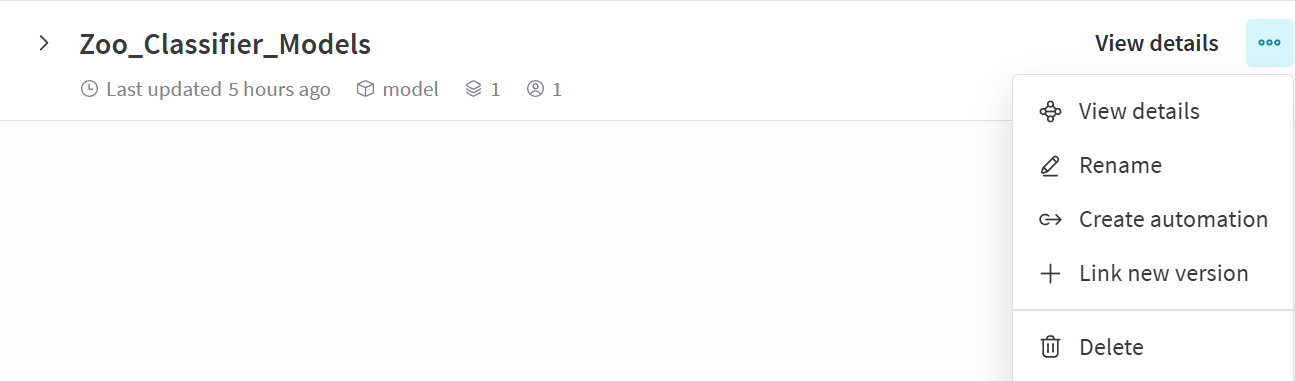

5. muncul pop-up, dan akan ada dropdown. di dropdown ini kita bisa pilih 2 pilihan yaitu yang pertama menggunakan versi dari model yang ada di collection atau kedua menggunakan artifact melalui alias. kita pilih yang kedua (artifact)

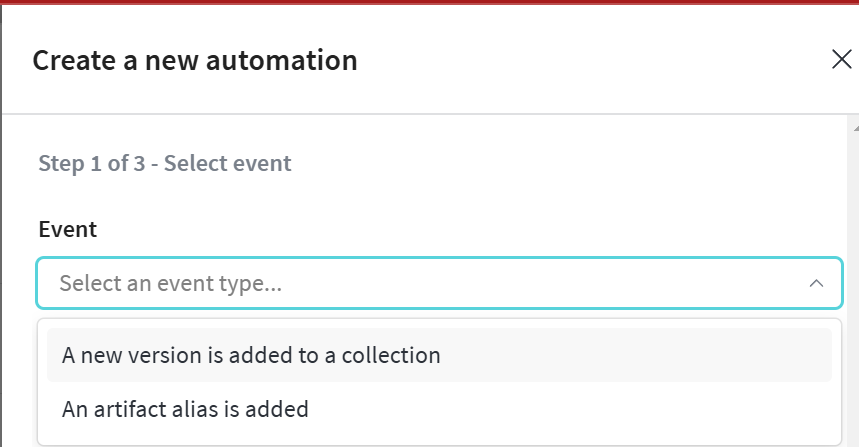

6. dibagian Alias regex isi dengan Aliases. karena dibagian tersebut saat ini hanya ada 1 dan alias nya adalah @latest maka kita isi Alias regex dengan latest. seharusnya ketika kita buat alias untuk model misalnya staging, production, testing, experiment sehingga dibagian Alias regex kita isi dengan production misalnya
7. pilih Next step
8. step selanjutnya, pada Team pilih Team (karena kita hanya punya 1 team yaitu mlops-proj maka isi dengan mlops-proj)
9. bagian Action type ada 2 piliha yaitu jobs atau webhook. kita pilih webhook
10. muncul pop-up, bagian webhook pilih nama webhook yang telah kita buat dimana pada kasus ini kita pilih webhook bernama github action
11. pada bagian payload isi
```yaml
{
  "event_type": "test-and-report",
  "client_payload":
  {
    "my_custom_string": "custom",
    "event_type": "${event_type}",
    "event_author": "${event_author}",
    "artifact_version": "${artifact_version}",
    "artifact_version_string": "${artifact_version_string}",
    "artifact_collection_name": "${artifact_collection_name}",
    "project_name": "${project_name}",
    "entity_name": "${entity_name}"
    }
}
```
dan pilih Next step

12. isi Automation name. kasus ini kita isi dengan test automation dan pilih Create automation

buat manifes CI di github

In [ ]:
%%writefile ci.yaml
name: Test ML Model

on:
  repository_dispatch:
    types: "test-and-report"

# A workflow run is made up of one or more jobs that can run sequentially or in parallel
jobs:
  test_and_report:
    # The type of runner that the job will run on
    runs-on: ubuntu-latest
    env:
      WANDB_API_KEY: ${{ secrets.WANDB_API_KEY }}

    # Steps represent a sequence of tasks that will be executed as part of the job
    steps:
    - uses: actions/checkout@v3

    - name: Set up Python
      uses: actions/setup-python@v4
      with:
        python-version: '3.7.13'
        cache: 'pip'

    - name: Install Dependencies
      run: pip install wandb
      # run: pip install -r ./.github/workflows/requirements.txt

    - name: Login to W&B
      run: wandb login

    # Use the payload to pull down relevant artifacts, test and deploy them!
    - name: Echo Template Strings from W&B Webhook
      run: |
        echo -e "${{ github.event.client_payload.my_custom_string1 }}\n\
        ${{ github.event.client_payload.my_custom_string2 }}\n\
        ${{ github.event.client_payload.event_type }}\n\
        ${{ github.event.client_payload.event_author }}\n\
        ${{ github.event.client_payload.artifact_version }}\n\
        ${{ github.event.client_payload.artifact_version_string }}\n\
        ${{ github.event.client_payload.artifact_collection_name }}\n\
        ${{ github.event.client_payload.project_name }}\n\
        ${{ github.event.client_payload.entity_name }}"

    - name: Retrieve Artifacts
      run: python .github/workflows/retrieve_artifacts.py --registered_model_name "${{ github.event.client_payload.artifact_version_string }}"

    - name: Test Model Loading and Inference
      run: pytest -s --artifact_path ./wandb_artifact_cache

    - name: Generate W&B Report with Reports API
      run: python generate_report.py # Check out https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Report_API_Quickstart.ipynb for more details

lalu buat file

In [ ]:
import wandb
import os
import click

@click.command()
@click.option('--registered_model_name', default='entity/model-registry/Nature Classification:production')
@click.option('--test_dataset', default='entity/project/Nature_100:latest')
@click.option('--target_dir', default='artifact_cache')
def main(registered_model_name, test_dataset, target_dir):
    wandb.init(project, entity, job_type='CI')
    model_art = wandb.use_artifact(registered_model_name)

    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    model_art.download(root=os.path.join(target_dir, "models"))

if __name__ == '__main__':
    main()

## automation SKIP

https://docs.wandb.ai/guides/model_registry/model-registry-automations/

https://wandb.ai/wandb/wandb-model-cicd/reports/Model-CI-CD-with-W-B--Vmlldzo0OTcwNDQw

https://www.youtube.com/playlist?list=PLD80i8An1OEGECFPgY-HPCNjXgGu-qGO6

https://wandb.ai/capecape/fashion-launch/reports/Automating-Model-Evaluation-With-W-B-Launch--Vmlldzo0NDQ2NTIz

### [3](https://wandb.ai/examples/wandb_automations/reports/A-Tutorial-on-Model-CI-with-W-B-Automations--Vmlldzo0NDY5OTIx)

In [ ]:
!pip install wandb
!wandb login # edc9dadd05adc26eaf20d31d146e02dc73b5b9f3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!git clone https://github.com/wandb/examples.git
# disini ada train.py, eval.py dan utils.py (untuk save_model dan load_model)
%cd examples/examples/wandb-automations
# %pip install -r requirements.txt

Cloning into 'examples'...
remote: Enumerating objects: 10330, done.
remote: Counting objects: 100% (1983/1983), done.
remote: Compressing objects: 100% (921/921), done.
remote: Total 10330 (delta 1326), reused 1442 (delta 1021), pack-reused 8347 (from 1)
Receiving objects: 100% (10330/10330), 718.81 MiB | 17.54 MiB/s, done.
Resolving deltas: 100% (6092/6092), done.
Updating files: 100% (454/454), done.
/content/examples/examples/wandb-automations
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install -r requirements.txt (line 2) and torch==1.13.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested torch==1.13.1
    torchvision 0.13.1 depends on torch==1.12.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the depe

In [ ]:
%pwd

'/content/examples/examples/wandb-automations'

In [ ]:
!python train.py

Traceback (most recent call last):
  File "/content/examples/examples/wandb-automations/train.py", line 4, in <module>
    import timm
ModuleNotFoundError: No module named 'timm'


In [ ]:
!python eval.py

In [ ]:
# agent mengeksekusi job dari queue
!pip install wandb --upgrade
!wandb launch-agent -e examples -q "Starter queue"

In [ ]:
# train ulang, untuk membuat model baru
!python train.py --model_name="resnet18"

## [log plot](https://docs.wandb.ai/guides/track/log/plots)

### Basic charts

In [ ]:
# Start by installing the W&B library
!pip install wandb -qqq

In [ ]:
import wandb
import random
import math

# Start a new run
run = wandb.init(project='custom-charts')
offset = random.random()

# At each time step in the model training loop
for run_step in range(20):

  # SIMPAN LOG METRICS BERUPA AKURASI
  # Log basic experiment metrics, which show up as standard line plots in the UI
  wandb.log({
      "acc": math.log(1 + random.random() + run_step) + offset,
      "val_acc": math.log(1 + random.random() + run_step) + offset * random.random(),
  }, commit=False)

  # Set up data to log in custom charts
  data = []
  for i in range(100):
    data.append([i, random.random() + math.log(1 + i) + offset + random.random()])

  # SIMPAN DATASET BERUPA TABEL (KARENA DATANYA TABULAR DG KOLOM STEP DAN HEIGHT)
  # Create a table with the columns to plot
  table = wandb.Table(data=data, columns=["step", "height"])

  # Use the table to populate various custom charts
  # SIMPAN LINE PLOT DARI DATA DENGAN X ADALAH KOLOM STEP DAN Y ADALAH KOLOM HEIGHT
  line_plot = wandb.plot.line(table, x='step', y='height', title='Line Plot')
  # SIMPAN HISTOGRAM DARI DATA, DIMANA HANYA KOLOM HEIGHT
  histogram = wandb.plot.histogram(table, value='height', title='Histogram')
  # SIMPAN SCATTER DARI DATA DG X ADALAH KOLOM STEP DAN Y ADALAH KOLOM HEIGHT
  scatter = wandb.plot.scatter(table, x='step', y='height', title='Scatter Plot')

  # SIMPAN PLOT KEDALAM 1 LOG YANG SAMA
  # Log custom tables, which will show up in customizable charts in the UI
  wandb.log({'line_1': line_plot,
             'histogram_1': histogram,
             'scatter_1': scatter})

# Finally, end the run. We only need this ine in Jupyter notebooks.
run.finish()

acc,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇████
val_acc,▁▁▃▄▄▅▅▆▆▆▆▇▇▇▇▇████
acc,3.12942
val_acc,3.04903


### [Custom chart](https://wandb.ai/wandb/posts/reports/The-W-B-Machine-Learning-Visualization-IDE--VmlldzoyNjk3Nzg)

In [ ]:
# Start a new run
run = wandb.init(project='custom-charts',
                 notes='Custom stacked bar chart')
offset = random.random()

# Set up data to log in custom charts
data = []
for i in range(100):
  data.append([i, random.random() + math.log(1 + i) + offset + random.random()])

# Create a table with the columns to plot
table = wandb.Table(data=data, columns=["step", "height"])

# Map from the table's columns to the chart's fields
fields = {"x": "step",
          "value": "height"}

# Use the table to populate the new custom chart preset
# To use your own saved chart preset, change the vega_spec_name
my_custom_chart = wandb.plot_table(vega_spec_name="carey/new_chart",
              data_table=table,
              fields=fields,
              )

# Log the plot to have it show up in the UI
wandb.log({"custom_chart": my_custom_chart})

# Finally, end the run. We only need this ine in Jupyter notebooks.
run.finish()

### PRECISION RECALL
`wandb.plot.pr_curve()`

penerapannya `wandb.log({"pr": wandb.plot.pr_curve(ground_truth, predictions)})`

In [ ]:
# DOWNLOAD DATASET
%%capture
!curl -SL https://storage.googleapis.com/wandb_datasets/nature_12K.zip > nature_12K.zip
!unzip nature_12K.zip

In [ ]:
!pip3 install tensorflow -qqq
!pip3 install wandb -qqq
import wandb
!wandb login

kita gunakan model pretrained

In [ ]:
# this determines the name of your wandb project, where all your
# runs will be loggeed
PROJECT_NAME = "custom_pr_curve"

# EXPERIMENT CONFIG
#---------------------------
# try changing the number of training examples
# to generate a range of different PR curves
NUM_TRAIN = 100 # try 500, 1000, 2000, or max 10000
NUM_EPOCHS = 1 # try 3, 5, or as many as you like

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from wandb.integration.keras import WandbCallback

# local paths to data
train_data = "inaturalist_12K/train"
val_data = "inaturalist_12K/val"

# experiment configuration saved to W&B
config_defaults = {
  # number of images used to train--set low for demo training speed
  # you can set this up to 10000 for the full dataset
  # GOOD CONFIG TO TRY: 100, 500, 1000, 2000
  "num_train" : NUM_TRAIN, # up to 10000,
  # number of images used to validate--set low for demo training speed
  # you can set this up to 2000 for the full dataset
  "num_val" : 500, #2000,
  "num_classes" : 10,
  "fc_size" : 1024,

  # inceptionV3 settings
  "img_width" : 299,
  "img_height": 299,
  "batch_size" : 32,

  # number of epochs--set low for demo training speed
  # you can set this up to 5, 10, or more for better results
  # GOOD CONFIG TO TRY: 3, 5, 10
  "pretrain_epochs" : NUM_EPOCHS, #5,
  # number of validation data batches to use when computing metrics
  # at the end of each epoch
  "num_log_batches": 15
}

def build_model(fc_size, num_classes):
  """Load InceptionV3 with ImageNet weights, freeze it,
  and attach a finetuning top for this classification task"""
  # load InceptionV3 as base
  base = InceptionV3(weights="imagenet", include_top="False")
  # freeze base layers
  for layer in base.layers:
    layer.trainable = False
  x = base.get_layer('mixed10').output

  # attach a fine-tuning layer
  x = GlobalAveragePooling2D()(x)
  x = Dense(fc_size, activation='relu')(x)
  guesses = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base.input, outputs=guesses)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

def pretrain():
  """ Main training loop. This is called pretrain because it freezes
  the InceptionV3 layers of the model and only trains the new top layers
  on the new data.   subsequent training phase would unfreeze all the layers
  and finetune the whole model on the new data"""
  # track this experiment with wandb: all runs will be sent
  # to the given project name
  wandb.init(project=PROJECT_NAME, config=config_defaults)
  # KONFIGURASI MODEL
  cfg = wandb.config

  # create train and validation data generators
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
  val_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(cfg.img_width, cfg.img_height),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(cfg.img_width, cfg.img_height),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  # instantiate model and callbacks
  model = build_model(cfg.fc_size, cfg.num_classes)
  callbacks = [WandbCallback(), PRMetrics(val_generator, num_log_batches=15)]

  # train!
  model.fit(
    train_generator,
    steps_per_epoch = cfg.num_train // cfg.batch_size,
    epochs=cfg.pretrain_epochs,
    validation_data=val_generator,
    callbacks = callbacks,
    validation_steps=cfg.num_val // cfg.batch_size)

  wandb.run.finish()

# BUAT CALLBACK UNTUK KURVA PRECISION RECALL (PR)
class PRMetrics(Callback):
  """ Custom callback to compute per-class PR & ROC curves
  at the end of each training epoch"""
  def __init__(self, generator=None, num_log_batches=1):
    self.generator = generator
    self.num_batches = num_log_batches
    # store full names of classes
    self.class_names = { v: k for k, v in generator.class_indices.items() }
    self.flat_class_names = [k for k, v in generator.class_indices.items()]

  def on_epoch_end(self, epoch, logs={}):
    # collect validation data and ground truth labels from generator
    val_data, val_labels = zip(*(self.generator[i] for i in range(self.num_batches)))
    val_data, val_labels = np.vstack(val_data), np.vstack(val_labels)

    # use the trained model to generate predictions for the given number
    # of validation data batches (num_batches)
    val_predictions = self.model.predict(val_data)
    ground_truth_class_ids = val_labels.argmax(axis=1)

    # SIMPAN LOG KURVA PRECISION-RECALL KE WANDB
    # Log precision-recall curve
    # the key "pr_curve" is the id of the plot--do not change
    # this if you want subsequent runs to show up on the same plot
    wandb.log({"pr_curve" : wandb.plot.pr_curve(ground_truth_class_ids,
                                                val_predictions,
                                                labels=self.flat_class_names)})

In [ ]:
# run this cell to launch your experiment!
# charts will show up in your run page under the heading "Custom Charts",
# which you may need to click on to expand
pretrain()

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'Node' object has no attribute 'inbound_layers'

### ROC AUC
`wandb.plot.roc_curve()`

penerapannya

`wandb.log({"roc": wandb.plot.roc_curve(ground_truth, predictions)})`

In [ ]:
# this determines the name of your wandb project, where all your
# runs will be loggeed
PROJECT_NAME = "custom_roc_curve"

# EXPERIMENT CONFIG
#---------------------------
# try changing the number of training examples
# to generate a range of different PR curves
NUM_TRAIN = 100 # try 500, 1000, 2000, or max 10000
NUM_EPOCHS = 1 # try 3, 5, or as many as you like

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from wandb.integration.keras import WandbCallback

# local paths to data
train_data = "inaturalist_12K/train"
val_data = "inaturalist_12K/val"

# experiment configuration saved to W&B
config_defaults = {
  # number of images used to train--set low for demo training speed
  # you can set this up to 10000 for the full dataset
  # GOOD CONFIG TO TRY: 100, 500, 1000, 2000
  "num_train" : NUM_TRAIN, # up to 10000,
  # number of images used to validate--set low for demo training speed
  # you can set this up to 2000 for the full dataset
  "num_val" : 500, #2000,
  "num_classes" : 10,
  "fc_size" : 1024,

  # inceptionV3 settings
  "img_width" : 299,
  "img_height": 299,
  "batch_size" : 32,

  # number of epochs--set low for demo training speed
  # you can set this up to 5, 10, or more for better results
  # GOOD CONFIG TO TRY: 3, 5, 10
  "pretrain_epochs" : NUM_EPOCHS, #5,
  # number of validation data batches to use when computing metrics
  # at the end of each epoch
  "num_log_batches": 15
}

def build_model(fc_size, num_classes):
  """Load InceptionV3 with ImageNet weights, freeze it,
  and attach a finetuning top for this classification task"""
  # load InceptionV3 as base
  base = InceptionV3(weights="imagenet", include_top="False")
  # freeze base layers
  for layer in base.layers:
    layer.trainable = False
  x = base.get_layer('mixed10').output

  # attach a fine-tuning layer
  x = GlobalAveragePooling2D()(x)
  x = Dense(fc_size, activation='relu')(x)
  guesses = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base.input, outputs=guesses)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

def pretrain():
  """ Main training loop. This is called pretrain because it freezes
  the InceptionV3 layers of the model and only trains the new top layers
  on the new data.   subsequent training phase would unfreeze all the layers
  and finetune the whole model on the new data"""
  # track this experiment with wandb: all runs will be sent
  # to the given project name
  wandb.init(project=PROJECT_NAME, config=config_defaults)
  cfg = wandb.config

  # create train and validation data generators
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
  val_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(cfg.img_width, cfg.img_height),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(cfg.img_width, cfg.img_height),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  # instantiate model and callbacks
  model = build_model(cfg.fc_size, cfg.num_classes)
  callbacks = [WandbCallback(), PRMetrics(val_generator, num_log_batches=15)]

  # train!
  model.fit(
    train_generator,
    steps_per_epoch = cfg.num_train // cfg.batch_size,
    epochs=cfg.pretrain_epochs,
    validation_data=val_generator,
    callbacks = callbacks,
    validation_steps=cfg.num_val // cfg.batch_size)

  wandb.run.finish()

class PRMetrics(Callback):
  """ Custom callback to compute per-class PR & ROC curves
  at the end of each training epoch"""
  def __init__(self, generator=None, num_log_batches=1):
    self.generator = generator
    self.num_batches = num_log_batches
    # store full names of classes
    self.class_names = { v: k for k, v in generator.class_indices.items() }
    self.flat_class_names = [k for k, v in generator.class_indices.items()]

  def on_epoch_end(self, epoch, logs={}):
    # collect validation data and ground truth labels from generator
    val_data, val_labels = zip(*(self.generator[i] for i in range(self.num_batches)))
    val_data, val_labels = np.vstack(val_data), np.vstack(val_labels)

    # use the trained model to generate predictions for the given number
    # of validation data batches (num_batches)
    val_predictions = self.model.predict(val_data)
    ground_truth_class_ids = val_labels.argmax(axis=1)

    # Log precision-recall curve
    # the key "pr_curve" is the id of the plot--do not change
    # this if you want subsequent runs to show up on the same plot
    wandb.log({"roc_curve" : wandb.plot.roc_curve(ground_truth_class_ids, val_predictions, labels=self.flat_class_names)})

In [ ]:
# run this cell to launch your experiment!
# charts will show up in your run page under the heading "Custom Charts",
# which you may need to click on to expand
pretrain()

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'Node' object has no attribute 'inbound_layers'

### confusion metrics
`wandb.plot.confusion_matrix()`

penerapannya

```python
cm = wandb.plot.confusion_matrix(
    y_true=ground_truth, preds=predictions, class_names=class_names
)

wandb.log({"conf_mat": cm})
```

In [ ]:
# this determines the name of your wandb project, where all your
# runs will be logged
PROJECT_NAME = "confusion_matrix"

# EXPERIMENT CONFIG
#---------------------------
# try changing the number of training examples
# to generate a range of different models
NUM_TRAIN = 100 # try 500, 1000, 2000, or max 10000
NUM_EPOCHS = 1 # try 3, 5, or as many as you like

import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from wandb.integration.keras import WandbCallback

# local paths to data
train_data = "inaturalist_12K/train"
val_data = "inaturalist_12K/val"

# experiment configuration saved to W&B
config_defaults = {
  # number of images used to train--set low for demo training speed
  # you can set this up to 10000 for the full dataset
  # GOOD CONFIG TO TRY: 100, 500, 1000, 2000
  "num_train" : NUM_TRAIN, # up to 10000,
  # number of images used to validate--set low for demo training speed
  # you can set this up to 2000 for the full dataset
  "num_val" : 500, #2000,
  "num_classes" : 10,
  "fc_size" : 1024,

  # inceptionV3 settings
  "img_width" : 299,
  "img_height": 299,
  "batch_size" : 32,

  # number of epochs--set low for demo training speed
  # you can set this up to 5, 10, or more for better results
  # GOOD CONFIG TO TRY: 3, 5, 10
  "pretrain_epochs" : NUM_EPOCHS, #5,
  # number of validation data batches to use when computing metrics
  # at the end of each epoch
  "num_log_batches": 15,
  # random seed
  "random_seed": 23
}

def build_model(fc_size, num_classes):
  """Load InceptionV3 with ImageNet weights, freeze it,
  and attach a finetuning top for this classification task"""
  # load InceptionV3 as base
  base = InceptionV3(weights="imagenet", include_top="False")
  # freeze base layers
  for layer in base.layers:
    layer.trainable = False
  x = base.get_layer('mixed10').output

  # attach a fine-tuning layer
  x = GlobalAveragePooling2D()(x)
  x = Dense(fc_size, activation='relu')(x)
  guesses = Dense(num_classes, activation='softmax')(x)

  model = Model(inputs=base.input, outputs=guesses)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

def pretrain():
  """ Main training loop. This is called 'pretrain' because it freezes
  the InceptionV3 layers of the model and only trains the new top layers
  on the new data. A subsequent training phase would unfreeze all the layers
  and finetune the whole model on the new data"""
  # track this experiment with wandb: all runs will be sent
  # to the given project name
  wandb.init(project=PROJECT_NAME, config=config_defaults)
  cfg = wandb.config

  # set random seed
  tf.random.set_seed(cfg.random_seed)
  # also set numpy seed to control train/val dataset split
  np.random.seed(cfg.random_seed)

  # create train and validation data generators
  train_datagen = ImageDataGenerator(
      rescale=1. / 255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)
  val_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(cfg.img_width, cfg.img_height),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  val_generator = val_datagen.flow_from_directory(
    val_data,
    target_size=(cfg.img_width, cfg.img_height),
    batch_size=cfg.batch_size,
    class_mode='categorical')

  # instantiate model and callbacks
  model = build_model(cfg.fc_size, cfg.num_classes)
  callbacks = [WandbCallback(), PRMetrics(val_generator, cfg.num_log_batches)]

  # train!
  model.fit(
    train_generator,
    steps_per_epoch = cfg.num_train // cfg.batch_size,
    epochs=cfg.pretrain_epochs,
    validation_data=val_generator,
    callbacks = callbacks,
    validation_steps=cfg.num_val // cfg.batch_size)

  wandb.run.finish()

class PRMetrics(Callback):
  """ Custom callback to compute metrics at the end of each training epoch"""
  def __init__(self, generator=None, num_log_batches=1):
    self.generator = generator
    self.num_batches = num_log_batches
    # store full names of classes
    self.flat_class_names = [k for k, v in generator.class_indices.items()]

  def on_epoch_end(self, epoch, logs={}):
    # collect validation data and ground truth labels from generator
    val_data, val_labels = zip(*(self.generator[i] for i in range(self.num_batches)))
    val_data, val_labels = np.vstack(val_data), np.vstack(val_labels)

    # use the trained model to generate predictions for the given number
    # of validation data batches (num_batches)
    val_predictions = self.model.predict(val_data)
    ground_truth_class_ids = val_labels.argmax(axis=1)
    # take the argmax for each set of prediction scores
    # to return the class id of the highest confidence prediction
    top_pred_ids = val_predictions.argmax(axis=1)

    # Log confusion matrix
    # the key "conf_mat" is the id of the plot--do not change
    # this if you want subsequent runs to show up on the same plot
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                            preds=top_pred_ids, y_true=ground_truth_class_ids,
                            class_names=self.flat_class_names)})

In [ ]:
# run this cell to launch your experiment!
# charts will show up in your run page under the heading "Media" or
# "Custom Charts", which you may need to click on to expand
pretrain()

Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


AttributeError: 'Node' object has no attribute 'inbound_layers'

### matplotlib

In [ ]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3, 4])
plt.ylabel("some interesting numbers")
run = wandb.init(project='matplotlib-charts')
wandb.log({"chart": plt})
wandb.run.finish()

### Log Plotly figures to Tables as HTML

In [ ]:
import wandb
import plotly.express as px

# Initialize a new run
run = wandb.init(project="log-plotly-fig-tables", name="plotly_html")

# Create a table
table = wandb.Table(columns=["plotly_figure"])

# Create path for Plotly figure
path_to_plotly_html = "./plotly_figure.html"

# Example Plotly figure
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])

# Write Plotly figure to HTML
# Set auto_play to False prevents animated Plotly charts
# from playing in the table automatically
fig.write_html(path_to_plotly_html, auto_play=False)

# Add Plotly figure as HTML file into Table
table.add_data(wandb.Html(path_to_plotly_html))

# Log Table
run.log({"test_table": table})
wandb.finish()

### Log Bokeh figures to Tables as HTML

In [ ]:
!wget https://www2.cs.uic.edu/~i101/SoundFiles/StarWars3.wav

--2024-09-22 06:13:48--  https://www2.cs.uic.edu/~i101/SoundFiles/StarWars3.wav
Resolving www2.cs.uic.edu (www2.cs.uic.edu)... 131.193.32.16
Connecting to www2.cs.uic.edu (www2.cs.uic.edu)|131.193.32.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132344 (129K) [audio/x-wav]
Saving to: ‘StarWars3.wav’

StarWars3.wav       100%[===================>] 129.24K   451KB/s    in 0.3s    

2024-09-22 06:13:49 (451 KB/s) - ‘StarWars3.wav’ saved [132344/132344]



In [ ]:
from scipy.signal import spectrogram
import holoviews as hv
import panel as pn
from scipy.io import wavfile
import numpy as np
from bokeh.resources import INLINE

hv.extension("bokeh", logo=False)
import wandb


def save_audio_with_bokeh_plot_to_html(audio_path, html_file_name):
    sr, wav_data = wavfile.read(audio_path)
    duration = len(wav_data) / sr
    f, t, sxx = spectrogram(wav_data, sr)
    spec_gram = hv.Image((t, f, np.log10(sxx)), ["Time (s)", "Frequency (hz)"]).opts(
        width=500, height=150, labelled=[]
    )
    audio = pn.pane.Audio(wav_data, sample_rate=sr, name="Audio", throttle=500)
    slider = pn.widgets.FloatSlider(end=duration, visible=False)
    line = hv.VLine(0).opts(color="white")
    slider.jslink(audio, value="time", bidirectional=True)
    slider.jslink(line, value="glyph.location")
    combined = pn.Row(audio, spec_gram * line, slider).save(html_file_name)


html_file_name = "audio_with_plot.html"
audio_path = "/content/StarWars3.wav"
save_audio_with_bokeh_plot_to_html(audio_path, html_file_name)

wandb_html = wandb.Html(html_file_name)
run = wandb.init(project="audio_test")
my_table = wandb.Table(columns=["audio_with_plot"], data=[[wandb_html], [wandb_html]])
run.log({"audio_table": my_table})
run.finish()

<ipython-input-30-df378234be55>:16: RuntimeWarning:

divide by zero encountered in log10



## log table
log data untuk visualize dan query ke W&B.

row bisa berupa  training dataset, step atau epoch selama training, prediksi model pada data tes, objek yang dibuat oleh model, dll.

kolom bisa bertipe numeric, text, boolean, image, video, audio, dll

misal kita buat 2 row, 3 kolom
```python
wandb.Table(columns=["a", "b", "c"], data=[["1a", "1b", "1c"], ["2a", "2b", "2c"]])
```

atau pandas dataframe

```python
wandb.Table(dataframe=my_df)

# assume a model has returned predictions on four images
# with the following fields available:
# - the image id
# - the image pixels, wrapped in a wandb.Image()
# - the model's predicted label
# - the ground truth label
my_data = [
    [0, wandb.Image("img_0.jpg"), 0, 0],
    [1, wandb.Image("img_1.jpg"), 8, 0],
    [2, wandb.Image("img_2.jpg"), 7, 1],
    [3, wandb.Image("img_3.jpg"), 1, 1],
]

# create a wandb.Table() with corresponding columns
columns = ["id", "image", "prediction", "truth"]
test_table = wandb.Table(data=my_data, columns=columns)
```



table bersifat mutable artinya data bisa ditambah atau dikurangi

* menambah row. contoh tambah data/row 3a, 3b, 3c `table.add_data("3a", "3b", "3c")`. jika row nya list maka gunakan tanda bintang contoh `table.add_data(*my_row_list)`
* menambah kolom. contoh `table.add_column(name="col_name", data=col_data)`

```python
# create a Table with the same columns as above,
# plus confidence scores for all labels
columns = ["id", "image", "guess", "truth"]
for digit in range(10):
    columns.append("score_" + str(digit))
test_table = wandb.Table(columns=columns)

# run inference on every image, assuming my_model returns the
# predicted label, and the ground truth labels are available
for img_id, img in enumerate(mnist_test_data):
    true_label = mnist_test_data_labels[img_id]
    guess_label = my_model.predict(img)
    test_table.add_data(img_id, wandb.Image(img), guess_label, true_label)
```



mengakses data pada table
* row iterator. mendptkan row

      for ndx, row in table.iterrows(): ...
* mengakses kolom. `table.get_column("col_name")`

menyimpan table

`wandb.log()`

```python
run = wandb.init()
my_table = wandb.Table(columns=["a", "b"], data=[["1a", "1b"], ["2a", "2b"]])
run.log({"table_key": my_table})
```

menggunakan artifact yang telah ada di wandb. gunakan `use_artifact`

```python
with wandb.init() as run:
    my_table = run.use_artifact("run-<run-id>-<table-name>:<tag>").get("<table-name>")
```







Artifact tables

`artifact.add()` log table disimpan kedalam artifact dibagian run (bukan workspace). hal ini berguna jika kita punya dataset yang disimpan sekali dan nantinya akan menjadi referensi untuk run yang akan datang

```python
run = wandb.init(project="my_project")
# create a wandb Artifact for each meaningful step
test_predictions = wandb.Artifact("mnist_test_preds", type="predictions")

# [build up your predictions data as above]
test_table = wandb.Table(data=data, columns=columns)
test_predictions.add(test_table, "my_test_key")
run.log_artifact(test_predictions)
```
contoh [kode lengkap](http://wandb.me/dsviz-nature-colab)



join artifact table

kita bisa gabungkan table yang ada di artifact. caranya panggil

`wandb.JoinedTable(table_1, table_2, join_key)`

contohnya kita punya table `original_songs` dan `synth_songs`. keduanya memiliki kolom yang sama yaitu `song_id`



```python
import wandb

run = wandb.init(project="my_project")

# fetch original songs table
orig_songs = run.use_artifact("original_songs:latest")
orig_table = orig_songs.get("original_samples")

# fetch synthesized songs table
synth_songs = run.use_artifact("synth_songs:latest")
synth_table = synth_songs.get("synth_samples")

# join tables on "song_id"
join_table = wandb.JoinedTable(orig_table, synth_table, "song_id")
join_at = wandb.Artifact("synth_summary", "analysis")

# add table to artifact and log to W&B
join_at.add(join_table, "synth_explore")
run.log_artifact(join_at)
```



### log summary metrics
Selain nilai yang berubah dari waktu ke waktu selama latihan, penting juga untuk melacak nilai tunggal yang merangkum model atau langkah prapemrosesan. Log informasi ini dalam W&B Run's summary dictionary. Run's summary dictionary dapat menangani array numpy, tensor PyTorch, atau tensor TensorFlow. Ketika sebuah nilai merupakan salah satu dari jenis ini, kita akan menyimpan seluruh tensor dalam sebuah file biner dan menyimpan metrik tingkat tinggi dalam objek summary seperti min, mean, varians, persentil ke-95, dsb.

Nilai terakhir yang dicatat dalam wandb.log secara otomatis ditetapkan sebagai summary dictionary in a W&B Run. Jika summary metric dictionary dimodifikasi, maka nilai sebelumnya akan hilang.

Cuplikan kode di bawah ini menunjukkan bagaimana custom summary metric to W&B:

```python
wandb.init(config=args)

best_accuracy = 0
for epoch in range(1, args.epochs + 1):
    test_loss, test_accuracy = test()
    if test_accuracy > best_accuracy:
        wandb.run.summary["best_accuracy"] = test_accuracy
        best_accuracy = test_accuracy
```

Kita dapat memperbarui atribut summary dari W&B Run yang sudah ada setelah training selesai. Gunakan W&B Public API untuk meng-update atribut summary:

```python
api = wandb.Api()
run = api.run("username/project/run_id")
run.summary["tensor"] = np.random.random(1000)
run.summary.update()
```

Customize summary metrics

berguna untuk menangkap performa model berdasarkan best step, bukan last step, dari training pada `wandb.summary` yang Anda miliki. Sebagai contoh, Anda mungkin ingin mendapat akurasi maksimum atau nilai loss minimum, bukan nilai akhir.

Summary metrics dapat dikontrol dengan menggunakan argumen `summary` dalam `define_metric` yang menerima nilai-nilai berikut: `"min"`, `'max'`, `'mean'`, `'best'`, `'last'`, dan `'none'`. Parameter `"best"` hanya dapat digunakan bersama dengan argumen objective opsional yang menerima nilai `'minimize'` dan `'maximize'`. Berikut adalah contoh untuk mendapatkan nilai loss terendah dan nilai akurasi maksimum dalam summary, daripada menggunakan behavior default summary, yang menggunakan nilai akhir dari history.

```python
import wandb
import random

random.seed(1)
wandb.init()
# define a metric we are interested in the minimum of
wandb.define_metric("loss", summary="min")
# define a metric we are interested in the maximum of
wandb.define_metric("acc", summary="max")
for i in range(10):
    log_dict = {
        "loss": random.uniform(0, 1 / (i + 1)),
        "acc": random.uniform(1 / (i + 1), 1),
    }
    wandb.log(log_dict)
```



# [job](https://docs.wandb.ai/guides/launch/create-launch-job)
launch job digunakan agar bisa melakukan reproduction

untuk membuat dan run job gunakan perintah `wandb launch`

buat job yang sumbernya dari git. artinya code dan asset akan diambil dari repo git. caranya gunakan parameter `--uri` atau `-u` diisi oleh repo git. lalu perintah `--build-context` akan berisi subdirektori. contoh

    wandb launch --uri "https://github.com/wandb/launch-jobs.git" --build-context jobs/hello_world --dockerfile Dockerfile.wandb --project "hello-world" --job-name "hello-world" --entry-point "python job.py"

* `wand launch` wandb akan launch job
* `--uri "https://github.com/wandb/launch-jobs.git"` artinya kita gunakan repo git dari *https://github.com/wandb/launch-jobs.git*
* `--build-context jobs/hello_world` build container image yang diambil dari path `--build-context jobs/hello_world`
  * `--dockerfile Dockerfile.wandb ` dimana dalam path tersebut terdapat file `Dockerfile.wandb`

* `--project "hello-world"` nama projek nya adalah `hello-world`
* `--job-name "hello-world"` nama job nya adalah hello-world
* `--entry-point "python job.py"` jalankan perintah `python job.py`


job bisa dibuat dari code yang disimpan pada artifact di wandb. gunakan local directory melalui argumen `--uri` atau `-u` untuk membuat code artifact dan job yang baru

In [ ]:
%%writefile main.py
import wandb

with wandb.init() as run:
    run.log({"metric": 0.5})

In [ ]:
%%writefile requirements.txt
wandb>=0.17.1

In [ ]:
# jalankan job
!wandb launch --uri . --job-name hello-world-code --project launch-quickstart --entry-point "python main.py"

kita bisa menggunakan image dari docker registry untuk launch job

`wandb launch --docker-image "wandb/job_hello_world:main" --project "hello-world"`

gunakan image `wandb/job_hello_world:main` pada projek `hello-world`

membuat job scra otomatis

run bisa mentracking code jika ada 3 kondisi
1. run punya git remote dan commit
2. run disimpan di code artifact (melalui `.log_code()`)
3. run dieksekusi dalam docker container dg setup environment variable `WANDB_DOCKER`

In [ ]:
# buat job dg nama my-job-name
settings = wandb.Settings(job_name="my-job-name")
wandb.init(settings=settings)

kita bisa launch eksperimen dg job input yang berbeda seperti hyperparameter dan dataset.

W&B jobs capture the entire `Run.config` as the inputs to a job, but the Launch SDK provides a function to control select keys in the run config or to specify JSON or YAML files as inputs.

In [ ]:
import wandb
from wandb.sdk import launch

# Required for launch sdk use.
wandb.require("core")

config = {
    "trainer": {
        "learning_rate": 0.01,
        "batch_size": 32,
        "model": "resnet",
        "dataset": "cifar10",
        "private": {
            "key": "value",
        },
    },
    "seed": 42,
}


with wandb.init(config=config):
  # mengonfigurasi jobs untuk menerima nilai input untuk objek Run.config
    launch.manage_wandb_config(
        include=["trainer"],
        exclude=["trainer.private"],
    )
    # Etc.

kita buat reusable job sehingga dapat dieksekusi pada environment ML yang berbeda menggunakan Launch.

berguna untuk
* model evaluation
* retraining dan fine-tuning
* scaled out hyperparameter sweep

untuk membuat job dpt dilakukan
* membuat job yg berasal dari direktori local
* membuat job yg berasal dari repo github
* membuat job yg berasal dari training run


kemudian kita juga akan membuat queue, mulai agent, dan launch job

In [ ]:
# Install W&B
!pip install wandb

In [ ]:
# Log in to your free W&B Account
import wandb
wandb.login()

In [ ]:
WB_PROJECT = "job-creation-demo"
# WB_ENTITY = "wandb-smle" # Add your entity

1. buat job yang berasal dari direktori local

kita gunakan repo yang sudah ada

In [ ]:
!git clone https://github.com/wandb/launch-jobs.git

In [ ]:
# buat job
# !wandb job create -p $WB_PROJECT -e $WB_ENTITY -n "fashion-mnist-train" code launch-jobs/jobs/fashion_mnist_train -E 'job.py'
!wandb job create -p $WB_PROJECT -n "fashion-mnist-train" code launch-jobs/jobs/fashion_mnist_train -E 'job.py'

2. buat job yang berasal dari repo github


In [ ]:
# build job yang berasal dari public repo github
# ! wandb job create -p $WB_PROJECT -e $WB_ENTITY -n "First_Git_Job" git https://github.com/wandb/launch-jobs/tree/main/jobs/fashion_mnist_train -E 'job.py'
! wandb job create -p $WB_PROJECT -n "First_Git_Job" git https://github.com/wandb/launch-jobs/tree/main/jobs/fashion_mnist_train -E 'job.py'

3. buat job yg berasal dari kode training yang ada

In [ ]:
# buat code yang digunakan untuk membuat job menggunakan log_code(), kode akan dimasukkan ke wandb
demo_job = """
import wandb
import random

with wandb.init(project="fmnist_job_tutorial") as run:
  run.log({"eval_metric": random.random()})
  print("This job could run an Optuna Study automatically, for example.")
  run.log_code()
"""

with open('demo_job.py', 'w+') as file:
  file.write(demo_job)

requirements = """
wandb
random
"""

with open('requirements.txt', 'w+') as file:
  file.write(requirements)

In [ ]:
# lakukan training
!python demo_job.py

4. buat launch queue

buat queue untuk run job. queue adlh interface untuk ML infrastructure misalnya kubernetes,sagemaker, dan docker queue

In [ ]:
import json
config ={"label":"tutorial-test"}
api = wandb.Api()
queue = api.create_run_queue('tutorial-run-queue', 'local-container', prioritization_mode='V0', entity=WB_ENTITY, config=config)

5. start the agent

agent akan melakukan pull down Jobs dari queue to run in docker container. kita perlu instal dan start docker

di terminal jalankan
```
pip install wandb --upgrade
wandb login
wandb launch-agent -q tutorial-run-queue
```

6. launch the job

perintahnya

```
! wandb launch -j "$WB_ENTITY/$WB_PROJECT/fashion-mnist-train:latest" -q tutorial-run-queue
```

https://colab.research.google.com/drive/1WxLKaJlltThgZyhc7dcZhDQ6cjVQDfil#scrollTo=sHcr30CKybN7

# [simpan code ke wandb](https://colab.research.google.com/github/wandb/examples/blob/master/colabs/wandb-log/Saving_Code_with_W%26B.ipynb#scrollTo=1SL4KWx_yNTE)

agar kode dapat tersimpan ke wandb maka kita harus setting dulu
* pilih Users
* klik Teams yang ingin menyimpan kode
* pilih settings
* scroll down dan aktifkan bagian `enable code saving by default`

In [ ]:
%%capture
!pip install -q wandb

In [ ]:
import wandb
import math
import random

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


untuk menyimpan code ke wandb maka saat `wandb.init()` tambahkan parameter `save_code=True`

In [ ]:
# code tidak disimpan
run = wandb.init(project="code_not_save",
                 config={"hyperparameter": 4},
                 save_code=False)

with run:
    for step in range(100):
        # insert training process here
        wandb.log({
            "acc": math.log(0.1 + random.random() + step * 0.01),
            "val_acc": math.log(0.1 + random.random() + step * 0.01),
            "loss": wandb.config.hyperparameter - math.log(0.1 + random.random() + step * 0.01),
            "val_loss":  wandb.config.hyperparameter - math.log(0.1 + random.random() + step * 0.01)})

run.finish()

acc,▃▁▆▂▃▆▆▆▆▅▂▅▆▇▅▄▆▅▆▆▅▅▆█▇▅▇▆▇▇█▆▇█▇▇▇▇█▇
loss,█▄▅▆▃▃▆▄▅▅▄▃▂▃▂▂▅▂▃▃▄▁▂▂▂▃▂▂▃▁▁▁▂▃▂▂▁▂▃▂
val_acc,▃▄▁▅▄▆▄▄▆▅▇▅▅▇▇▅▆▅▅▇▆▇▇▆▆▇▇▇▇▆██▆▇▇█▇▇▇█
val_loss,▃▄▃▆█▃▇▃▅▃▃▂▅▅▄▄▃▄▂▃▂▅▃▄▂▂▄▃▂▁▃▂▂▂▂▂▂▁▂▁
acc,0.26885
loss,3.74269
val_acc,0.18959
val_loss,3.28069


In [ ]:
# simpan code ke wandb
run = wandb.init(project="code_save",
                 config={"hyperparameter": 4},
                 save_code=True)

with run:
    for step in range(100):
        # insert training process here
        wandb.log({
            "acc": math.log(0.1 + random.random() + step * 0.01),
            "val_acc": math.log(0.1 + random.random() + step * 0.01),
            "loss": wandb.config.hyperparameter - math.log(0.1 + random.random() + step * 0.01),
            "val_loss":  wandb.config.hyperparameter - math.log(0.1 + random.random() + step * 0.01)})

run.finish()

acc,▃▄▅▁▄▁▄▅▆▅▄▆▄▆▃▆▃▇▆▆▅▄▄▇▆▅▇▄▆▅██▆▇▇▆▅█▇▆
loss,▄█▅▃▅▄▄▃▆▅▅▂▄▅▄▂▂▂▃▄▃▁▃▂▃▂▁▃▂▂▁▂▂▁▂▂▁▃▃▂
val_acc,▆▁▆▆▆▆▇▄▅▇▅▇▇▆▇▇▇▇▇▆▇▅▅▇▅▇██▆▆▇█▇▇▇▇█▇██
val_loss,▆▄█▇▆▆▄▄▃▃▄▃▄▆▄▃▄▃▄▄▃▃▃▂▃▂▂▂▂▃▁▁▃▃▂▂▁▂▁▁
acc,0.11998
loss,3.63269
val_acc,0.31289
val_loss,3.36006


2 kode dibawah ini adalah 1 kesatuan dimana
* kode pertama untuk menulis file
* kode kedua menjalankan isi file

selanjutnya kita coba jika menjalankan file pada kode pertama menggunakan perintah `python train.py`

In [ ]:
%%writefile train.py
import wandb
import random  # for demo script

# wandb.login()

epochs = 10
lr = 0.01

run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

offset = random.random() / 5
print(f"lr: {lr}")

# simulating a training run
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset
    print(f"epoch={epoch}, accuracy={acc}, loss={loss}")
    wandb.log({"accuracy": acc, "loss": loss})

run.log_code()

Writing train.py


In [ ]:
# train.py
import wandb
import random  # for demo script

# wandb.login()

epochs = 10
lr = 0.01

run = wandb.init(
    # Set the project where this run will be logged
    project="my-awesome-project",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
    },
)

offset = random.random() / 5
print(f"lr: {lr}")

# simulating a training run
for epoch in range(2, epochs):
    acc = 1 - 2**-epoch - random.random() / epoch - offset
    loss = 2**-epoch + random.random() / epoch + offset
    print(f"epoch={epoch}, accuracy={acc}, loss={loss}")
    wandb.log({"accuracy": acc, "loss": loss})

run.log_code()

accuracy,▁▅▇█▆▇█▇
loss,█▆▆▂▂▃▁▁
accuracy,0.70175
loss,0.235


wandb: WARNING No relevant files were detected in the specified directory. No code will be logged to your run.


lr: 0.01
epoch=2, accuracy=0.5426307387403105, loss=0.46434271318988635
epoch=3, accuracy=0.51506976144738, loss=0.28834388527618093
epoch=4, accuracy=0.7422966650877594, loss=0.2682404161404354
epoch=5, accuracy=0.6421201259355033, loss=0.358857987171133
epoch=6, accuracy=0.8456393091170205, loss=0.17661053526505066
epoch=7, accuracy=0.8159997937783545, loss=0.20587115808645023
epoch=8, accuracy=0.7464423276127844, loss=0.18306255532880172
epoch=9, accuracy=0.8123717312147342, loss=0.1370849738152561


In [ ]:
!python train.py

wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.2
wandb: Run data is saved locally in /content/wandb/run-20240928_035753-o3qi86ws
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run revived-donkey-1
wandb: ⭐️ View project at https://wandb.ai/latihanwandb-tracking/my-awesome-project
wandb: 🚀 View run at https://wandb.ai/latihanwandb-tracking/my-awesome-project/runs/o3qi86ws
lr: 0.01
epoch=2, accuracy=0.513914962516981, loss=0.3664944731245591
epoch=3, accuracy=0.4984045934985598, loss=0.3629042620274001
epoch=4, accuracy=0.6684320736445799, loss=0.3776114105644357
epoch=5, accuracy=0.8112456681304551, loss=0.2984548403063486
epoch=6, accuracy=0.8949172603949958, loss=0.13423031157902246
epoch=7, accuracy=0.8370962370168487, loss=0.1060230967212811
epoch=8, accuracy=0.7916108364139619, loss=0.10459595608740108
epoch=9, accuracy=0.8917073924718247, loss=0.1136872362

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


# hyperparameter tuning

## sweeper wandb

### [parameter untuk konfigurasi](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/)
* `program` code training yang akan dirun
* `entity`
* `project`
* `description`
* `name` nama dari sweep
* `metric`
  * `name`
  * `goal`
    * `minimize`
    * `maximize`
  
  * `target` : Nilai goal/target untuk metrik yang Anda optimalkan. Sweep tidak membuat run baru jika atau ketika run mencapai nilai target yang Anda tentukan. Active agent yang memiliki run yang sedang dieksekusi (ketika run mencapai target) menunggu hingga run selesai sebelum agent berhenti membuat run baru.
* `method` strategi yang digunakan untuk mencarai hyperparameter terbaik
  * `grid` grid search : akan mencari dengan cara mengombinasikan nilai hyperparameter
  * `random` random search : mencari hyperparameter secara random
  * bayesian search : mencari hyperparameter terbaik dengan mencari nilai probabilitas terbaik dari kombinasi hyperparameter. nilai untuk `distribution` (distribusinya) bisa
    * `constant` : tetap
    * `categorical`
    * `int_uniform` : distribusi diskrit dengan nilai integer. nilainya harus integer sehingga kita perlu setting `min` dan `max`. uniform
    * `uniform` distribusi kontinyu dengan nilai float, harus setting `min` dan `max`. uniform
    * `q_uniform` distribusi quantize. persamaan quantize nya **round(X / q) * q** dimana X adalah uniform
    * `log_uniform` distribusi logaritma. dengan demikian kita harus setting `exp(min)` dan `exp(max)` sehingga nilainya ada diantara min dan max. uniform
    * `log_uniform_values` distribusi logaritma, kita tentukan `min` dan `max` sehingga x akan ada diantara `log(min)` dan `log(max)`
    * `q_log_uniform` Quantized log uniform. rumusnya **round(X / q) * q** dimana x adalah `log_uniform` dan `q` default nya 1
    * `q_log_uniform_values`
    * `inv_log_uniform` inverse
    * `inv_log_uniform_values`
    * `normal` distribusi normal. mean `mu` 0 dan standar deviasi `sigma` 1
    * `q_normal`
    * `log_normal`
    * `q_log_normal`
  
  * `parameters` hyperparameter yang ingin dioptimalisasi. biasanya hyperparameter yang dioptimalisasi adalah learning rate, batch size, epochs, optimizers, dll. hyperparameter (parameter) biasanya ditulis dalam key:{value:[]}

    * `values` nilainya banyak (bisa dalam list). contoh yang nilai yang bisa menerapkan ini adalah `grid`
    * `value` nilainya hanya 1. contoh yang menerapkan ini adalah `grid`
    * `distribution` nilainya berupa distribusi
    * `probabilities` probabilitas dari elemen yang dipilih didalam `values` ketika menggunakan `method` `random`
    * `min` dan `max` bisa berupa foat atau int. jika distribusi hyperparameternya `int_uniform` maka int, tapi jika distribusi hyperparameternya `uniform` maka float,
    * `mu` mean, untuk distribusi hyperparameter `normal` atau `lognorm`
    * `sigma` standar deviasi, untuk distribusi hyperparameter `normal` atau `lognorm`
    * `q` untuk hyperparameter quantize. nilainya float
    * `parameters` nested parameters

      * catatan khusus.

        * untuk distribusi `categorical` gunakan `values`
        * distribusi `int_uniform` yang int gunakan `min` dan `max`
        * distribusi `uniform` yang float gunakan `min` dan `max`
        * distribusi `constant` gunakan `value`
  
  * `early_terminate` : cara melakukan early stopping. algoritma stopping yang digunakan adalah *Hyperband* untuk menentukan apakah program harus dihentikan atau dilanjutkan ini lah yang disebut bracket. Ketika sebuah W&B run mencapai sebuah bracket, sweep akan membandingkan metrik run tersebut dengan semua nilai metrik yang telah dilaporkan sebelumnya. Sweep akan menghentikan run jika nilai metrik run terlalu tinggi (ketika tujuannya adalah minimalisasi) atau jika metrik run terlalu rendah (ketika tujuannya adalah maksimalisasi). Tanda kurung didasarkan pada jumlah iterasi yang dicatat. Jumlah bracket berhubungan dengan berapa kali Anda mencatat metrik yang Anda optimalkan. Iterasi dapat berhubungan dengan step, epoch, atau sesuatu di antaranya. Nilai numerik dari step counter tidak digunakan dalam penghitungan bracket. `min_iter` atau `max_iter` akan membuat bracket schedule

    * `min_iter` iterasi untuk first bracket
    * `max_iter` jumlah maksimum dari iterasi
    * `s` jumlah dari bracket (perlu `max_iter`)
    * `eta` bracket multiplier schedule (default: 3).
    * `strict` prunes runs aggressively, more closely following the original Hyperband paper. Defaults to false.
  
  * `command` struktur command dan passing argumen ke training script. [lebih lanjut](https://docs.wandb.ai/guides/sweeps/sweep-config-keys/#command)

  * `run_cap` jumlah maksimal dari run pada sweep

### [konfigurasi](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration/)

contoh konfig untuk hyperparameter tuning dalam file train.py. kode dibawah hanyalah potongan kecil lebih tepatnya hanya bagian konfigurasi sweep saja

```python
sweep_configuration = {
    "name": "sweepdemo",
    "method": "bayes", # hyperparameter tuningnya bayes
    "metric": {"goal": "minimize", "name": "validation_loss"}, # targetnya/yang dipilih adalah nilai validastion_loss yang minimal (terkecil)
    "parameters": { # hyperparameter tuningnya adalah
        "learning_rate": {"min": 0.0001, "max": 0.1}, # learning rate dg min dan maksimal
        "batch_size": {"values": [16, 32, 64]}, # batch size berupa values (list)
        "epochs": {"values": [5, 10, 15]}, # epoch berupa values (list)
        "optimizer": {"values": ["adam", "sgd"]}, # optimizer
    },
}
```

contoh yang lainnya

```python
sweep_config = {
    "method": "random",
    "metric": {"goal": "minimize", "name": "loss"},
    "parameters": {
        "batch_size": {
            "distribution": "q_log_uniform_values",
            "max": 256,
            "min": 32,
            "q": 8,
        },
        "dropout": {"values": [0.3, 0.4, 0.5]},
        "epochs": {"value": 1},
        "fc_layer_size": {"values": [128, 256, 512]},
        "learning_rate": {"distribution": "uniform", "max": 0.1, "min": 0},
        "optimizer": {"values": ["adam", "sgd"]},
    },
}
```

### [agent](https://docs.wandb.ai/guides/sweeps/start-sweep-agents)
agent digunakan untuk menjalankan eksperimen hyperparameter secara otomatis.

intinya hyperparameter tuning akan dieksekusi/dijalankan saat agent ini dipanggil

```python
wandb.agent(sweep_id=sweep_id, function=function_name)
```
function adalah nama fungsi yang menjalankan training serta hyperparameter tuning

setelah inisialisasi sweep selanjutnya

```python
sweep_id = wandb.sweep(sweep_config)
```

mulai jalankan sweep job. id sweep dibuat ketika inisialisasi sweep. masukkan nilai int ke count parameter untuk mengatur jumlah maksimum run yang akan dilakukan.

```python
sweep_id, count = "dtzl1o7u", 10
wandb.agent(sweep_id, count=count)
```

pada sweep agent yang telah selesai (artinya run nya juga selesai) maka kita harus memanggil `wandb.teardown()` sebelum memulai run yang baru pada script / notebook yang sama

### [pause, resume, stop, cancel sweep](https://docs.wandb.ai/guides/sweeps/pause-resume-and-cancel-sweeps)
perintah untuk pause
* wandb sweep --pause entity/project/sweep_ID

perintah untuk resume
* wandb sweep --resume entity/project/sweep_ID

perintah untuk stop
* wandb sweep --stop entity/project/sweep_ID

perintah untuk cancel
* wandb sweep --cancel entity/project/sweep_ID

## contoh

### [sederhana](https://docs.wandb.ai/guides/sweeps/walkthrough)

In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
# Import the W&B Python Library and log into W&B
import wandb

wandb.login()

# 1: Define objective/training function
# IBARATNYA MODEL
def objective(config):
    score = config.x**3 + config.y
    return score

def main():
    wandb.init(project="my-first-sweep")
    score = objective(wandb.config)
    wandb.log({"score": score})

# 2: Define the search space
# HYPERPARAMETER
sweep_configuration = {
    "method": "random",
    "metric": {"goal": "minimize", "name": "score"},
    "parameters": {
        "x": {"max": 0.1, "min": 0.01},
        "y": {"values": [1, 3, 7]},
    },
}

# 3: Start the sweep
# ID SWEEP
sweep_id = wandb.sweep(sweep=sweep_configuration, project="my-first-sweep")

# JALANKAN HYPERPARAMETER TUNING
wandb.agent(sweep_id, function=main, count=10)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: sx629dq0
Sweep URL: https://wandb.ai/latihanwandb-tracking/my-first-sweep/sweeps/sx629dq0


wandb: Agent Starting Run: nobecaeu with config:
wandb: 	x: 0.05456223032653752
wandb: 	y: 3
wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,3.00016


wandb: Agent Starting Run: xvs2j4x4 with config:
wandb: 	x: 0.09326995004010562
wandb: 	y: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,3.00081


wandb: Agent Starting Run: 032y6mvm with config:
wandb: 	x: 0.017074517283736806
wandb: 	y: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,1.0


wandb: Agent Starting Run: wncv6k8u with config:
wandb: 	x: 0.030692217590266184
wandb: 	y: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,7.00003


wandb: Agent Starting Run: s71vorlj with config:
wandb: 	x: 0.0778044719098825
wandb: 	y: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,3.00047


wandb: Agent Starting Run: wbypcuwa with config:
wandb: 	x: 0.014022047652193144
wandb: 	y: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,3.0


wandb: Agent Starting Run: 6kqj3rbi with config:
wandb: 	x: 0.08137657705512641
wandb: 	y: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,7.00054


wandb: Agent Starting Run: 81ytz1mj with config:
wandb: 	x: 0.09648551963519074
wandb: 	y: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,1.0009


wandb: Agent Starting Run: h8czqyvz with config:
wandb: 	x: 0.020861895012711296
wandb: 	y: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,1.00001


wandb: Agent Starting Run: wqr8hrgp with config:
wandb: 	x: 0.05618864271549316
wandb: 	y: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


score,▁
score,3.00018


### [sederhana 2](https://docs.wandb.ai/guides/sweeps)

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import wandb

1. define sweep

In [ ]:
# hyperparameter dg method random
sweep_config = {
    'method': 'random'
    }

In [ ]:
# metrics untuk mendptkan hyperparameter terbaik
metric = {
    'name': 'loss', # gunakan loss sebagai indikator model dg hyperparameter terbaik
    'goal': 'minimize'  # hyperparameter dengan loss yang minimal/terkecil adalah yang terbaik
    }

sweep_config['metric'] = metric

In [ ]:
# hyperparameter yang akan di tuning adalah optimizer, fully connected layer, dan dropout
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [128, 256, 512]
        },
    'dropout': {
          'values': [0.3, 0.4, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
# misalnya jika kita ingin update hyperparameter, dimana sblmnya telah dilakukan tuning
parameters_dict.update({  # update hyperparameter epoch jadi 1
    'epochs': {
        'value': 1}
    })

In [ ]:
# update hyperparameter. ingat kita gunakan random search dan kita gunakan distribution untuk hyperparameter
# learning rate dan batch size
parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 32,
        'max': 256,
      }
    })

In [ ]:
# print out konfigurasi hyperparameter
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform_values',
                               'max': 256,
                               'min': 32,
                               'q': 8},
                'dropout': {'values': [0.3, 0.4, 0.5]},
                'epochs': {'value': 1},
                'fc_layer_size': {'values': [128, 256, 512]},
                'learning_rate': {'distribution': 'uniform',
                                  'max': 0.1,
                                  'min': 0},
                'optimizer': {'values': ['adam', 'sgd']}}}


2. inisialisasi sweep

sblmnya kita setting search strategy dengan menggunakan random search

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="pytorch-sweeps-demo")

Create sweep with ID: e62z6hbs
Sweep URL: https://wandb.ai/latihanwandb-tracking/pytorch-sweeps-demo/sweeps/e62z6hbs


3. build model

In [ ]:
# DEFINE MODEL
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MAIN TRAINING
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        loader = build_dataset(config.batch_size)
        network = build_network(config.fc_layer_size, config.dropout)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)

        for epoch in range(config.epochs):
            avg_loss = train_epoch(network, loader, optimizer)
            wandb.log({"loss": avg_loss, "epoch": epoch})

# DATASET
def build_dataset(batch_size):

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))])
    # download MNIST training dataset
    dataset = datasets.MNIST(".", train=True, download=True,
                             transform=transform)
    sub_dataset = torch.utils.data.Subset(
        dataset, indices=range(0, len(dataset), 5))
    loader = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size)

    return loader

# BUILD NETWORK
def build_network(fc_layer_size, dropout):
    network = nn.Sequential(  # fully-connected, single hidden layer
        nn.Flatten(),
        nn.Linear(784, fc_layer_size), nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(fc_layer_size, 10),
        nn.LogSoftmax(dim=1))

    return network.to(device)

# SETUP OPTIMIZER
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    return optimizer

# TRAINING STEP
def train_epoch(network, loader, optimizer):
    cumu_loss = 0
    for _, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ➡ Forward pass
        loss = F.nll_loss(network(data), target)
        cumu_loss += loss.item()

        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        wandb.log({"batch loss": loss.item()})

    return cumu_loss / len(loader)

4. Sweep agent

lakukan hyperparameter tuning 5 kali. panggil fungsi train

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: 87kl4q8n with config:
wandb: 	batch_size: 160
wandb: 	dropout: 0.4
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0419888749375683
wandb: 	optimizer: adam


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 10042772.24it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2336587.27it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 1719618.98it/s] 


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2449598.66it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



batch loss,▁█▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.98495
epoch,0
loss,2.42115


wandb: Agent Starting Run: b7rd31nl with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.07898722229599155
wandb: 	optimizer: sgd


batch loss,█▄▅▆▅▄▃▂▃▂▂▂▃▂▃▃▂▂▂▂▁▃▂▂▁▂▂▂▃▂▂▂▂▂▂▂▃▂▁▁
epoch,▁
loss,▁
batch loss,0.4613
epoch,0
loss,0.63258


wandb: Agent Starting Run: wn25ik0y with config:
wandb: 	batch_size: 40
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.014664932050279245
wandb: 	optimizer: adam


batch loss,█▄▃▃▃▁▃▂▁▂▂▂▁▂▂▁▄▂▂▂▂▂▂▁▂▃▂▁▂▁▂▁▁▂▃▂▂▂▂▂
epoch,▁
loss,▁
batch loss,1.05618
epoch,0
loss,0.99811


wandb: Agent Starting Run: a8vhvvcr with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.07092837686155884
wandb: 	optimizer: sgd


batch loss,██▆▄▃▂▂▂▃▂▂▂▂▁▃▂▂▂▁▂▁▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▁▂▂
epoch,▁
loss,▁
batch loss,0.5288
epoch,0
loss,0.70442


wandb: Agent Starting Run: vg4tu05t with config:
wandb: 	batch_size: 224
wandb: 	dropout: 0.5
wandb: 	epochs: 1
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.03213493201535058
wandb: 	optimizer: adam


batch loss,▂█▇▇▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁
loss,▁
batch loss,0.71887
epoch,0
loss,2.23907


### [keras](https://medium.com/@singh.tarus/intro-to-wandb-weights-and-biases-a-tool-for-hyperparameter-tuning-part-1-99cb418b4b62)

In [ ]:
!pip install tensorflow==2.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      

In [ ]:
!pip install wandb

In [ ]:
!wandb login

In [ ]:
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import wandb
import h5py, os
import numpy as np
from wandb.integration.keras import WandbCallback

In [ ]:
wandb.init(project="smile-no-smile")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


In [ ]:
!git clone https://github.com/AdalbertoCq/Deep-Learning-Specialization-Coursera.git

Cloning into 'Deep-Learning-Specialization-Coursera'...
remote: Enumerating objects: 316, done.
remote: Total 316 (delta 0), reused 0 (delta 0), pack-reused 316 (from 1)
Receiving objects: 100% (316/316), 124.56 MiB | 30.42 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Updating files: 100% (188/188), done.


In [ ]:
# load data
path_to_train = "/content/Deep-Learning-Specialization-Coursera/Convolutional Neural Networks/week2/train_happy.h5"
path_to_test = "/content/Deep-Learning-Specialization-Coursera/Convolutional Neural Networks/week2/test_happy.h5"

### check and load the data
if not os.path.exists(path_to_train):
    raise ValueError("Can't find the train dataset")
else:
    train_dataset = h5py.File(path_to_train, "r")
    test_dataset = h5py.File(path_to_test, "r")

# Normalize the images
train_x = train_dataset["train_set_x"][:] / 255.
test_x = test_dataset["test_set_x"][:] / 255.

# Get the labels
train_y = train_dataset["train_set_y"][:]
test_y = test_dataset["test_set_y"][:]

# We will also split the train set into train and validation set
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

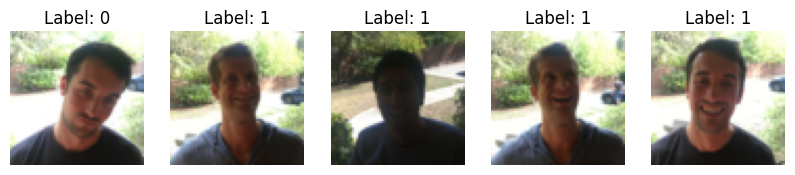

In [ ]:
# lihat beberapa data
### we use matplotlib to plot sample images for each class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(train_dataset["train_set_x"][i])
    plt.axis("off")
    plt.title("Label: " + str(train_dataset["train_set_y"][i]))

plt.show()

In [ ]:
# preprocessing
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.3),
    ]
)
# build model
### Model with data augmentaion pipeline ###
inputs = keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# learning rate scheduler
def step_decay(epoch):
    initial_lr = 0.001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop
    new_lr = initial_lr * (drop ** (epoch // epochs_drop))
    return new_lr

### call the method step_decay() using keras learningRateScheduler method
lr_scheduler_exponential_decay = LearningRateScheduler(step_decay)

In [ ]:
# simpan model dan compile
modelName = "happ-sadM.h5"
try:
    model = load_model(modelName)
    print("Loaded model from disk")
except:
    print("No model found, creating new one")


checkpoint = ModelCheckpoint('happ-sadM.h5', monitor='val_loss', save_best_only=True)
### we will now compile the model
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

No model found, creating new one


In [ ]:
# wandb callback
history = model.fit(train_x, train_y, epochs=40,
          validation_data=(val_x, val_y),
          callbacks=[checkpoint, lr_scheduler_exponential_decay, WandbCallback()])

Epoch 1/40
 6/15 [===========>..................] - ETA: 9s - loss: 0.6669 - accuracy: 0.6198 

15/15 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.6021

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.1s


15/15 [==============================] - 25s 2s/step - loss: 0.6635 - accuracy: 0.6021 - val_loss: 0.6343 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 2/40
15/15 [==============================] - ETA: 0s - loss: 0.6073 - accuracy: 0.6750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.1s


15/15 [==============================] - 20s 1s/step - loss: 0.6073 - accuracy: 0.6750 - val_loss: 0.5555 - val_accuracy: 0.6750 - lr: 0.0010
Epoch 3/40
15/15 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 6s 436ms/step - loss: 0.5348 - accuracy: 0.7188 - val_loss: 0.5346 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 4/40
15/15 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 8s 549ms/step - loss: 0.4211 - accuracy: 0.8062 - val_loss: 0.4159 - val_accuracy: 0.7583 - lr: 0.0010
Epoch 5/40
15/15 [==============================] - ETA: 0s - loss: 0.3187 - accuracy: 0.8625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 12s 869ms/step - loss: 0.3187 - accuracy: 0.8625 - val_loss: 0.3500 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 6/40
15/15 [==============================] - ETA: 0s - loss: 0.2719 - accuracy: 0.8896

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 13s 937ms/step - loss: 0.2719 - accuracy: 0.8896 - val_loss: 0.2838 - val_accuracy: 0.8500 - lr: 5.0000e-04
Epoch 7/40
15/15 [==============================] - 7s 517ms/step - loss: 0.2140 - accuracy: 0.9250 - val_loss: 0.3532 - val_accuracy: 0.8167 - lr: 5.0000e-04
Epoch 8/40
15/15 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 14s 999ms/step - loss: 0.1862 - accuracy: 0.9375 - val_loss: 0.2358 - val_accuracy: 0.8833 - lr: 5.0000e-04
Epoch 9/40
15/15 [==============================] - 7s 498ms/step - loss: 0.2045 - accuracy: 0.9146 - val_loss: 0.2749 - val_accuracy: 0.8750 - lr: 5.0000e-04
Epoch 10/40
15/15 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 14s 991ms/step - loss: 0.1541 - accuracy: 0.9542 - val_loss: 0.2042 - val_accuracy: 0.9083 - lr: 5.0000e-04
Epoch 11/40
15/15 [==============================] - 9s 615ms/step - loss: 0.1462 - accuracy: 0.9521 - val_loss: 0.2077 - val_accuracy: 0.9250 - lr: 2.5000e-04
Epoch 12/40
15/15 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 11s 764ms/step - loss: 0.1296 - accuracy: 0.9563 - val_loss: 0.1882 - val_accuracy: 0.9167 - lr: 2.5000e-04
Epoch 13/40
15/15 [==============================] - ETA: 0s - loss: 0.1273 - accuracy: 0.9521

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 11s 760ms/step - loss: 0.1273 - accuracy: 0.9521 - val_loss: 0.1845 - val_accuracy: 0.9167 - lr: 2.5000e-04
Epoch 14/40
15/15 [==============================] - 8s 582ms/step - loss: 0.1286 - accuracy: 0.9542 - val_loss: 0.1920 - val_accuracy: 0.9167 - lr: 2.5000e-04
Epoch 15/40
15/15 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9563

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 12s 814ms/step - loss: 0.1293 - accuracy: 0.9563 - val_loss: 0.1828 - val_accuracy: 0.9250 - lr: 2.5000e-04
Epoch 16/40
15/15 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9688

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 7s 483ms/step - loss: 0.1044 - accuracy: 0.9688 - val_loss: 0.1629 - val_accuracy: 0.9250 - lr: 1.2500e-04
Epoch 17/40
15/15 [==============================] - ETA: 0s - loss: 0.0992 - accuracy: 0.9708

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 8s 565ms/step - loss: 0.0992 - accuracy: 0.9708 - val_loss: 0.1610 - val_accuracy: 0.9250 - lr: 1.2500e-04
Epoch 18/40
15/15 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9708

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 11s 763ms/step - loss: 0.0987 - accuracy: 0.9708 - val_loss: 0.1531 - val_accuracy: 0.9250 - lr: 1.2500e-04
Epoch 19/40
15/15 [==============================] - 13s 932ms/step - loss: 0.0875 - accuracy: 0.9771 - val_loss: 0.1611 - val_accuracy: 0.9417 - lr: 1.2500e-04
Epoch 20/40
15/15 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9688

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 15s 1s/step - loss: 0.0993 - accuracy: 0.9688 - val_loss: 0.1461 - val_accuracy: 0.9250 - lr: 1.2500e-04
Epoch 21/40
15/15 [==============================] - 11s 791ms/step - loss: 0.0889 - accuracy: 0.9771 - val_loss: 0.1500 - val_accuracy: 0.9333 - lr: 6.2500e-05
Epoch 22/40
15/15 [==============================] - 12s 843ms/step - loss: 0.0889 - accuracy: 0.9750 - val_loss: 0.1509 - val_accuracy: 0.9417 - lr: 6.2500e-05
Epoch 23/40
15/15 [==============================] - 10s 707ms/step - loss: 0.0802 - accuracy: 0.9750 - val_loss: 0.1465 - val_accuracy: 0.9250 - lr: 6.2500e-05
Epoch 24/40
15/15 [==============================] - 13s 841ms/step - loss: 0.0783 - accuracy: 0.9750 - val_loss: 0.1467 - val_accuracy: 0.9333 - lr: 6.2500e-05
Epoch 25/40
15/15 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9750

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 12s 849ms/step - loss: 0.0841 - accuracy: 0.9750 - val_loss: 0.1445 - val_accuracy: 0.9250 - lr: 6.2500e-05
Epoch 26/40
15/15 [==============================] - 9s 653ms/step - loss: 0.0763 - accuracy: 0.9708 - val_loss: 0.1520 - val_accuracy: 0.9417 - lr: 3.1250e-05
Epoch 27/40
15/15 [==============================] - 7s 459ms/step - loss: 0.0796 - accuracy: 0.9750 - val_loss: 0.1462 - val_accuracy: 0.9417 - lr: 3.1250e-05
Epoch 28/40
15/15 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9875

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.0s


15/15 [==============================] - 9s 640ms/step - loss: 0.0700 - accuracy: 0.9875 - val_loss: 0.1417 - val_accuracy: 0.9333 - lr: 3.1250e-05
Epoch 29/40
15/15 [==============================] - 6s 444ms/step - loss: 0.0803 - accuracy: 0.9771 - val_loss: 0.1448 - val_accuracy: 0.9417 - lr: 3.1250e-05
Epoch 30/40
15/15 [==============================] - 7s 474ms/step - loss: 0.0812 - accuracy: 0.9771 - val_loss: 0.1468 - val_accuracy: 0.9417 - lr: 3.1250e-05
Epoch 31/40
15/15 [==============================] - 9s 620ms/step - loss: 0.0745 - accuracy: 0.9792 - val_loss: 0.1458 - val_accuracy: 0.9417 - lr: 1.5625e-05
Epoch 32/40
15/15 [==============================] - 6s 434ms/step - loss: 0.0698 - accuracy: 0.9812 - val_loss: 0.1465 - val_accuracy: 0.9417 - lr: 1.5625e-05
Epoch 33/40
15/15 [==============================] - 11s 796ms/step - loss: 0.0722 - accuracy: 0.9812 - val_loss: 0.1424 - val_accuracy: 0.9417 - lr: 1.5625e-05
Epoch 34/40
15/15 [==============================] 

wandb: Adding directory to artifact (/content/wandb/run-20240926_080832-8x92n708/files/model-best)... Done. 0.2s


15/15 [==============================] - 9s 619ms/step - loss: 0.0763 - accuracy: 0.9792 - val_loss: 0.1399 - val_accuracy: 0.9333 - lr: 1.5625e-05
Epoch 35/40
15/15 [==============================] - 6s 407ms/step - loss: 0.0875 - accuracy: 0.9729 - val_loss: 0.1400 - val_accuracy: 0.9333 - lr: 1.5625e-05
Epoch 36/40
15/15 [==============================] - 7s 504ms/step - loss: 0.0762 - accuracy: 0.9812 - val_loss: 0.1423 - val_accuracy: 0.9417 - lr: 7.8125e-06
Epoch 37/40
15/15 [==============================] - 6s 425ms/step - loss: 0.0864 - accuracy: 0.9729 - val_loss: 0.1414 - val_accuracy: 0.9417 - lr: 7.8125e-06
Epoch 38/40
15/15 [==============================] - 7s 475ms/step - loss: 0.0711 - accuracy: 0.9812 - val_loss: 0.1416 - val_accuracy: 0.9417 - lr: 7.8125e-06
Epoch 39/40
15/15 [==============================] - 6s 436ms/step - loss: 0.0721 - accuracy: 0.9792 - val_loss: 0.1410 - val_accuracy: 0.9417 - lr: 7.8125e-06
Epoch 40/40
15/15 [==============================] -

In [ ]:
# evaluasi
preds = model.predict(test_x)
preds = np.round(preds).astype(int).reshape(1, -1)[0]

fpr, tpr, thresholds = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

wandb.log({'accuracy': accuracy_score(test_y, preds), "roc_curve": wandb.Image(plt)})

5/5 [==============================] - 1s 90ms/step


<Figure size 640x480 with 0 Axes>

### contoh method (grid, random, bayesian)

####[grid](https://wandb.ai/wandb_fc/articles/reports/Running-Hyperparameter-Sweeps-to-Pick-the-Best-Model--Vmlldzo1NDQ0OTIy)

[codenya](https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Hyperparameter%20Sweeps%20with%20TF%202.0%20%26%20W%26B/Hyperparameter%20Sweeps%20(part%20I)%20with%20TF%202.0%20and%20W%26B.ipynb)

In [ ]:
!pip install tensorflow==2.8.0 wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstal

In [ ]:
!wandb login # edc9dadd05adc26eaf20d31d146e02dc73b5b9f3

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
from wandb.integration.keras import WandbCallback
import tensorflow as tf
import numpy as np
import wandb

In [ ]:
# Load the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Scale the pixel values of the images to
train_images = train_images / 255.0
test_images = test_images / 255.0

4431872/4422102 [==============================] - 1s 0us/step


In [ ]:
# kelas
labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [ ]:
# training step
def train():
    # Initialize wandb with a sample project name
    wandb.init(project="hyperparameter-sweeps-partI")

    (X_train, y_train) = train_images, train_labels
    (X_test, y_test) = test_images, test_labels

    # Specify the hyperparameter to be tuned along with
    # an initial value
    configs = {
        'layers': 128
    }

    # Specify the other hyperparameters to the configuration
    config = wandb.config
    config.epochs = 5

    # Add the config item (layers) to wandb
    if wandb.run:
        print(configs)
        wandb.config.update({k: v for k, v in configs.items()})
        # wandb.config.update({k: v for k, v in configs.items() if k not in dict(wandb.config.user_items())})
        # configs = dict(wandb.config.user_items())

    # Define the model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(wandb.config.layers, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=config.epochs, validation_data=(X_test, y_test),callbacks=[WandbCallback(labels=labels)])

In [ ]:
# konfigurasi sweep dg grid search
sweep_config = {
    'method': 'grid',
    'parameters': {
        'layers': {
            'values': [32, 64, 96, 128, 256]
        }
    }
}

In [ ]:
# inisialisasi sweep
sweep_id = wandb.sweep(sweep_config, project="hyperparameter-sweeps-partI")

Create sweep with ID: bpnwwxqc
Sweep URL: https://wandb.ai/latihanwandb-tracking/hyperparameter-sweeps-partI/sweeps/bpnwwxqc


In [ ]:
# agar tidak error ketika menjalankan agent sweep
import os
os.environ["WANDB_AGENT_DISABLE_FLAPPING"]="true"

In [ ]:
with tf.device('/device:GPU:0'):
  # jalankan hyperparameter tuning
  wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: oj2douss with config:
wandb: 	layers: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


{'layers': 128}
Epoch 1/5
   2/1875 [..............................] - ETA: 17:28 - loss: 2.4461 - accuracy: 0.0625

1863/1875 [============================>.] - ETA: 0s - loss: 0.5661 - accuracy: 0.8066

wandb: Adding directory to artifact (/content/wandb/run-20240926_230216-oj2douss/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 7s 4ms/step - loss: 0.5658 - accuracy: 0.8068 - val_loss: 0.4805 - val_accuracy: 0.8324
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.8533

wandb: Adding directory to artifact (/content/wandb/run-20240926_230216-oj2douss/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 7s 4ms/step - loss: 0.4162 - accuracy: 0.8533 - val_loss: 0.4321 - val_accuracy: 0.8474
Epoch 3/5
1871/1875 [============================>.] - ETA: 0s - loss: 0.3806 - accuracy: 0.8650

wandb: Adding directory to artifact (/content/wandb/run-20240926_230216-oj2douss/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 8s 4ms/step - loss: 0.3806 - accuracy: 0.8651 - val_loss: 0.4234 - val_accuracy: 0.8488
Epoch 4/5
1864/1875 [============================>.] - ETA: 0s - loss: 0.3589 - accuracy: 0.8707

wandb: Adding directory to artifact (/content/wandb/run-20240926_230216-oj2douss/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 6s 3ms/step - loss: 0.3590 - accuracy: 0.8706 - val_loss: 0.3952 - val_accuracy: 0.8593
Epoch 5/5
1857/1875 [============================>.] - ETA: 0s - loss: 0.3428 - accuracy: 0.8762

wandb: Adding directory to artifact (/content/wandb/run-20240926_230216-oj2douss/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 7s 4ms/step - loss: 0.3427 - accuracy: 0.8763 - val_loss: 0.3840 - val_accuracy: 0.8649


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▃▂▂▁
val_accuracy,▁▄▅▇█
val_loss,█▄▄▂▁
accuracy,0.87625
best_epoch,4
best_val_loss,0.38403
epoch,4
loss,0.34269
val_accuracy,0.8649


wandb: Agent Starting Run: vs5qttfr with config:
wandb: 	layers: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).


{'layers': 128}
Epoch 1/5
1850/1875 [============================>.] - ETA: 0s - loss: 0.5222 - accuracy: 0.8188

wandb: Adding directory to artifact (/content/wandb/run-20240926_230312-vs5qttfr/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 8s 4ms/step - loss: 0.5205 - accuracy: 0.8193 - val_loss: 0.4312 - val_accuracy: 0.8461
Epoch 2/5
1870/1875 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8596

wandb: Adding directory to artifact (/content/wandb/run-20240926_230312-vs5qttfr/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 9s 5ms/step - loss: 0.3911 - accuracy: 0.8595 - val_loss: 0.3929 - val_accuracy: 0.8602
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3522 - accuracy: 0.8734 - val_loss: 0.3973 - val_accuracy: 0.8588
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3296 - accuracy: 0.8798 - val_loss: 0.4048 - val_accuracy: 0.8484
Epoch 5/5
1848/1875 [============================>.] - ETA: 0s - loss: 0.3113 - accuracy: 0.8855

wandb: Adding directory to artifact (/content/wandb/run-20240926_230312-vs5qttfr/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 7s 3ms/step - loss: 0.3111 - accuracy: 0.8855 - val_loss: 0.3672 - val_accuracy: 0.8703


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▅▂█
val_loss,█▄▄▅▁
accuracy,0.88545
best_epoch,4
best_val_loss,0.36721
epoch,4
loss,0.31113
val_accuracy,0.8703


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 75hg8j97 with config:
wandb: 	layers: 96
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).


{'layers': 128}
Epoch 1/5
1848/1875 [============================>.] - ETA: 0s - loss: 0.5134 - accuracy: 0.8201

wandb: Adding directory to artifact (/content/wandb/run-20240926_230420-75hg8j97/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 10s 5ms/step - loss: 0.5126 - accuracy: 0.8204 - val_loss: 0.4587 - val_accuracy: 0.8409
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - loss: 0.3871 - accuracy: 0.8602

wandb: Adding directory to artifact (/content/wandb/run-20240926_230420-75hg8j97/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 8s 4ms/step - loss: 0.3871 - accuracy: 0.8602 - val_loss: 0.4137 - val_accuracy: 0.8485
Epoch 3/5
1855/1875 [============================>.] - ETA: 0s - loss: 0.3484 - accuracy: 0.8741

wandb: Adding directory to artifact (/content/wandb/run-20240926_230420-75hg8j97/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 8s 4ms/step - loss: 0.3480 - accuracy: 0.8741 - val_loss: 0.3889 - val_accuracy: 0.8590
Epoch 4/5
1869/1875 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8820

wandb: Adding directory to artifact (/content/wandb/run-20240926_230420-75hg8j97/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 7s 4ms/step - loss: 0.3228 - accuracy: 0.8820 - val_loss: 0.3583 - val_accuracy: 0.8708
Epoch 5/5
1857/1875 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.8884

wandb: Adding directory to artifact (/content/wandb/run-20240926_230420-75hg8j97/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 7s 4ms/step - loss: 0.3047 - accuracy: 0.8882 - val_loss: 0.3533 - val_accuracy: 0.8719


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▃▅██
val_loss,█▅▃▁▁
accuracy,0.8882
best_epoch,4
best_val_loss,0.35328
epoch,4
loss,0.30472
val_accuracy,0.8719


wandb: Agent Starting Run: zuefkcfs with config:
wandb: 	layers: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).


{'layers': 128}
Epoch 1/5
   2/1875 [..............................] - ETA: 12:26 - loss: 2.3830 - accuracy: 0.1719

1851/1875 [============================>.] - ETA: 0s - loss: 0.4980 - accuracy: 0.8244

wandb: Adding directory to artifact (/content/wandb/run-20240926_230524-zuefkcfs/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 9s 5ms/step - loss: 0.4969 - accuracy: 0.8249 - val_loss: 0.4534 - val_accuracy: 0.8349
Epoch 2/5
1865/1875 [============================>.] - ETA: 0s - loss: 0.3772 - accuracy: 0.8628

wandb: Adding directory to artifact (/content/wandb/run-20240926_230524-zuefkcfs/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 9s 5ms/step - loss: 0.3771 - accuracy: 0.8630 - val_loss: 0.3917 - val_accuracy: 0.8553
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8771

wandb: Adding directory to artifact (/content/wandb/run-20240926_230524-zuefkcfs/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 8s 4ms/step - loss: 0.3372 - accuracy: 0.8771 - val_loss: 0.3805 - val_accuracy: 0.8627
Epoch 4/5
1850/1875 [============================>.] - ETA: 0s - loss: 0.3118 - accuracy: 0.8861

wandb: Adding directory to artifact (/content/wandb/run-20240926_230524-zuefkcfs/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 10s 5ms/step - loss: 0.3119 - accuracy: 0.8861 - val_loss: 0.3663 - val_accuracy: 0.8638
Epoch 5/5
1874/1875 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.8909

wandb: Adding directory to artifact (/content/wandb/run-20240926_230524-zuefkcfs/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 10s 5ms/step - loss: 0.2942 - accuracy: 0.8909 - val_loss: 0.3360 - val_accuracy: 0.8784


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▄▅▆█
val_loss,█▄▄▃▁
accuracy,0.89088
best_epoch,4
best_val_loss,0.33599
epoch,4
loss,0.29417
val_accuracy,0.8784


wandb: Agent Starting Run: j35xajd0 with config:
wandb: 	layers: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).


{'layers': 128}
Epoch 1/5
1858/1875 [============================>.] - ETA: 0s - loss: 0.4849 - accuracy: 0.8286

wandb: Adding directory to artifact (/content/wandb/run-20240926_230633-j35xajd0/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 12s 6ms/step - loss: 0.4837 - accuracy: 0.8291 - val_loss: 0.4616 - val_accuracy: 0.8374
Epoch 2/5
1874/1875 [============================>.] - ETA: 0s - loss: 0.3607 - accuracy: 0.8699

wandb: Adding directory to artifact (/content/wandb/run-20240926_230633-j35xajd0/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 10s 6ms/step - loss: 0.3607 - accuracy: 0.8699 - val_loss: 0.3629 - val_accuracy: 0.8690
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3244 - accuracy: 0.8801 - val_loss: 0.3636 - val_accuracy: 0.8672
Epoch 4/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3013 - accuracy: 0.8880 - val_loss: 0.3815 - val_accuracy: 0.8612
Epoch 5/5
1870/1875 [============================>.] - ETA: 0s - loss: 0.2834 - accuracy: 0.8945

wandb: Adding directory to artifact (/content/wandb/run-20240926_230633-j35xajd0/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 12s 6ms/step - loss: 0.2834 - accuracy: 0.8944 - val_loss: 0.3543 - val_accuracy: 0.8748


accuracy,▁▅▆▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▇▇▅█
val_loss,█▂▂▃▁
accuracy,0.8944
best_epoch,4
best_val_loss,0.3543
epoch,4
loss,0.28337
val_accuracy,0.8748


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


#### [bayesian](https://colab.research.google.com/drive/1hAvJgduKmYcXs8pF4JTu_kLGZxTrAZfo)

In [ ]:
# Install wandb (ignore if already done)
!pip install wandb tensorflow==2.13

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling 

In [ ]:
# Authorize wandb
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Imports
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from wandb.integration.keras import WandbCallback
import tensorflow as tf
import numpy as np
import wandb
import time

In [ ]:
# Fix the random generator seeds for better reproducibility
tf.random.set_seed(67)
np.random.seed(67)

In [ ]:
# Load the dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Scale the pixel values of the images to
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape the pixel values so that they are compatible with
# the conv layers
train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Specify the labels of FashionMNIST dataset, it would
# be needed later 😉
labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [ ]:
METHOD = 'bayes' # change to 'random' or 'bayes' when necessary and rerun

In [ ]:
def train():
    # Prepare data tuples
    (X_train, y_train) = train_images, train_labels
    (X_test, y_test) = test_images, test_labels

    # Default values for hyper-parameters we're going to sweep over
    configs = {
        'layers': 128,
        'batch_size': 64,
        'epochs': 5,
        'method': METHOD
    }

    # Initilize a new wandb run
    wandb.init(project='hyperparameter-sweeps-comparison', config=configs)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Define the model
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3, 3), activation='relu'),
        GlobalAveragePooling2D(),
        Dense(config.layers, activation=tf.nn.relu),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train,
             epochs=config.epochs,
             batch_size=config.batch_size,
             validation_data=(X_test, y_test),
             callbacks=[WandbCallback(data_type="image",
                validation_data=(X_test, y_test), labels=labels)])

In [ ]:
# A function to specify the tuning configuration, it would also
# return us a sweep id (required for running the sweep)
def get_sweep_id(method):
    sweep_config = {
        'method': method,
        'metric': {
          'name': 'accuracy',
          'goal': 'maximize'
        },
        'parameters': {
            'layers': {
                'values': [32, 64, 96, 128, 256]
            },
            'batch_size': {
                'values': [32, 64, 96, 128]
            },
            'epochs': {
                'values': [5, 10, 15]
            }
        }
    }
    sweep_id = wandb.sweep(sweep_config, project='hyperparameter-sweeps-comparison')

    return sweep_id

In [ ]:
# Create a sweep for *grid* search
sweep_id = get_sweep_id('grid')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: usjgq36a
Sweep URL: https://wandb.ai/latihanwandb-tracking/hyperparameter-sweeps-comparison/sweeps/usjgq36a


In [ ]:
# agar tidak error ketika menjalankan agent sweep
import os
os.environ["WANDB_AGENT_DISABLE_FLAPPING"]="true"

In [ ]:
# Run the sweep
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: 2bw8ixso with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	layers: 32
wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/5
2/2 [==============================] - 0s 158ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_094613-2bw8ixso/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 153s 80ms/step - loss: 0.6750 - accuracy: 0.7486 - val_loss: 0.5335 - val_accuracy: 0.8027
Epoch 2/5
2/2 [==============================] - 0s 79ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_094613-2bw8ixso/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 74ms/step - loss: 0.4412 - accuracy: 0.8400 - val_loss: 0.4281 - val_accuracy: 0.8445
Epoch 3/5
2/2 [==============================] - 0s 13ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_094613-2bw8ixso/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 168s 89ms/step - loss: 0.3668 - accuracy: 0.8656 - val_loss: 0.3719 - val_accuracy: 0.8674
Epoch 4/5
2/2 [==============================] - 1s 686ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_094613-2bw8ixso/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 131s 70ms/step - loss: 0.3259 - accuracy: 0.8823 - val_loss: 0.3568 - val_accuracy: 0.8742
Epoch 5/5
2/2 [==============================] - 0s 16ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_094613-2bw8ixso/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 126s 67ms/step - loss: 0.2953 - accuracy: 0.8927 - val_loss: 0.3185 - val_accuracy: 0.8863


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
accuracy,0.89265
best_epoch,4
best_val_loss,0.31846
epoch,4
loss,0.29527
val_accuracy,0.8863


wandb: Agent Starting Run: ipti013x with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	layers: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
   5/1875 [..............................] - ETA: 4:20 - loss: 2.2982 - accuracy: 0.1500

2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_095854-ipti013x/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 146s 77ms/step - loss: 0.6696 - accuracy: 0.7493 - val_loss: 0.5180 - val_accuracy: 0.8079
Epoch 2/5
2/2 [==============================] - 1s 614ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_095854-ipti013x/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 145s 77ms/step - loss: 0.4227 - accuracy: 0.8435 - val_loss: 0.4010 - val_accuracy: 0.8584
Epoch 3/5
2/2 [==============================] - 0s 12ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_095854-ipti013x/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 135s 72ms/step - loss: 0.3489 - accuracy: 0.8713 - val_loss: 0.3566 - val_accuracy: 0.8701
Epoch 4/5
2/2 [==============================] - 0s 9ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_095854-ipti013x/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 130s 69ms/step - loss: 0.3098 - accuracy: 0.8860 - val_loss: 0.3195 - val_accuracy: 0.8846
Epoch 5/5
2/2 [==============================] - 1s 780ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_095854-ipti013x/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 132s 70ms/step - loss: 0.2830 - accuracy: 0.8957 - val_loss: 0.2959 - val_accuracy: 0.8920


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.89572
best_epoch,4
best_val_loss,0.29586
epoch,4
loss,0.28305
val_accuracy,0.892


wandb: Agent Starting Run: 5h8m5z0t with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	layers: 96
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
2/2 [==============================] - 0s 143ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_101041-5h8m5z0t/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 153s 80ms/step - loss: 0.6739 - accuracy: 0.7456 - val_loss: 0.5344 - val_accuracy: 0.8008
Epoch 2/5
2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_101041-5h8m5z0t/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.4208 - accuracy: 0.8462 - val_loss: 0.4202 - val_accuracy: 0.8491
Epoch 3/5
2/2 [==============================] - 1s 571ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_101041-5h8m5z0t/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.3467 - accuracy: 0.8727 - val_loss: 0.3546 - val_accuracy: 0.8707
Epoch 4/5
2/2 [==============================] - 0s 270ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_101041-5h8m5z0t/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.3071 - accuracy: 0.8874 - val_loss: 0.3266 - val_accuracy: 0.8813
Epoch 5/5
2/2 [==============================] - 1s 703ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_101041-5h8m5z0t/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2792 - accuracy: 0.8982 - val_loss: 0.3022 - val_accuracy: 0.8873


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
accuracy,0.8982
best_epoch,4
best_val_loss,0.30221
epoch,4
loss,0.27919
val_accuracy,0.8873


wandb: Agent Starting Run: abaw7qvw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	layers: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
   5/1875 [..............................] - ETA: 2:35 - loss: 2.3009 - accuracy: 0.0938

2/2 [==============================] - 0s 10ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_102242-abaw7qvw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 142s 74ms/step - loss: 0.6564 - accuracy: 0.7520 - val_loss: 0.5171 - val_accuracy: 0.8053
Epoch 2/5
2/2 [==============================] - 0s 8ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240926_102242-abaw7qvw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 145s 77ms/step - loss: 0.4204 - accuracy: 0.8449 - val_loss: 0.4074 - val_accuracy: 0.8519
Epoch 3/5
2/2 [==============================] - 0s 13ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_102242-abaw7qvw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 134s 71ms/step - loss: 0.3441 - accuracy: 0.8738 - val_loss: 0.3466 - val_accuracy: 0.8719
Epoch 4/5
2/2 [==============================] - 0s 415ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_102242-abaw7qvw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 131s 70ms/step - loss: 0.3056 - accuracy: 0.8875 - val_loss: 0.3311 - val_accuracy: 0.8783
Epoch 5/5
2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_102242-abaw7qvw/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 142s 76ms/step - loss: 0.2759 - accuracy: 0.8990 - val_loss: 0.3015 - val_accuracy: 0.8929


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▂▂▁
accuracy,0.89898
best_epoch,4
best_val_loss,0.30148
epoch,4
loss,0.2759
val_accuracy,0.8929


wandb: Agent Starting Run: zblyze7w with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	layers: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
2/2 [==============================] - 0s 150ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_103438-zblyze7w/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 73ms/step - loss: 0.6576 - accuracy: 0.7473 - val_loss: 0.5144 - val_accuracy: 0.8050
Epoch 2/5
2/2 [==============================] - 1s 632ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_103438-zblyze7w/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.4133 - accuracy: 0.8486 - val_loss: 0.4034 - val_accuracy: 0.8542
Epoch 3/5
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_103438-zblyze7w/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.3384 - accuracy: 0.8758 - val_loss: 0.3486 - val_accuracy: 0.8718
Epoch 4/5
2/2 [==============================] - 1s 601ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_103438-zblyze7w/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2981 - accuracy: 0.8896 - val_loss: 0.3306 - val_accuracy: 0.8794
Epoch 5/5
2/2 [==============================] - 0s 203ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_103438-zblyze7w/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 124s 66ms/step - loss: 0.2691 - accuracy: 0.9014 - val_loss: 0.2949 - val_accuracy: 0.8945


accuracy,▁▆▇▇█
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
accuracy,0.90145
best_epoch,4
best_val_loss,0.29494
epoch,4
loss,0.26913
val_accuracy,0.8945


wandb: Agent Starting Run: dtyv4130 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	layers: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
2/2 [==============================] - 0s 13ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 75ms/step - loss: 0.6885 - accuracy: 0.7415 - val_loss: 0.5386 - val_accuracy: 0.8010
Epoch 2/10
2/2 [==============================] - 1s 529ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.4546 - accuracy: 0.8340 - val_loss: 0.4439 - val_accuracy: 0.8415
Epoch 3/10
2/2 [==============================] - 0s 15ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 142s 76ms/step - loss: 0.3800 - accuracy: 0.8617 - val_loss: 0.3879 - val_accuracy: 0.8607
Epoch 4/10
2/2 [==============================] - 1s 580ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 130s 69ms/step - loss: 0.3385 - accuracy: 0.8773 - val_loss: 0.3687 - val_accuracy: 0.8651
Epoch 5/10
2/2 [==============================] - 0s 248ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 134s 72ms/step - loss: 0.3055 - accuracy: 0.8883 - val_loss: 0.3243 - val_accuracy: 0.8861
Epoch 6/10
1875/1875 [==============================] - 133s 71ms/step - loss: 0.2825 - accuracy: 0.8973 - val_loss: 0.3316 - val_accuracy: 0.8754
Epoch 7/10
2/2 [==============================] - 0s 13ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 74ms/step - loss: 0.2635 - accuracy: 0.9040 - val_loss: 0.3023 - val_accuracy: 0.8923
Epoch 8/10
2/2 [==============================] - 0s 259ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 130s 69ms/step - loss: 0.2484 - accuracy: 0.9089 - val_loss: 0.3001 - val_accuracy: 0.8925
Epoch 9/10
2/2 [==============================] - 1s 559ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_104618-dtyv4130/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 145s 77ms/step - loss: 0.2366 - accuracy: 0.9140 - val_loss: 0.2837 - val_accuracy: 0.8979
Epoch 10/10
1875/1875 [==============================] - 130s 69ms/step - loss: 0.2262 - accuracy: 0.9168 - val_loss: 0.3048 - val_accuracy: 0.8910


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▅▆▇▆████
val_loss,█▅▄▃▂▂▂▁▁▂
accuracy,0.91675
best_epoch,8
best_val_loss,0.28369
epoch,9
loss,0.22619
val_accuracy,0.891


wandb: Agent Starting Run: vg3ii0ft with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	layers: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
   6/1875 [..............................] - ETA: 8:06 - loss: 2.2977 - accuracy: 0.0938

2/2 [==============================] - 0s 166ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 75ms/step - loss: 0.6616 - accuracy: 0.7515 - val_loss: 0.5439 - val_accuracy: 0.7939
Epoch 2/10
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.4334 - accuracy: 0.8407 - val_loss: 0.4264 - val_accuracy: 0.8440
Epoch 3/10
2/2 [==============================] - 0s 38ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.3633 - accuracy: 0.8669 - val_loss: 0.3660 - val_accuracy: 0.8687
Epoch 4/10
2/2 [==============================] - 0s 249ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 73ms/step - loss: 0.3223 - accuracy: 0.8825 - val_loss: 0.3470 - val_accuracy: 0.8744
Epoch 5/10
2/2 [==============================] - 0s 203ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 144s 77ms/step - loss: 0.2911 - accuracy: 0.8934 - val_loss: 0.3025 - val_accuracy: 0.8909
Epoch 6/10
2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 131s 70ms/step - loss: 0.2697 - accuracy: 0.9005 - val_loss: 0.3013 - val_accuracy: 0.8892
Epoch 7/10
2/2 [==============================] - 0s 265ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.2513 - accuracy: 0.9078 - val_loss: 0.2901 - val_accuracy: 0.8961
Epoch 8/10
2/2 [==============================] - 1s 467ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 140s 74ms/step - loss: 0.2360 - accuracy: 0.9139 - val_loss: 0.2727 - val_accuracy: 0.8988
Epoch 9/10
2/2 [==============================] - 0s 278ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_110921-vg3ii0ft/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.2264 - accuracy: 0.9169 - val_loss: 0.2717 - val_accuracy: 0.9017
Epoch 10/10
1875/1875 [==============================] - 136s 73ms/step - loss: 0.2145 - accuracy: 0.9208 - val_loss: 0.3030 - val_accuracy: 0.8915


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇███▇
val_loss,█▅▃▃▂▂▁▁▁▂
accuracy,0.92082
best_epoch,8
best_val_loss,0.27169
epoch,9
loss,0.21452
val_accuracy,0.8915


wandb: Agent Starting Run: 3jteghyb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	layers: 96
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
   6/1875 [..............................] - ETA: 2:21 - loss: 2.2984 - accuracy: 0.0885

2/2 [==============================] - 0s 14ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 73ms/step - loss: 0.6618 - accuracy: 0.7503 - val_loss: 0.5044 - val_accuracy: 0.8143
Epoch 2/10
2/2 [==============================] - 0s 14ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.4218 - accuracy: 0.8461 - val_loss: 0.4078 - val_accuracy: 0.8559
Epoch 3/10
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.3465 - accuracy: 0.8739 - val_loss: 0.3487 - val_accuracy: 0.8757
Epoch 4/10
2/2 [==============================] - 1s 626ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.3087 - accuracy: 0.8856 - val_loss: 0.3276 - val_accuracy: 0.8807
Epoch 5/10
2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.2797 - accuracy: 0.8970 - val_loss: 0.3003 - val_accuracy: 0.8928
Epoch 6/10
2/2 [==============================] - 0s 15ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 131s 70ms/step - loss: 0.2600 - accuracy: 0.9047 - val_loss: 0.2848 - val_accuracy: 0.8942
Epoch 7/10
1875/1875 [==============================] - 132s 71ms/step - loss: 0.2428 - accuracy: 0.9104 - val_loss: 0.3017 - val_accuracy: 0.8946
Epoch 8/10
1875/1875 [==============================] - 136s 73ms/step - loss: 0.2290 - accuracy: 0.9157 - val_loss: 0.2864 - val_accuracy: 0.8976
Epoch 9/10
2/2 [==============================] - 0s 16ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_113239-3jteghyb/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 132s 70ms/step - loss: 0.2162 - accuracy: 0.9197 - val_loss: 0.2631 - val_accuracy: 0.9015
Epoch 10/10
1875/1875 [==============================] - 148s 79ms/step - loss: 0.2049 - accuracy: 0.9239 - val_loss: 0.2837 - val_accuracy: 0.8985


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▃▃▂▂▂▂▁▂
accuracy,0.92393
best_epoch,8
best_val_loss,0.26313
epoch,9
loss,0.20495
val_accuracy,0.8985


wandb: Agent Starting Run: d66lfzcg with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	layers: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
   6/1875 [..............................] - ETA: 7:38 - loss: 2.2993 - accuracy: 0.1094 

2/2 [==============================] - 1s 527ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 135s 71ms/step - loss: 0.6727 - accuracy: 0.7472 - val_loss: 0.5297 - val_accuracy: 0.8024
Epoch 2/10
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 76ms/step - loss: 0.4268 - accuracy: 0.8421 - val_loss: 0.4113 - val_accuracy: 0.8533
Epoch 3/10
2/2 [==============================] - 0s 119ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 128s 68ms/step - loss: 0.3480 - accuracy: 0.8715 - val_loss: 0.3546 - val_accuracy: 0.8714
Epoch 4/10
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.3080 - accuracy: 0.8864 - val_loss: 0.3327 - val_accuracy: 0.8773
Epoch 5/10
2/2 [==============================] - 0s 181ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 74ms/step - loss: 0.2787 - accuracy: 0.8976 - val_loss: 0.2979 - val_accuracy: 0.8919
Epoch 6/10
2/2 [==============================] - 0s 275ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 76ms/step - loss: 0.2597 - accuracy: 0.9029 - val_loss: 0.2838 - val_accuracy: 0.8980
Epoch 7/10
1875/1875 [==============================] - 127s 68ms/step - loss: 0.2415 - accuracy: 0.9104 - val_loss: 0.2962 - val_accuracy: 0.8920
Epoch 8/10
2/2 [==============================] - 0s 26ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 140s 75ms/step - loss: 0.2266 - accuracy: 0.9156 - val_loss: 0.2658 - val_accuracy: 0.9066
Epoch 9/10
2/2 [==============================] - 1s 464ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_115549-d66lfzcg/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.2138 - accuracy: 0.9208 - val_loss: 0.2569 - val_accuracy: 0.9058
Epoch 10/10
1875/1875 [==============================] - 137s 73ms/step - loss: 0.2018 - accuracy: 0.9250 - val_loss: 0.2789 - val_accuracy: 0.9012


accuracy,▁▅▆▆▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▂
accuracy,0.925
best_epoch,8
best_val_loss,0.25688
epoch,9
loss,0.20179
val_accuracy,0.9012


wandb: Agent Starting Run: 8z1vm7g6 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	layers: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/10
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 142s 75ms/step - loss: 0.6678 - accuracy: 0.7448 - val_loss: 0.5290 - val_accuracy: 0.8030
Epoch 2/10
2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.4217 - accuracy: 0.8452 - val_loss: 0.4247 - val_accuracy: 0.8454
Epoch 3/10
2/2 [==============================] - 0s 144ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.3471 - accuracy: 0.8714 - val_loss: 0.3508 - val_accuracy: 0.8734
Epoch 4/10
2/2 [==============================] - 1s 545ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 74ms/step - loss: 0.3062 - accuracy: 0.8875 - val_loss: 0.3392 - val_accuracy: 0.8765
Epoch 5/10
2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 134s 71ms/step - loss: 0.2763 - accuracy: 0.8979 - val_loss: 0.2964 - val_accuracy: 0.8917
Epoch 6/10
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 74ms/step - loss: 0.2558 - accuracy: 0.9046 - val_loss: 0.2936 - val_accuracy: 0.8885
Epoch 7/10
2/2 [==============================] - 0s 7ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 142s 76ms/step - loss: 0.2376 - accuracy: 0.9125 - val_loss: 0.2824 - val_accuracy: 0.8983
Epoch 8/10
2/2 [==============================] - 0s 121ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 131s 70ms/step - loss: 0.2242 - accuracy: 0.9168 - val_loss: 0.2752 - val_accuracy: 0.8994
Epoch 9/10
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_121859-8z1vm7g6/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2115 - accuracy: 0.9217 - val_loss: 0.2634 - val_accuracy: 0.9027
Epoch 10/10
1875/1875 [==============================] - 142s 76ms/step - loss: 0.2004 - accuracy: 0.9258 - val_loss: 0.2742 - val_accuracy: 0.9023


accuracy,▁▅▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
accuracy,0.92577
best_epoch,8
best_val_loss,0.26344
epoch,9
loss,0.20041
val_accuracy,0.9023


wandb: Agent Starting Run: iot80ayh with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	layers: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/15
   6/1875 [..............................] - ETA: 4:26 - loss: 2.2900 - accuracy: 0.0833

2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 74ms/step - loss: 0.6736 - accuracy: 0.7493 - val_loss: 0.5462 - val_accuracy: 0.7963
Epoch 2/15
2/2 [==============================] - 0s 203ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.4384 - accuracy: 0.8393 - val_loss: 0.4149 - val_accuracy: 0.8503
Epoch 3/15
2/2 [==============================] - 0s 70ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 74ms/step - loss: 0.3644 - accuracy: 0.8661 - val_loss: 0.3683 - val_accuracy: 0.8663
Epoch 4/15
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 144s 77ms/step - loss: 0.3234 - accuracy: 0.8827 - val_loss: 0.3389 - val_accuracy: 0.8788
Epoch 5/15
2/2 [==============================] - 0s 56ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 73ms/step - loss: 0.2936 - accuracy: 0.8923 - val_loss: 0.3067 - val_accuracy: 0.8904
Epoch 6/15
1875/1875 [==============================] - 130s 69ms/step - loss: 0.2738 - accuracy: 0.8995 - val_loss: 0.3122 - val_accuracy: 0.8849
Epoch 7/15
2/2 [==============================] - 0s 24ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 140s 75ms/step - loss: 0.2557 - accuracy: 0.9049 - val_loss: 0.3032 - val_accuracy: 0.8911
Epoch 8/15
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 72ms/step - loss: 0.2407 - accuracy: 0.9112 - val_loss: 0.2786 - val_accuracy: 0.8976
Epoch 9/15
1875/1875 [==============================] - 136s 73ms/step - loss: 0.2287 - accuracy: 0.9164 - val_loss: 0.2837 - val_accuracy: 0.8934
Epoch 10/15
1875/1875 [==============================] - 131s 70ms/step - loss: 0.2181 - accuracy: 0.9191 - val_loss: 0.2946 - val_accuracy: 0.8939
Epoch 11/15
2/2 [==============================] - 0s 143ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_124224-iot80ayh/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.2060 - accuracy: 0.9235 - val_loss: 0.2623 - val_accuracy: 0.9052
Epoch 12/15
1875/1875 [==============================] - 133s 71ms/step - loss: 0.1949 - accuracy: 0.9283 - val_loss: 0.2647 - val_accuracy: 0.9039
Epoch 13/15
1875/1875 [==============================] - 134s 71ms/step - loss: 0.1884 - accuracy: 0.9290 - val_loss: 0.2757 - val_accuracy: 0.9032
Epoch 14/15
1875/1875 [==============================] - 127s 68ms/step - loss: 0.1782 - accuracy: 0.9342 - val_loss: 0.2642 - val_accuracy: 0.9045
Epoch 15/15
1875/1875 [==============================] - 137s 73ms/step - loss: 0.1697 - accuracy: 0.9373 - val_loss: 0.2719 - val_accuracy: 0.9060


accuracy,▁▄▅▆▆▇▇▇▇▇▇████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇▇█████
val_loss,█▅▄▃▂▂▂▁▂▂▁▁▁▁▁
accuracy,0.9373
best_epoch,10
best_val_loss,0.26229
epoch,14
loss,0.16967
val_accuracy,0.906


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p5kgptdv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	layers: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/15
   6/1875 [..............................] - ETA: 5:02 - loss: 2.2922 - accuracy: 0.0781

2/2 [==============================] - 1s 801ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 155s 81ms/step - loss: 0.6600 - accuracy: 0.7502 - val_loss: 0.5114 - val_accuracy: 0.8163
Epoch 2/15
2/2 [==============================] - 0s 192ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.4342 - accuracy: 0.8404 - val_loss: 0.4376 - val_accuracy: 0.8394
Epoch 3/15
2/2 [==============================] - 0s 162ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.3615 - accuracy: 0.8668 - val_loss: 0.3724 - val_accuracy: 0.8637
Epoch 4/15
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 139s 74ms/step - loss: 0.3191 - accuracy: 0.8831 - val_loss: 0.3441 - val_accuracy: 0.8746
Epoch 5/15
2/2 [==============================] - 0s 191ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 135s 72ms/step - loss: 0.2877 - accuracy: 0.8944 - val_loss: 0.3098 - val_accuracy: 0.8892
Epoch 6/15
2/2 [==============================] - 1s 518ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 144s 77ms/step - loss: 0.2667 - accuracy: 0.9023 - val_loss: 0.2909 - val_accuracy: 0.8917
Epoch 7/15
2/2 [==============================] - 1s 766ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 76ms/step - loss: 0.2496 - accuracy: 0.9074 - val_loss: 0.2834 - val_accuracy: 0.8966
Epoch 8/15
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 144s 77ms/step - loss: 0.2366 - accuracy: 0.9127 - val_loss: 0.2792 - val_accuracy: 0.8986
Epoch 9/15
2/2 [==============================] - 0s 7ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2244 - accuracy: 0.9166 - val_loss: 0.2668 - val_accuracy: 0.9021
Epoch 10/15
1875/1875 [==============================] - 142s 76ms/step - loss: 0.2130 - accuracy: 0.9221 - val_loss: 0.2763 - val_accuracy: 0.8987
Epoch 11/15
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_131714-p5kgptdv/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.2038 - accuracy: 0.9238 - val_loss: 0.2542 - val_accuracy: 0.9086
Epoch 12/15
1875/1875 [==============================] - 142s 76ms/step - loss: 0.1930 - accuracy: 0.9274 - val_loss: 0.2685 - val_accuracy: 0.9040
Epoch 13/15
1875/1875 [==============================] - 135s 72ms/step - loss: 0.1853 - accuracy: 0.9304 - val_loss: 0.2838 - val_accuracy: 0.8985
Epoch 14/15
1875/1875 [==============================] - 134s 71ms/step - loss: 0.1755 - accuracy: 0.9347 - val_loss: 0.2813 - val_accuracy: 0.9020
Epoch 15/15
1875/1875 [==============================] - 137s 73ms/step - loss: 0.1685 - accuracy: 0.9374 - val_loss: 0.2607 - val_accuracy: 0.9112


accuracy,▁▄▅▆▆▇▇▇▇▇▇████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▄▅▆▇▇▇▇▇█▇▇▇█
val_loss,█▆▄▃▃▂▂▂▁▂▁▁▂▂▁
accuracy,0.93743
best_epoch,10
best_val_loss,0.2542
epoch,14
loss,0.1685
val_accuracy,0.9112


wandb: Agent Starting Run: lf4pmg16 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	layers: 96
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/15
   6/1875 [..............................] - ETA: 6:43 - loss: 2.2957 - accuracy: 0.1250

2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 72ms/step - loss: 0.6731 - accuracy: 0.7454 - val_loss: 0.5321 - val_accuracy: 0.8071
Epoch 2/15
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 130s 69ms/step - loss: 0.4323 - accuracy: 0.8417 - val_loss: 0.4162 - val_accuracy: 0.8514
Epoch 3/15
2/2 [==============================] - 0s 395ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 136s 73ms/step - loss: 0.3611 - accuracy: 0.8684 - val_loss: 0.3599 - val_accuracy: 0.8720
Epoch 4/15
2/2 [==============================] - 0s 13ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.3200 - accuracy: 0.8837 - val_loss: 0.3415 - val_accuracy: 0.8758
Epoch 5/15
2/2 [==============================] - 1s 577ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2909 - accuracy: 0.8937 - val_loss: 0.3020 - val_accuracy: 0.8930
Epoch 6/15
1875/1875 [==============================] - 136s 73ms/step - loss: 0.2696 - accuracy: 0.9013 - val_loss: 0.3115 - val_accuracy: 0.8833
Epoch 7/15
2/2 [==============================] - 0s 359ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 140s 75ms/step - loss: 0.2506 - accuracy: 0.9086 - val_loss: 0.2938 - val_accuracy: 0.8949
Epoch 8/15
2/2 [==============================] - 0s 172ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 133s 71ms/step - loss: 0.2348 - accuracy: 0.9135 - val_loss: 0.2773 - val_accuracy: 0.9027
Epoch 9/15
2/2 [==============================] - 1s 637ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.2230 - accuracy: 0.9179 - val_loss: 0.2634 - val_accuracy: 0.9016
Epoch 10/15
1875/1875 [==============================] - 141s 75ms/step - loss: 0.2105 - accuracy: 0.9225 - val_loss: 0.2821 - val_accuracy: 0.8986
Epoch 11/15
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_135257-lf4pmg16/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 135s 72ms/step - loss: 0.1988 - accuracy: 0.9272 - val_loss: 0.2583 - val_accuracy: 0.9088
Epoch 12/15
1875/1875 [==============================] - 133s 71ms/step - loss: 0.1907 - accuracy: 0.9286 - val_loss: 0.2754 - val_accuracy: 0.9047
Epoch 13/15
1875/1875 [==============================] - 139s 74ms/step - loss: 0.1803 - accuracy: 0.9328 - val_loss: 0.2888 - val_accuracy: 0.9008
Epoch 14/15
1875/1875 [==============================] - 127s 68ms/step - loss: 0.1713 - accuracy: 0.9366 - val_loss: 0.2642 - val_accuracy: 0.9062
Epoch 15/15
1875/1875 [==============================] - 134s 72ms/step - loss: 0.1632 - accuracy: 0.9400 - val_loss: 0.2730 - val_accuracy: 0.9091


accuracy,▁▄▅▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▆▇█▇▇██▇██
val_loss,█▅▄▃▂▂▂▁▁▂▁▁▂▁▁
accuracy,0.94002
best_epoch,10
best_val_loss,0.25825
epoch,14
loss,0.16319
val_accuracy,0.9091


wandb: Agent Starting Run: ax0yvjbm with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	layers: 128
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/15
2/2 [==============================] - 0s 169ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 73ms/step - loss: 0.6538 - accuracy: 0.7538 - val_loss: 0.5327 - val_accuracy: 0.7962
Epoch 2/15
2/2 [==============================] - 0s 179ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.4162 - accuracy: 0.8483 - val_loss: 0.4048 - val_accuracy: 0.8566
Epoch 3/15
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 140s 75ms/step - loss: 0.3479 - accuracy: 0.8721 - val_loss: 0.3525 - val_accuracy: 0.8732
Epoch 4/15
2/2 [==============================] - 1s 660ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.3089 - accuracy: 0.8870 - val_loss: 0.3303 - val_accuracy: 0.8811
Epoch 5/15
2/2 [==============================] - 0s 17ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 145s 77ms/step - loss: 0.2787 - accuracy: 0.8974 - val_loss: 0.3004 - val_accuracy: 0.8918
Epoch 6/15
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 76ms/step - loss: 0.2593 - accuracy: 0.9049 - val_loss: 0.2840 - val_accuracy: 0.8939
Epoch 7/15
2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2415 - accuracy: 0.9109 - val_loss: 0.2833 - val_accuracy: 0.8974
Epoch 8/15
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 141s 75ms/step - loss: 0.2257 - accuracy: 0.9161 - val_loss: 0.2767 - val_accuracy: 0.8987
Epoch 9/15
1875/1875 [==============================] - 132s 70ms/step - loss: 0.2138 - accuracy: 0.9209 - val_loss: 0.2788 - val_accuracy: 0.8989
Epoch 10/15
2/2 [==============================] - 1s 455ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 138s 73ms/step - loss: 0.2014 - accuracy: 0.9257 - val_loss: 0.2663 - val_accuracy: 0.9030
Epoch 11/15
1875/1875 [==============================] - 144s 77ms/step - loss: 0.1913 - accuracy: 0.9298 - val_loss: 0.2768 - val_accuracy: 0.9016
Epoch 12/15
2/2 [==============================] - 0s 14ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 130s 70ms/step - loss: 0.1818 - accuracy: 0.9330 - val_loss: 0.2658 - val_accuracy: 0.9100
Epoch 13/15
1875/1875 [==============================] - 140s 75ms/step - loss: 0.1717 - accuracy: 0.9362 - val_loss: 0.2768 - val_accuracy: 0.9023
Epoch 14/15
1875/1875 [==============================] - 136s 73ms/step - loss: 0.1653 - accuracy: 0.9393 - val_loss: 0.2801 - val_accuracy: 0.9053
Epoch 15/15
2/2 [==============================] - 0s 14ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_142718-ax0yvjbm/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 137s 73ms/step - loss: 0.1568 - accuracy: 0.9420 - val_loss: 0.2635 - val_accuracy: 0.9104


accuracy,▁▅▅▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▆▇▇▇▇▇█▇████
val_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁
accuracy,0.94202
best_epoch,14
best_val_loss,0.26345
epoch,14
loss,0.15683
val_accuracy,0.9104


wandb: Agent Starting Run: ktt5m00o with config:
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	layers: 256
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/15
   5/1875 [..............................] - ETA: 3:59 - loss: 2.3014 - accuracy: 0.1375

2/2 [==============================] - 0s 11ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 75ms/step - loss: 0.6576 - accuracy: 0.7503 - val_loss: 0.5211 - val_accuracy: 0.8037
Epoch 2/15
2/2 [==============================] - 0s 414ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 147s 78ms/step - loss: 0.4154 - accuracy: 0.8474 - val_loss: 0.4140 - val_accuracy: 0.8522
Epoch 3/15
2/2 [==============================] - 1s 490ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 135s 72ms/step - loss: 0.3409 - accuracy: 0.8738 - val_loss: 0.3496 - val_accuracy: 0.8707
Epoch 4/15
2/2 [==============================] - 1s 546ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 140s 75ms/step - loss: 0.3003 - accuracy: 0.8900 - val_loss: 0.3399 - val_accuracy: 0.8775
Epoch 5/15
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 143s 77ms/step - loss: 0.2713 - accuracy: 0.8989 - val_loss: 0.2906 - val_accuracy: 0.8944
Epoch 6/15
2/2 [==============================] - 0s 9ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 130s 70ms/step - loss: 0.2514 - accuracy: 0.9066 - val_loss: 0.2833 - val_accuracy: 0.8962
Epoch 7/15
2/2 [==============================] - 0s 13ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 142s 76ms/step - loss: 0.2329 - accuracy: 0.9147 - val_loss: 0.2781 - val_accuracy: 0.8995
Epoch 8/15
1875/1875 [==============================] - 136s 72ms/step - loss: 0.2187 - accuracy: 0.9193 - val_loss: 0.2796 - val_accuracy: 0.9025
Epoch 9/15
2/2 [==============================] - 0s 209ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_150229-ktt5m00o/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 131s 70ms/step - loss: 0.2063 - accuracy: 0.9241 - val_loss: 0.2559 - val_accuracy: 0.9058
Epoch 10/15
1875/1875 [==============================] - 144s 77ms/step - loss: 0.1945 - accuracy: 0.9265 - val_loss: 0.2851 - val_accuracy: 0.8989
Epoch 11/15
1875/1875 [==============================] - 141s 75ms/step - loss: 0.1842 - accuracy: 0.9318 - val_loss: 0.2710 - val_accuracy: 0.9055
Epoch 12/15
1875/1875 [==============================] - 138s 74ms/step - loss: 0.1725 - accuracy: 0.9356 - val_loss: 0.2593 - val_accuracy: 0.9131
Epoch 13/15
1875/1875 [==============================] - 136s 73ms/step - loss: 0.1635 - accuracy: 0.9391 - val_loss: 0.2717 - val_accuracy: 0.9074
Epoch 14/15
1875/1875 [==============================] - 136s 73ms/step - loss: 0.1562 - accuracy: 0.9415 - val_loss: 0.2878 - val_accuracy: 0.9024
Epoch 15/15
1875/1875 [==============================] - 138s 74ms/step - loss: 0.1479 - accuracy: 0.9441 - val_loss: 0.2670

accuracy,▁▅▅▆▆▇▇▇▇▇█████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇█▇███▇█
val_loss,█▅▃▃▂▂▂▂▁▂▁▁▁▂▁
accuracy,0.94408
best_epoch,8
best_val_loss,0.25587
epoch,14
loss,0.14792
val_accuracy,0.9125


wandb: Agent Starting Run: o08gxebq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	layers: 32
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
2/2 [==============================] - 0s 17ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_153815-o08gxebq/files/model-best)... Done. 0.0s


938/938 [==============================] - 131s 137ms/step - loss: 0.7633 - accuracy: 0.7170 - val_loss: 0.5932 - val_accuracy: 0.7769
Epoch 2/5
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_153815-o08gxebq/files/model-best)... Done. 0.0s


938/938 [==============================] - 121s 129ms/step - loss: 0.5208 - accuracy: 0.8069 - val_loss: 0.4817 - val_accuracy: 0.8297
Epoch 3/5
2/2 [==============================] - 0s 12ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_153815-o08gxebq/files/model-best)... Done. 0.0s


938/938 [==============================] - 127s 135ms/step - loss: 0.4372 - accuracy: 0.8434 - val_loss: 0.4347 - val_accuracy: 0.8476
Epoch 4/5
2/2 [==============================] - 0s 10ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_153815-o08gxebq/files/model-best)... Done. 0.0s


938/938 [==============================] - 130s 139ms/step - loss: 0.3892 - accuracy: 0.8620 - val_loss: 0.3961 - val_accuracy: 0.8601
Epoch 5/5
2/2 [==============================] - 0s 270ms/step


wandb: Adding directory to artifact (/content/wandb/run-20240926_153815-o08gxebq/files/model-best)... Done. 0.0s


938/938 [==============================] - 126s 134ms/step - loss: 0.3521 - accuracy: 0.8725 - val_loss: 0.3578 - val_accuracy: 0.8718


accuracy,▁▅▇██
epoch,▁▃▅▆█
loss,█▄▂▂▁
val_accuracy,▁▅▆▇█
val_loss,█▅▃▂▁
accuracy,0.87253
best_epoch,4
best_val_loss,0.35779
epoch,4
loss,0.35212
val_accuracy,0.8718


wandb: Agent Starting Run: rhmczedp with config:
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	layers: 64
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch 1/5
  6/938 [..............................] - ETA: 2:27 - loss: 2.2923 - accuracy: 0.1094

112/938 [==>...........................] - ETA: 1:32 - loss: 1.3458 - accuracy: 0.5197

wandb: Ctrl + C detected. Stopping sweep.


113/938 [==>...........................] - ETA: 1:32 - loss: 1.3430 - accuracy: 0.5198

contoh [hasil](https://wandb.ai/sayakpaul/hyperparameter-sweeps-comparison?nw=nwusersayakpaul)

[?](https://wandb.ai/wandb_fc/articles/reports/What-Is-Bayesian-Hyperparameter-Optimization-With-Tutorial---Vmlldzo1NDQyNzcw)

## with optuna

### [sumber 1](https://medium.com/optuna/optuna-meets-weights-and-biases-58fc6bab893)

In [ ]:
!pip install optuna wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install scikit-learn torch torchvision plotly

In [ ]:
# TANPA WANDB
"""
The main code is based on https://github.com/optuna/optuna-examples/blob/63fe36db4701d5b230ade04eb2283371fb2265bf/pytorch/pytorch_simple.py
"""

import os
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


DEVICE = torch.device("cuda")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10
STUDY_NAME = "pytorch-optimization"


# Get the data loaders of FashionMNIST dataset.
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        DIR, train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=BATCHSIZE,
    shuffle=True,
)
valid_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
    batch_size=BATCHSIZE,
    shuffle=True,
)


def train(optimizer, model, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Limiting training data for faster epochs.
        if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            break

        data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def validate(model, valid_loader):
    # Validation of the model.
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Limiting validation data.
            if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                break
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            # Get the index of the max log-probability.
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

    return accuracy


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model.
    for epoch in range(EPOCHS):
        train(optimizer, model, train_loader)
        val_accuracy = validate(model, valid_loader)

        trial.report(val_accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_accuracy


study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    pruner=optuna.pruners.MedianPruner(),
)
study.optimize(objective, n_trials=10, timeout=600)

100%|██████████| 26421880/26421880 [00:04<00:00, 5464915.16it/s] 


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140624.07it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1832799.38it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9652336.61it/s]
[I 2024-09-25 13:21:50,765] A new study created in memory with name: pytorch-optimization


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



[I 2024-09-25 13:21:57,868] Trial 0 finished with value: 0.746875 and parameters: {'n_layers': 2, 'n_units_l0': 48, 'dropout_l0': 0.2654696896212267, 'n_units_l1': 109, 'dropout_l1': 0.42016407173646886, 'optimizer': 'RMSprop', 'lr': 0.0003037512682877098}. Best is trial 0 with value: 0.746875.
[I 2024-09-25 13:22:04,633] Trial 1 finished with value: 0.2296875 and parameters: {'n_layers': 3, 'n_units_l0': 24, 'dropout_l0': 0.36699725541816697, 'n_units_l1': 53, 'dropout_l1': 0.2688503125124046, 'n_units_l2': 89, 'dropout_l2': 0.254269648300433, 'optimizer': 'RMSprop', 'lr': 2.145117682461074e-05}. Best is trial 0 with value: 0.746875.
[I 2024-09-25 13:22:10,492] Trial 2 finished with value: 0.79453125 and parameters: {'n_layers': 1, 'n_units_l0': 44, 'dropout_l0': 0.2205983765385308, 'optimizer': 'AdamW', 'lr': 0.012158199833426767}. Best is trial 2 with value: 0.79453125.
[I 2024-09-25 13:22:17,086] Trial 3 finished with value: 0.8125 and parameters: {'n_layers': 1, 'n_units_l0': 75, 

In [ ]:
# dengan wandb
"""
The main code is based on https://github.com/optuna/optuna-examples/blob/63fe36db4701d5b230ade04eb2283371fb2265bf/pytorch/pytorch_simple.py
"""

import wandb
import os
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


# wandb might cause an error without this.
os.environ["WANDB_START_METHOD"] = "thread"

DEVICE = torch.device("cuda")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10
STUDY_NAME = "pytorch-optimization"


def train(optimizer, model, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Limiting training data for faster epochs.
        if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            break

        data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


def validate(model, valid_loader):
    # Validation of the model.
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            # Limiting validation data.
            if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                break
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            # Get the index of the max log-probability.
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

    return accuracy


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


# Get the data loaders of FashionMNIST dataset.
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        DIR, train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=BATCHSIZE,
    shuffle=True,
)
valid_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
    batch_size=BATCHSIZE,
    shuffle=True,
)


def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # init tracking experiment.
    # hyper-parameters, trial id are stored.
    config = dict(trial.params)
    config["trial.number"] = trial.number
    wandb.init(
        project="optuna",
        # entity="nzw0301",  # NOTE: this entity depends on your wandb account.
        config=config,
        group=STUDY_NAME,
        reinit=True,
    )

    # Training of the model.
    for epoch in range(EPOCHS):

        train(optimizer, model, train_loader)
        val_accuracy = validate(model, valid_loader)
        trial.report(val_accuracy, epoch)

        # report validation accuracy to wandb
        wandb.log(data={"validation accuracy": val_accuracy}, step=epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            wandb.run.summary["state"] = "pruned"
            wandb.finish(quiet=True)
            raise optuna.exceptions.TrialPruned()

    # report the final validation accuracy to wandb
    wandb.run.summary["final accuracy"] = val_accuracy
    wandb.run.summary["state"] = "complated"
    wandb.finish(quiet=True)

    return val_accuracy


study = optuna.create_study(
    direction="maximize",
    study_name=STUDY_NAME,
    pruner=optuna.pruners.MedianPruner(),
)
study.optimize(objective, n_trials=3, timeout=600)

[I 2024-09-25 13:22:50,726] A new study created in memory with name: pytorch-optimization
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


[I 2024-09-25 13:23:14,084] Trial 0 finished with value: 0.11171875 and parameters: {'n_layers': 3, 'n_units_l0': 26, 'dropout_l0': 0.4513973597598428, 'n_units_l1': 12, 'dropout_l1': 0.4576563673804152, 'n_units_l2': 38, 'dropout_l2': 0.41447284080633784, 'optimizer': 'SGD', 'lr': 0.00012193453918100071}. Best is trial 0 with value: 0.11171875.


[I 2024-09-25 13:23:32,695] Trial 1 finished with value: 0.221875 and parameters: {'n_layers': 2, 'n_units_l0': 103, 'dropout_l0': 0.20632362530370346, 'n_units_l1': 74, 'dropout_l1': 0.30456454176329145, 'optimizer': 'SGD', 'lr': 0.002373367425663624}. Best is trial 1 with value: 0.221875.


[I 2024-09-25 13:23:48,710] Trial 2 finished with value: 0.10390625 and parameters: {'n_layers': 3, 'n_units_l0': 38, 'dropout_l0': 0.38743076679942046, 'n_units_l1': 35, 'dropout_l1': 0.48402671971108086, 'n_units_l2': 51, 'dropout_l2': 0.2797387148115709, 'optimizer': 'AdamW', 'lr': 1.423601826480798e-05}. Best is trial 1 with value: 0.221875.


In [ ]:
!pip install optuna-integration[wandb]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
# FULL CODE WITH wandb callback
"""
Mainly copied from https://github.com/optuna/optuna-examples/blob/main/wandb/wandb_simple.py
"""

import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import wandb


def objective(trial):
    # dataset
    data = fetch_olivetti_faces()
    x_train, x_valid, y_train, y_valid = train_test_split(data["data"], data["target"])
    # parameter hyperparameter tuning
    params = {
        "n_estimators": trial.suggest_int("min_samples_leaf", 1, 256, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 256, log=True),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 256, log=True),
    }
    # model
    clf = RandomForestClassifier(**params)
    # fit/training
    clf.fit(x_train, y_train)
    #prediksi
    pred = clf.predict(x_valid)
    # hitung akurasi
    score = accuracy_score(y_valid, pred)

    return score

# metode pencarian hyperparameter tuning
samplers = (
    optuna.samplers.RandomSampler,
    optuna.samplers.TPESampler,
)

num_runs = 5 # jumlah run di wandb
n_trials = 30 # jumlah percobaan

for sampler in samplers:
    for _ in range(num_runs):
        wandb_kwargs = {
            "project": "sklearn-wandb",
            # "entity": "nzw0301",
            "config": {"sampler": sampler.__name__},
            "reinit": True,
        }

        # wandb callback
        wandbc = WeightsAndBiasesCallback(
            metric_name="val_accuracy", wandb_kwargs=wandb_kwargs
        )

        # cari hyperparameter tuning dengan nilai maksimum dan metode pencariannya menggunakan sampler()
        study = optuna.create_study(direction="maximize", sampler=sampler())
        # lakukan hyperparameter tuning
        study.optimize(objective, n_trials=n_trials, callbacks=[wandbc])

        f = "best_{}".format
        # mendapatkan nilai hyperparameter terbaik
        for param_name, param_value in study.best_trial.params.items():
            wandb.run.summary[f(param_name)] = param_value

        # masukkan akurasi terbaik ke wandb run
        wandb.run.summary["best accuracy"] = study.best_trial.value

        # wandb log
        wandb.log(
            {
                "optuna_optimization_history": optuna.visualization.plot_optimization_history(
                    study
                ),
                "optuna_param_importances": optuna.visualization.plot_param_importances(
                    study
                ),
            }
        )

        wandb.finish()

<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(


[I 2024-09-25 13:26:02,241] A new study created in memory with name: no-name-157bf842-ed4a-43a8-be41-d8eb305a81eb


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


[I 2024-09-25 13:26:13,422] Trial 0 finished with value: 0.02 and parameters: {'min_samples_leaf': 1, 'max_depth': 4, 'min_samples_split': 184}. Best is trial 0 with value: 0.02.
[I 2024-09-25 13:26:13,759] Trial 1 finished with value: 0.0 and parameters: {'min_samples_leaf': 125, 'max_depth': 2, 'min_samples_split': 10}. Best is trial 0 with value: 0.02.
[I 2024-09-25 13:26:13,891] Trial 2 finished with value: 0.22 and parameters: {'min_samples_leaf': 1, 'max_depth': 58, 'min_samples_split': 26}. Best is trial 2 with value: 0.22.
[I 2024-09-25 13:26:13,933] Trial 3 finished with value: 0.17 and parameters: {'min_samples_leaf': 1, 'max_depth': 33, 'min_samples_split': 102}. Best is trial 2 with value: 0.22.
[I 2024-09-25 13:26:14,079] Trial 4 finished with value: 0.22 and parameters: {'min_samples_leaf': 31, 'max_depth': 6, 'min_samples_split': 103}. Best is trial 2 with value: 0.22.
[I 2024-09-25 13:26:14,674] Trial 5 finished with value: 0.03 and parameters: {'min_samples_leaf': 1, '

max_depth,▁▁▃▂▁▁█▁▂▁▁▁▁▁▇█▅▁▂▂▂▁▁▂▁▁▁▅▁█
min_samples_leaf,▁▆▁▁▂▁▁▁▁▁▁▂▂▁▁▃▁▁▁█▅▁▇▁▁▁▁▁▁▁
min_samples_split,█▁▂▅▅▁▁▂▁▁▂▃▄▂▅▁▁▃▁▁▁▅▁▂▃▁▃▃▅▂
val_accuracy,▁▁▄▃▄▁▇▂█▄▄▂▃▁▂▃▆▂█▁▁▃▁▇▂▃▃▄▄▆
best accuracy,0.54
best_max_depth,38
best_min_samples_leaf,5
best_min_samples_split,6
max_depth,185
min_samples_leaf,2
min_samples_split,20


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:26:30,442] A new study created in memory with name: no-name-2c61242a-fb16-48d0-836b-8d8d8c178172
[I 2024-09-25 13:26:30,566] Trial 0 finished with value: 0.18 and parameters: {'min_samples_leaf': 39, 'max_depth': 1, 'min_samples_split': 41}. Best is trial 0 with value: 0.18.
[I 2024-09-25 13:26:30,767] Trial 1 finished with value: 0.17 and parameters: {'min_samples_leaf': 81, 'max_depth': 5, 'min_samples_split': 113}. Best is trial 0 with value: 0.18.
[I 2024-09-25 13:26:31,966] Trial 2 finished with value: 0.0 and parameters: {'min_samples_leaf': 199, 'max_depth': 60, 'min_samples_split': 211}. Best is trial 0 with value: 0.18.
[I 2024-09-25 13:26:32,636] Trial 3 finished with value: 0.14 and parameters: {'min_samples_leaf': 1, 'max_depth': 9, 'min_samples_split': 7}. Best is trial 0 with value: 0.18.
[I 2024-09-25 13:26:32,700] Trial 4 finished with value: 0.13 and parameters: {'min_samples_leaf': 1, 'max_depth': 15, 'min_samples_split': 11}. Best is trial 0 with val

max_depth,▁▁▃▁▁▁▂▁▂▂▂▅▁▁▂▃▃▁▂▁▂▁▁▁▂█▁▄▅▁
min_samples_leaf,▂▄█▁▁▃▁▄▁▁▂▂▂▁▁▁▂▁▆▁▁▅▆▁▁▂▁▁▁▁
min_samples_split,▂▅█▁▁▁▁▂▆█▂▁▂▇▂▁▁▂▄▃▂▂▆▃▃▃▂▂▁▅
val_accuracy,▃▃▁▃▃▃▆▂▄▁▅▆▇▁▅▇▆█▁▂▅▁▁▂▃▅▅█▇▄
best accuracy,0.6
best_max_depth,105
best_min_samples_leaf,5
best_min_samples_split,33
max_depth,10
min_samples_leaf,5
min_samples_split,131


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:26:47,401] A new study created in memory with name: no-name-a4b87778-1e1d-4f7a-bfba-a9166ab2d74c
[I 2024-09-25 13:26:47,534] Trial 0 finished with value: 0.57 and parameters: {'min_samples_leaf': 8, 'max_depth': 57, 'min_samples_split': 2}. Best is trial 0 with value: 0.57.
[I 2024-09-25 13:26:47,896] Trial 1 finished with value: 0.0 and parameters: {'min_samples_leaf': 245, 'max_depth': 77, 'min_samples_split': 188}. Best is trial 0 with value: 0.57.
[I 2024-09-25 13:26:48,069] Trial 2 finished with value: 0.01 and parameters: {'min_samples_leaf': 114, 'max_depth': 86, 'min_samples_split': 7}. Best is trial 0 with value: 0.57.
[I 2024-09-25 13:26:48,701] Trial 3 finished with value: 0.12 and parameters: {'min_samples_leaf': 1, 'max_depth': 9, 'min_samples_split': 26}. Best is trial 0 with value: 0.57.
[I 2024-09-25 13:26:48,836] Trial 4 finished with value: 0.38 and parameters: {'min_samples_leaf': 27, 'max_depth': 30, 'min_samples_split': 133}. Best is trial 0 with v

max_depth,▃▃▄▁▂▃█▆█▅▁▁▁▃▁▂▁▁█▄▁▁▁▁▂▂▁▁▁▁
min_samples_leaf,▁█▄▁▂▁▁▁▂▁▁▄▁▁▁▁▁▄▁▁▁▂▂▂▁▁▁▆▆▂
min_samples_split,▁▇▁▂▅▄▂▄▂▁▃▁▁▃▂▁▁█▃▁▁▁▂▁▁▁▃▇▂▅
val_accuracy,█▁▁▂▆▃▇▄█▄▂▁▁▄▃█▂▁▅▅▂▅▂▄▅▄▅▁▁▂
best accuracy,0.59
best_max_depth,230
best_min_samples_leaf,21
best_min_samples_split,22
max_depth,3
min_samples_leaf,52
min_samples_split,126


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:27:03,034] A new study created in memory with name: no-name-b7ac416f-60da-49d1-a016-5d0d9d5e2f8a
[I 2024-09-25 13:27:03,722] Trial 0 finished with value: 0.11 and parameters: {'min_samples_leaf': 22, 'max_depth': 1, 'min_samples_split': 3}. Best is trial 0 with value: 0.11.
[I 2024-09-25 13:27:03,762] Trial 1 finished with value: 0.09 and parameters: {'min_samples_leaf': 1, 'max_depth': 6, 'min_samples_split': 48}. Best is trial 0 with value: 0.11.
[I 2024-09-25 13:27:03,824] Trial 2 finished with value: 0.28 and parameters: {'min_samples_leaf': 2, 'max_depth': 26, 'min_samples_split': 57}. Best is trial 2 with value: 0.28.
[I 2024-09-25 13:27:03,982] Trial 3 finished with value: 0.52 and parameters: {'min_samples_leaf': 20, 'max_depth': 32, 'min_samples_split': 2}. Best is trial 3 with value: 0.52.
[I 2024-09-25 13:27:04,049] Trial 4 finished with value: 0.16 and parameters: {'min_samples_leaf': 6, 'max_depth': 3, 'min_samples_split': 15}. Best is trial 3 with value: 

max_depth,▁▁▂▂▁▁▁█▁▂▁▂▁▅▃▁▂▁▁▁▁▂▂▁▂▄▁▃▁▁
min_samples_leaf,▂▁▁▂▁▁▆▂▁▁▃▂▁▁▁▂▂▅▃▂▁▁▂▁▄█▂▁▅▂
min_samples_split,▁▂▃▁▁▁▁▃▁▁▃▁▆▃▂▃▁▄▂▃▁▂▁▄▁▅▂▁▁█
val_accuracy,▂▂▄▇▃▆▁▆▅▆▂▅▂▅▇▄▆▁▃▂▂▅▅▂▂▁▆█▁▁
best accuracy,0.63
best_max_depth,72
best_min_samples_leaf,7
best_min_samples_split,3
max_depth,4
min_samples_leaf,23
min_samples_split,252


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:27:19,787] A new study created in memory with name: no-name-bcf62846-3e96-4fb6-9b38-b44cf2732f31
[I 2024-09-25 13:27:20,794] Trial 0 finished with value: 0.29 and parameters: {'min_samples_leaf': 9, 'max_depth': 35, 'min_samples_split': 139}. Best is trial 0 with value: 0.29.
[I 2024-09-25 13:27:21,034] Trial 1 finished with value: 0.01 and parameters: {'min_samples_leaf': 25, 'max_depth': 25, 'min_samples_split': 254}. Best is trial 0 with value: 0.29.
[I 2024-09-25 13:27:21,232] Trial 2 finished with value: 0.1 and parameters: {'min_samples_leaf': 33, 'max_depth': 2, 'min_samples_split': 123}. Best is trial 0 with value: 0.29.
[I 2024-09-25 13:27:21,297] Trial 3 finished with value: 0.08 and parameters: {'min_samples_leaf': 5, 'max_depth': 1, 'min_samples_split': 24}. Best is trial 0 with value: 0.29.
[I 2024-09-25 13:27:21,451] Trial 4 finished with value: 0.16 and parameters: {'min_samples_leaf': 28, 'max_depth': 1, 'min_samples_split': 31}. Best is trial 0 with va

max_depth,▃▂▁▁▁▆▃▁▅▁▁▁▁▁▁▁▂▁▄▁▁▄▂▁▃█▇▂▃▁
min_samples_leaf,▁▂▂▁▂▆▁▃▁▁▁▄▃▅▁█▁▁▃▁▁▁▁▁▂▅▂▂▁▃
min_samples_split,▅█▄▂▂▃▆▅▅▄▁█▂▄▁▁▃▆▁▄▂▃▁▁▄▁▃▇▇▁
val_accuracy,▅▁▂▂▃▁▂▁▅▃▁▁▂▁▇▁▆▂▃▄▃▇█▂▆▁▄▁▁▂
best accuracy,0.52
best_max_depth,13
best_min_samples_leaf,10
best_min_samples_split,3
max_depth,2
min_samples_leaf,57
min_samples_split,5


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:27:38,057] A new study created in memory with name: no-name-e0749a06-c3c1-4259-aedc-2e975233d5eb
[I 2024-09-25 13:27:38,816] Trial 0 finished with value: 0.37 and parameters: {'min_samples_leaf': 29, 'max_depth': 142, 'min_samples_split': 51}. Best is trial 0 with value: 0.37.
[I 2024-09-25 13:27:38,867] Trial 1 finished with value: 0.05 and parameters: {'min_samples_leaf': 7, 'max_depth': 1, 'min_samples_split': 3}. Best is trial 0 with value: 0.37.
[I 2024-09-25 13:27:38,910] Trial 2 finished with value: 0.16 and parameters: {'min_samples_leaf': 1, 'max_depth': 161, 'min_samples_split': 101}. Best is trial 0 with value: 0.37.
[I 2024-09-25 13:27:39,031] Trial 3 finished with value: 0.3 and parameters: {'min_samples_leaf': 23, 'max_depth': 244, 'min_samples_split': 137}. Best is trial 0 with value: 0.37.
[I 2024-09-25 13:27:39,861] Trial 4 finished with value: 0.0 and parameters: {'min_samples_leaf': 110, 'max_depth': 4, 'min_samples_split': 7}. Best is trial 0 with v

max_depth,▅▁▆█▁▁▂▅▅▁▂▂▂▃▁▁▁▁▂▃▃▃▃▄▂▁▁▂▁▄
min_samples_leaf,▃▁▁▂▇▁▂▂▁▂█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃
min_samples_split,▃▁▄▅▁▂▁▄█▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁
val_accuracy,▅▂▃▄▁▂▇▄▁▅▁▃▃█▇▆▅▃▆▇▅▇▇▇▇▅▂▅▇▄
best accuracy,0.62
best_max_depth,71
best_min_samples_leaf,4
best_min_samples_split,6
max_depth,98
min_samples_leaf,45
min_samples_split,9


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:27:57,536] A new study created in memory with name: no-name-9058548c-2924-41ce-947a-39e2f11b6538
[I 2024-09-25 13:27:57,587] Trial 0 finished with value: 0.09 and parameters: {'min_samples_leaf': 2, 'max_depth': 2, 'min_samples_split': 15}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:27:57,648] Trial 1 finished with value: 0.02 and parameters: {'min_samples_leaf': 7, 'max_depth': 19, 'min_samples_split': 198}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:27:57,912] Trial 2 finished with value: 0.0 and parameters: {'min_samples_leaf': 109, 'max_depth': 1, 'min_samples_split': 42}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:27:58,255] Trial 3 finished with value: 0.0 and parameters: {'min_samples_leaf': 134, 'max_depth': 33, 'min_samples_split': 18}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:27:58,558] Trial 4 finished with value: 0.1 and parameters: {'min_samples_leaf': 79, 'max_depth': 214, 'min_samples_split': 45}. Best is trial 4 with va

max_depth,▁▁▁▂▇▁▁▃▄▁▃▁▁▄▂▂▂█▁▄▁▂▃▂▂▂▁▁▃▁
min_samples_leaf,▁▁▄▅▃▁▂▁▂▂▁▁▁▂▁▁▁▁█▁▁▁▁▁▂▂▁▁▁▁
min_samples_split,▁█▂▂▃▁▁▁▁▁▁▁▁▂▁▅▁▂▁▁▄▁▁▁▁▁▁▁▁▂
val_accuracy,▂▁▁▁▂▂▄▇▄▆▆▅▅▅█▅▇▃▁▆▄▇▇▇▆▄▅▄▇▄
best accuracy,0.65
best_max_depth,23
best_min_samples_leaf,5
best_min_samples_split,4
max_depth,13
min_samples_leaf,2
min_samples_split,25


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:28:12,694] A new study created in memory with name: no-name-13d098a3-c5a7-4d50-ab08-e5188679977b
[I 2024-09-25 13:28:12,858] Trial 0 finished with value: 0.45 and parameters: {'min_samples_leaf': 21, 'max_depth': 94, 'min_samples_split': 7}. Best is trial 0 with value: 0.45.
[I 2024-09-25 13:28:13,033] Trial 1 finished with value: 0.54 and parameters: {'min_samples_leaf': 3, 'max_depth': 181, 'min_samples_split': 3}. Best is trial 1 with value: 0.54.
[I 2024-09-25 13:28:13,134] Trial 2 finished with value: 0.05 and parameters: {'min_samples_leaf': 29, 'max_depth': 1, 'min_samples_split': 2}. Best is trial 1 with value: 0.54.
[I 2024-09-25 13:28:13,208] Trial 3 finished with value: 0.12 and parameters: {'min_samples_leaf': 9, 'max_depth': 2, 'min_samples_split': 10}. Best is trial 1 with value: 0.54.
[I 2024-09-25 13:28:13,251] Trial 4 finished with value: 0.05 and parameters: {'min_samples_leaf': 2, 'max_depth': 2, 'min_samples_split': 69}. Best is trial 1 with value: 

max_depth,▄▆▁▁▁▃▅▁▁▁▂▂▂█▂▃▁▁▇▃▄▂▁▃▅▂█▄▁▃
min_samples_leaf,▂▁▂▁▁▁▁▁▁▃▁▁█▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁
min_samples_split,▁▁▁▁▃▁▁▂▁▂▁▁▁█▁▁▁▂▁▄▁▁▁▁▁▁▁▁▁▁
val_accuracy,▆▇▂▂▂▆▃▄▁▃▆█▁▁▇▇▂▄▆▄▄▆▇█▇▇▅▅▄▇
best accuracy,0.63
best_max_depth,72
best_min_samples_leaf,4
best_min_samples_split,5
max_depth,82
min_samples_leaf,4
min_samples_split,9


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:28:27,567] A new study created in memory with name: no-name-97464e0f-ea44-4b62-b7d0-015d6e19cdac
[I 2024-09-25 13:28:27,616] Trial 0 finished with value: 0.09 and parameters: {'min_samples_leaf': 7, 'max_depth': 1, 'min_samples_split': 2}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:28:27,874] Trial 1 finished with value: 0.0 and parameters: {'min_samples_leaf': 169, 'max_depth': 1, 'min_samples_split': 58}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:28:28,028] Trial 2 finished with value: 0.08 and parameters: {'min_samples_leaf': 2, 'max_depth': 2, 'min_samples_split': 9}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:28:28,246] Trial 3 finished with value: 0.0 and parameters: {'min_samples_leaf': 148, 'max_depth': 4, 'min_samples_split': 162}. Best is trial 0 with value: 0.09.
[I 2024-09-25 13:28:28,286] Trial 4 finished with value: 0.04 and parameters: {'min_samples_leaf': 3, 'max_depth': 1, 'min_samples_split': 2}. Best is trial 0 with value: 0.

max_depth,▁▁▁▁▁▂▁▁▂▅▂▂▃▂█▁▂▃▂▁▂▁▃▄▃▇█▅▆▄
min_samples_leaf,▁█▁▇▁▂▄▁▁█▂▂▂▁▂▄▁▁▁▁▂▃▂▁▂▁▄▁▁▁
min_samples_split,▁▃▁▆▁▁▁▁█▁▂▂▁▂▁▁▂▃▂▄▅▁▂▂▂▁▁▁▁▁
val_accuracy,▂▁▂▁▁▆▃▃▁▁▃█▅▆▅▁▇▅▆▂▅▃▇▅▇█▂▇▇█
best accuracy,0.6
best_max_depth,111
best_min_samples_leaf,9
best_min_samples_split,4
max_depth,111
min_samples_leaf,9
min_samples_split,4


<ipython-input-7-298b8f6ed46b>:57: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



[I 2024-09-25 13:28:42,772] A new study created in memory with name: no-name-a9246a9b-873b-4ac9-9ca8-2d626be4bd36
[I 2024-09-25 13:28:42,860] Trial 0 finished with value: 0.17 and parameters: {'min_samples_leaf': 10, 'max_depth': 21, 'min_samples_split': 150}. Best is trial 0 with value: 0.17.
[I 2024-09-25 13:28:42,896] Trial 1 finished with value: 0.01 and parameters: {'min_samples_leaf': 1, 'max_depth': 1, 'min_samples_split': 74}. Best is trial 0 with value: 0.17.
[I 2024-09-25 13:28:43,703] Trial 2 finished with value: 0.1 and parameters: {'min_samples_leaf': 1, 'max_depth': 7, 'min_samples_split': 2}. Best is trial 0 with value: 0.17.
[I 2024-09-25 13:28:43,953] Trial 3 finished with value: 0.0 and parameters: {'min_samples_leaf': 172, 'max_depth': 5, 'min_samples_split': 10}. Best is trial 0 with value: 0.17.
[I 2024-09-25 13:28:44,603] Trial 4 finished with value: 0.13 and parameters: {'min_samples_leaf': 1, 'max_depth': 6, 'min_samples_split': 5}. Best is trial 0 with value: 0

max_depth,▂▁▁▁▁▃▂▅▁▅█▁▁▂▁▁▃▅▁▁▂▁▁▁▁▂▂▂▄▃
min_samples_leaf,▁▁▁▆▁▂▁▂▂▃▁▂▁▂▁▁▁▁▃▁▁▁▁▁▃▁▁█▂▁
min_samples_split,▅▃▁▁▁▂▁▂▁▁▂▁▁▃▁▁▂▄█▁▂▁▁▁▁▂▂▂▂▁
val_accuracy,▃▁▂▁▂▆▆█▆▁▅▂▂▅▆▇▅▃▁▇▆▆█▆▂▇▆▁▄█
best accuracy,0.61
best_max_depth,72
best_min_samples_leaf,10
best_min_samples_split,8
max_depth,72
min_samples_leaf,10
min_samples_split,8


### [doc optuna](https://optuna.readthedocs.io/en/v3.0.1/reference/generated/optuna.integration.WeightsAndBiasesCallback.html)

In [ ]:
!pip install optuna wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install optuna-integration[wandb]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback


def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    return (x - 2) ** 2


study = optuna.create_study()

wandb_kwargs = {"project": "optuna-doc-1"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

study.optimize(objective, n_trials=10, callbacks=[wandbc])

[I 2024-09-26 03:44:15,694] A new study created in memory with name: no-name-ffe4a7b2-5a56-4601-a32f-1a874780a217
<ipython-input-6-31b487a02fb7>:13: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


[I 2024-09-26 03:44:30,416] Trial 0 finished with value: 16.6426429490418 and parameters: {'x': -2.079539551106448}. Best is trial 0 with value: 16.6426429490418.
[I 2024-09-26 03:44:30,428] Trial 1 finished with value: 12.687956063781247 and parameters: {'x': 5.562015730423049}. Best is trial 1 with value: 12.687956063781247.
[I 2024-09-26 03:44:30,436] Trial 2 finished with value: 98.74792511267088 and parameters: {'x': -7.937199057715956}. Best is trial 1 with value: 12.687956063781247.
[I 2024-09-26 03:44:30,445] Trial 3 finished with value: 41.158673122037236 and parameters: {'x': 8.41550256192274}. Best is trial 1 with value: 12.687956063781247.
[I 2024-09-26 03:44:30,451] Trial 4 finished with value: 19.216242525265866 and parameters: {'x': -2.3836334843672624}. Best is trial 1 with value: 12.687956063781247.
[I 2024-09-26 03:44:30,455] Trial 5 finished with value: 54.427766054942616 and parameters: {'x': -5.377517607904614}. Best is trial 1 with value: 12.687956063781247.
[I 20

In [ ]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb_kwargs = {"project": "optuna-doc-2"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)


@wandbc.track_in_wandb()
def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    return (x - 2) ** 2


study = optuna.create_study()
study.optimize(objective, n_trials=10, callbacks=[wandbc])

<ipython-input-7-828256b64797>:5: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
<ipython-input-7-828256b64797>:8: ExperimentalWarning: track_in_wandb is experimental (supported from v3.0.0). The interface can change in the future.
  @wandbc.track_in_wandb()
[I 2024-09-26 03:44:42,550] A new study created in memory with name: no-name-c0e6e8c8-73e4-4abc-9f89-67a8d9dac4d2
[I 2024-09-26 03:44:43,439] Trial 0 finished with value: 50.52389289212747 and parameters: {'x': 9.108016101003674}. Best is trial 0 with value: 50.52389289212747.


value,▁▁█▃▂▄▂█▄▅
x,▃▆▁█▃▂▇▁█▂
value,58.5681
x,-5.65298


[I 2024-09-26 03:44:52,786] Trial 1 finished with value: 4.372013326096123 and parameters: {'x': -0.09093599282620879}. Best is trial 1 with value: 4.372013326096123.


trial_number,▁
value,▁
x,▁
trial_number,1
value,4.37201
x,-0.09094


[I 2024-09-26 03:45:03,030] Trial 2 finished with value: 135.52845148983536 and parameters: {'x': -9.641668758809253}. Best is trial 1 with value: 4.372013326096123.


trial_number,▁
value,▁
x,▁
trial_number,2
value,135.52845
x,-9.64167


[I 2024-09-26 03:45:12,415] Trial 3 finished with value: 28.197335916879513 and parameters: {'x': -3.310116375078753}. Best is trial 1 with value: 4.372013326096123.


trial_number,▁
value,▁
x,▁
trial_number,3
value,28.19734
x,-3.31012


[I 2024-09-26 03:45:22,093] Trial 4 finished with value: 26.59213182837104 and parameters: {'x': -3.1567559403534933}. Best is trial 1 with value: 4.372013326096123.


trial_number,▁
value,▁
x,▁
trial_number,4
value,26.59213
x,-3.15676


[I 2024-09-26 03:45:30,266] Trial 5 finished with value: 68.52010968373203 and parameters: {'x': -6.277687459896757}. Best is trial 1 with value: 4.372013326096123.


trial_number,▁
value,▁
x,▁
trial_number,5
value,68.52011
x,-6.27769


[I 2024-09-26 03:45:38,196] Trial 6 finished with value: 2.0892478210304026 and parameters: {'x': 3.44542305953323}. Best is trial 6 with value: 2.0892478210304026.


trial_number,▁
value,▁
x,▁
trial_number,6
value,2.08925
x,3.44542


[I 2024-09-26 03:45:46,246] Trial 7 finished with value: 4.087110895932203 and parameters: {'x': 4.021660430421539}. Best is trial 6 with value: 2.0892478210304026.


trial_number,▁
value,▁
x,▁
trial_number,7
value,4.08711
x,4.02166


[I 2024-09-26 03:45:54,822] Trial 8 finished with value: 0.04668655365305005 and parameters: {'x': 1.7839292855265896}. Best is trial 8 with value: 0.04668655365305005.


trial_number,▁
value,▁
x,▁
trial_number,8
value,0.04669
x,1.78393


[I 2024-09-26 03:46:03,927] Trial 9 finished with value: 24.907254020215696 and parameters: {'x': -2.990716784212033}. Best is trial 8 with value: 0.04668655365305005.


trial_number,▁
value,▁
x,▁
trial_number,9
value,24.90725
x,-2.99072


In [ ]:
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback
import wandb

wandb_kwargs = {"project": "optuna-doc-3"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)


@wandbc.track_in_wandb()
def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    wandb.log({"power": 2, "base of metric": x - 2})

    return (x - 2) ** 2


study = optuna.create_study()
study.optimize(objective, n_trials=10, callbacks=[wandbc])

<ipython-input-8-a5869f3faa46>:6: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, as_multirun=True)
<ipython-input-8-a5869f3faa46>:9: ExperimentalWarning: track_in_wandb is experimental (supported from v3.0.0). The interface can change in the future.
  @wandbc.track_in_wandb()
[I 2024-09-26 03:46:07,665] A new study created in memory with name: no-name-0d97070e-d5ac-4e96-a655-a4d6facf3d8f


[I 2024-09-26 03:46:13,572] Trial 0 finished with value: 59.01380724088418 and parameters: {'x': -5.682044470118887}. Best is trial 0 with value: 59.01380724088418.


base of metric,▁
power,▁
base of metric,-7.68204
power,2


[I 2024-09-26 03:46:22,869] Trial 1 finished with value: 39.983035002654155 and parameters: {'x': 8.323213977294628}. Best is trial 1 with value: 39.983035002654155.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,6.32321
power,2
trial_number,1
value,39.98304
x,8.32321


[I 2024-09-26 03:46:33,030] Trial 2 finished with value: 6.324341507198142 and parameters: {'x': 4.514824349173942}. Best is trial 2 with value: 6.324341507198142.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,2.51482
power,2
trial_number,2
value,6.32434
x,4.51482


[I 2024-09-26 03:46:41,239] Trial 3 finished with value: 23.684125992912858 and parameters: {'x': -2.866633948933581}. Best is trial 2 with value: 6.324341507198142.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,-4.86663
power,2
trial_number,3
value,23.68413
x,-2.86663


[I 2024-09-26 03:46:49,887] Trial 4 finished with value: 0.1125521264755123 and parameters: {'x': 1.6645121068123139}. Best is trial 4 with value: 0.1125521264755123.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,-0.33549
power,2
trial_number,4
value,0.11255
x,1.66451


[I 2024-09-26 03:46:58,158] Trial 5 finished with value: 23.91480665084951 and parameters: {'x': 6.890276745834484}. Best is trial 4 with value: 0.1125521264755123.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,4.89028
power,2
trial_number,5
value,23.91481
x,6.89028


[I 2024-09-26 03:47:06,849] Trial 6 finished with value: 21.882073168469 and parameters: {'x': 6.677827825868434}. Best is trial 4 with value: 0.1125521264755123.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,4.67783
power,2
trial_number,6
value,21.88207
x,6.67783


[I 2024-09-26 03:47:15,213] Trial 7 finished with value: 27.059085698538972 and parameters: {'x': 7.201834839606018}. Best is trial 4 with value: 0.1125521264755123.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,5.20183
power,2
trial_number,7
value,27.05909
x,7.20183


[I 2024-09-26 03:47:23,163] Trial 8 finished with value: 11.161066719285195 and parameters: {'x': -1.3408182709158538}. Best is trial 4 with value: 0.1125521264755123.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,-3.34082
power,2
trial_number,8
value,11.16107
x,-1.34082


[I 2024-09-26 03:47:32,951] Trial 9 finished with value: 2.196728215447652 and parameters: {'x': 3.4821363687082414}. Best is trial 4 with value: 0.1125521264755123.


base of metric,▁
power,▁
trial_number,▁
value,▁
x,▁
base of metric,1.48214
power,2
trial_number,9
value,2.19673
x,3.48214


# tutorial from doc

## [track experiment](https://docs.wandb.ai/tutorials/experiments/)

In [ ]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.8 MB/s eta 0:00:00


In [ ]:
# Log in to your W&B account
import wandb
import random
import math

# Use wandb-core, temporary for wandb's new backend
wandb.require("core")

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [ ]:
wandb.login()

semua konfigurasi awal wandb dalam .init() akan disimpan kedalam wandb, termasuk konfigurasi hyperparameter dari model (kasus ini tersimpan di dict `config`)

simpan metrics (akurasi dan loss) menggunakan `wandb.log()`

In [ ]:
import random
import math

# Launch 5 simulated experiments
total_runs = 5
for run in range(total_runs):
  # 1️. Start a new run to track this script
  wandb.init(
      # Set the project where this run will be logged
      project="basic-intro",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{run}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.02,
      "architecture": "CNN",
      "dataset": "CIFAR-100",
      "epochs": 10,
      })

  # This simple block simulates a training loop logging metrics
  epochs = 10
  offset = random.random() / 5
  for epoch in range(2, epochs):
      acc = 1 - 2 ** -epoch - random.random() / epoch - offset
      loss = 2 ** -epoch + random.random() / epoch + offset

      # 2️. Log metrics from your script to W&B
      wandb.log({"acc": acc, "loss": loss})

  # Mark the run as finished
  wandb.finish()

acc,▁▇██▇███
loss,██▄▄▄▁▁▁
acc,0.917
loss,0.05383


acc,▁▂▇██▇██
loss,█▅▄▁▁▂▁▁
acc,0.76647
loss,0.17711


acc,▁▄▅█▆███
loss,█▄▃▁▁▁▁▂
acc,0.79513
loss,0.27045


acc,▁▆▅▇█▇██
loss,█▄▂▁▂▂▁▁
acc,0.73397
loss,0.19737


acc,▁▅▇▆████
loss,█▂▂▁▂▁▁▁
acc,0.92948
loss,0.09357


In [ ]:
# MODEL
import torch, torchvision
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T

MNIST.mirrors = [mirror for mirror in MNIST.mirrors if "http://yann.lecun.com/" not in mirror]

device = "cuda:0" if torch.cuda.is_available() else "cpu"

def get_dataloader(is_train, batch_size, slice=5):
    "Get a training dataloader"
    full_dataset = MNIST(root=".", train=is_train, transform=T.ToTensor(), download=True)
    sub_dataset = torch.utils.data.Subset(full_dataset, indices=range(0, len(full_dataset), slice))
    loader = torch.utils.data.DataLoader(dataset=sub_dataset,
                                         batch_size=batch_size,
                                         shuffle=True if is_train else False,
                                         pin_memory=True, num_workers=2)
    return loader

def get_model(dropout):
    "A simple model"
    model = nn.Sequential(nn.Flatten(),
                         nn.Linear(28*28, 256),
                         nn.BatchNorm1d(256),
                         nn.ReLU(),
                         nn.Dropout(dropout),
                         nn.Linear(256,10)).to(device)
    return model

def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

In [ ]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

In [ ]:
# Launch 3 experiments, trying different dropout rates
for _ in range(3):
    # initialise a wandb run
    wandb.init(
        project="pytorch-intro",
        config={
            "epochs": 5,
            "batch_size": 128,
            "lr": 1e-3,
            "dropout": random.uniform(0.01, 0.80),
            })

    # Copy your config
    config = wandb.config

    # Get the data
    train_dl = get_dataloader(is_train=True, batch_size=config.batch_size)
    valid_dl = get_dataloader(is_train=False, batch_size=2*config.batch_size)
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple MLP model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

   # Training
    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            example_ct += len(images)
            metrics = {"train/train_loss": train_loss,
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch,
                       "train/example_ct": example_ct}

            if step + 1 < n_steps_per_epoch:
                # Log train metrics to wandb
                wandb.log(metrics)

            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss,
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})

        # Save the model checkpoint to wandb
        torch.save(model, "my_model.pt")
        wandb.log_model("./my_model.pt", "my_mnist_model", aliases=[f"epoch-{epoch+1}_dropout-{round(wandb.config.dropout, 4)}"])

        print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # If you had a test set, this is how you could log it as a Summary metric
    wandb.summary['test_accuracy'] = 0.8

    # Close your wandb run
    wandb.finish()

100%|██████████| 9912422/9912422 [00:00<00:00, 122889808.21it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25012532.28it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 88800752.39it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2814794.44it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 1, Train Loss: 0.426, Valid Loss: 0.287281, Accuracy: 0.92


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 2, Train Loss: 0.169, Valid Loss: 0.226908, Accuracy: 0.93


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 3, Train Loss: 0.157, Valid Loss: 0.198607, Accuracy: 0.94


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 4, Train Loss: 0.082, Valid Loss: 0.169843, Accuracy: 0.95


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 5, Train Loss: 0.118, Valid Loss: 0.166132, Accuracy: 0.95


train/epoch,▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇███
train/example_ct,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇██████
train/train_loss,▇█▆▅▅▆▄▅▅▄▃▅▃▄▃▂▄▃▂▂▃▃▄▂▂▃▃▃▃▃▂▄▃▃▃▂▂▂▁▂
val/val_accuracy,▁▄▅██
val/val_loss,█▅▃▁▁
test_accuracy,0.8
train/epoch,5
train/example_ct,60000
train/train_loss,0.11805
val/val_accuracy,0.949
val/val_loss,0.16613


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 1, Train Loss: 0.261, Valid Loss: 0.273345, Accuracy: 0.92


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 2, Train Loss: 0.268, Valid Loss: 0.224989, Accuracy: 0.94


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 3, Train Loss: 0.123, Valid Loss: 0.195353, Accuracy: 0.94


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 4, Train Loss: 0.073, Valid Loss: 0.172473, Accuracy: 0.95


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 5, Train Loss: 0.055, Valid Loss: 0.167006, Accuracy: 0.95


train/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
train/example_ct,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/train_loss,█▄▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/val_accuracy,▁▅▅██
val/val_loss,█▅▃▁▁
test_accuracy,0.8
train/epoch,5
train/example_ct,60000
train/train_loss,0.05494
val/val_accuracy,0.947
val/val_loss,0.16701


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 1, Train Loss: 0.518, Valid Loss: 0.338173, Accuracy: 0.91


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 2, Train Loss: 0.450, Valid Loss: 0.277715, Accuracy: 0.92


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 3, Train Loss: 0.262, Valid Loss: 0.249450, Accuracy: 0.92


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 4, Train Loss: 0.472, Valid Loss: 0.236577, Accuracy: 0.93


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Epoch: 5, Train Loss: 0.308, Valid Loss: 0.225374, Accuracy: 0.93


train/epoch,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train/example_ct,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████
train/train_loss,█▆▄▄▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
val/val_accuracy,▁▃▆██
val/val_loss,█▄▂▂▁
test_accuracy,0.8
train/epoch,5
train/example_ct,60000
train/train_loss,0.30761
val/val_accuracy,0.93
val/val_loss,0.22537


In [ ]:
wandb.alert(
    title="Low accuracy",
    text=f"Accuracy is below the acceptable threshold"
)

UsageError: Run (j8cebs2n) is finished. The call to `alert` will be ignored. Please make sure that you are using an active run.

In [ ]:
# Start a wandb run
wandb.init(project="pytorch-intro")

# Simulating a model training loop
acc_threshold = 0.3
for training_step in range(1000):

    # Generate a random number for accuracy
    accuracy = round(random.random() + random.random(), 3)
    print(f'Accuracy is: {accuracy}, {acc_threshold}')

    # Log accuracy to wandb
    wandb.log({"Accuracy": accuracy})

    # If the accuracy is below the threshold, fire a W&B Alert and stop the run
    if accuracy <= acc_threshold:
        # Send the wandb Alert
        wandb.alert(
            title='Low Accuracy',
            text=f'Accuracy {accuracy} at step {training_step} is below the acceptable theshold, {acc_threshold}',
        )
        print('Alert triggered')
        break

# Mark the run as finished (useful in Jupyter notebooks)
wandb.finish()

Accuracy is: 0.444, 0.3
Accuracy is: 0.801, 0.3
Accuracy is: 1.33, 0.3
Accuracy is: 0.437, 0.3
Accuracy is: 0.451, 0.3
Accuracy is: 1.359, 0.3
Accuracy is: 1.144, 0.3
Accuracy is: 1.623, 0.3
Accuracy is: 0.445, 0.3
Accuracy is: 0.656, 0.3
Accuracy is: 0.517, 0.3
Accuracy is: 0.807, 0.3
Accuracy is: 0.797, 0.3
Accuracy is: 0.939, 0.3
Accuracy is: 1.381, 0.3
Accuracy is: 0.88, 0.3
Accuracy is: 1.194, 0.3
Accuracy is: 1.747, 0.3
Accuracy is: 1.381, 0.3
Accuracy is: 1.311, 0.3
Accuracy is: 0.553, 0.3
Accuracy is: 0.283, 0.3
Alert triggered


Accuracy,▂▃▆▂▂▆▅▇▂▃▂▄▃▄▆▄▅█▆▆▂▁
Accuracy,0.283


# [DATA & MODEL VERSIONING](https://wandb.ai/site/artifacts)
untuk data
1. `wandb.Artifact()`
2. `.new_file()`
3. `.log_artifact()`

untuk model
1. `wandb.Artifact()`
2. simpan file dg pytorch/tensorflow
3. A. tambahkan file ke artifact menggunakan `.add_file()`
3. B. atau bisa juga menggunakan `wandb.save()`
4. `wandb.log_artifact()` untuk upload artifact
5. `log_model()` menyimpan model ke wandb

menggunakan data/model yang ada di wandb
1. `wandb.Artifact()`
2. `.use_artifact()`
3. `.download()`



In [ ]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00


## DATA

In [ ]:
import os
import wandb

In [ ]:
import random

import torch
import torchvision
from torch.utils.data import TensorDataset
from tqdm.auto import tqdm

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data parameters
num_classes = 10
input_shape = (1, 28, 28)

# drop slow mirror from list of MNIST mirrors
torchvision.datasets.MNIST.mirrors = [mirror for mirror in torchvision.datasets.MNIST.mirrors
                                      if not mirror.startswith("http://yann.lecun.com")]

def load(train_size=50_000):
    """
    # Load the data
    """

    # the data, split between train and test sets
    train = torchvision.datasets.MNIST("./", train=True, download=True)
    test = torchvision.datasets.MNIST("./", train=False, download=True)
    (x_train, y_train), (x_test, y_test) = (train.data, train.targets), (test.data, test.targets)

    # split off a validation set for hyperparameter tuning
    x_train, x_val = x_train[:train_size], x_train[train_size:]
    y_train, y_val = y_train[:train_size], y_train[train_size:]

    training_set = TensorDataset(x_train, y_train)
    validation_set = TensorDataset(x_val, y_val)
    test_set = TensorDataset(x_test, y_test)

    datasets = [training_set, validation_set, test_set]

    return datasets

untuk menyimpan dataset kita panggil dulu `wandb.Artifact()`

kemudian untuk menyimpan dataset ke wandb panggil `.log_artifact()`

`artifact.new_file` secara simultan akan write the file lalu attach ke Artifact. kita gunakan `add_file` untuk memisahkan 2 step

In [ ]:
def load_and_log():

    # 🚀 start a run, with a type to label it and a project it can call home
    with wandb.init(project="artifacts-example", job_type="load-data", anonymous="allow") as run:

        datasets = load()  # separate code for loading the datasets
        names = ["training", "validation", "test"]

        # 🏺 create our Artifact
        raw_data = wandb.Artifact(
            "mnist-raw", type="dataset",
            description="Raw MNIST dataset, split into train/val/test",
            metadata={"source": "torchvision.datasets.MNIST",
                      "sizes": [len(dataset) for dataset in datasets]})

        for name, data in zip(names, datasets):
            # 🐣 Store a new file in the artifact, and write something into its contents.
            with raw_data.new_file(name + ".pt", mode="wb") as file:
                x, y = data.tensors
                torch.save((x, y), file)

        # ✍️ Save the artifact to W&B.
        run.log_artifact(raw_data)

load_and_log()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account


wandb: Enter your choice: f63d0384662eba38b803f5c450eb01c7299a9004


wandb: WARNING Invalid choice


wandb: Enter your choice: 1


wandb: You chose 'Private W&B dashboard, no account required'
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


100%|██████████| 9912422/9912422 [00:03<00:00, 2968198.96it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22955409.10it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4295003.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3349249.08it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


artifact pada wandb bisa digunakan kembali (tidak hanya disimpan saja).

berikut ini kita lakukan preprocessing pada dataset berupa normalize

In [ ]:
def preprocess(dataset, normalize=True, expand_dims=True):
    """
    ## Prepare the data
    """
    x, y = dataset.tensors

    if normalize:
        # Scale images to the [0, 1] range
        x = x.type(torch.float32) / 255

    if expand_dims:
        # Make sure images have shape (1, 28, 28)
        x = torch.unsqueeze(x, 1)

    return TensorDataset(x, y)

pertama kita gunakan dataset yang telah disimpan di wandb menggunakan `use_artifact`

jika dataset perlu didownload dari wandb maka download dg cara memanggil `.download()`

In [ ]:
def preprocess_and_log(steps):

    with wandb.init(project="artifacts-example", job_type="preprocess-data", anonymous="allow") as run:

        processed_data = wandb.Artifact(
            "mnist-preprocess", type="dataset",
            description="Preprocessed MNIST dataset",
            metadata=steps)
        # GUNAKAN DATASET YANG ADA DI WANDB, datasetnya bernama mnist-raw versi latest
        # ✔️ declare which artifact we'll be using
        raw_data_artifact = run.use_artifact('mnist-raw:latest')

        # JIKA PERLU DOWNLOAD DATASET DARI WANDB
        # 📥 if need be, download the artifact
        raw_dataset = raw_data_artifact.download()

        # SPLIT DATASET
        for split in ["training", "validation", "test"]:
            raw_split = read(raw_dataset, split)
            # PREPROCESSING
            processed_dataset = preprocess(raw_split, **steps)

            # SEPARATE THE DATASET INTO FILE - FILE (training, validation, test)
            with processed_data.new_file(split + ".pt", mode="wb") as file:
                x, y = processed_dataset.tensors
                torch.save((x, y), file)

        # SAVE DATASET YG SUDAH DIPECAH MENJADI FILE training, validation dan test ke wandb
        run.log_artifact(processed_data)


def read(data_dir, split):
    filename = split + ".pt"
    x, y = torch.load(os.path.join(data_dir, filename))

    return TensorDataset(x, y)

In [ ]:
steps = {"normalize": True,
         "expand_dims": True}

preprocess_and_log(steps)

wandb: Currently logged in as: anony-mouse-778128559298156274. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact mnist-raw:latest, 98.19MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.6
<ipython-input-7-bb381febd37b>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related t

In [ ]:
!tree artifacts

/bin/bash: line 1: tree: command not found


## MODEL

selanjutnya kita simpan model

In [ ]:
# BUILD MODEL
from math import floor

import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, hidden_layer_sizes=[32, 64],
                  kernel_sizes=[3],
                  activation="ReLU",
                  pool_sizes=[2],
                  dropout=0.5,
                  num_classes=num_classes,
                  input_shape=input_shape):

        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
              nn.Conv2d(in_channels=input_shape[0], out_channels=hidden_layer_sizes[0], kernel_size=kernel_sizes[0]),
              getattr(nn, activation)(),
              nn.MaxPool2d(kernel_size=pool_sizes[0])
        )
        self.layer2 = nn.Sequential(
              nn.Conv2d(in_channels=hidden_layer_sizes[0], out_channels=hidden_layer_sizes[-1], kernel_size=kernel_sizes[-1]),
              getattr(nn, activation)(),
              nn.MaxPool2d(kernel_size=pool_sizes[-1])
        )
        self.layer3 = nn.Sequential(
              nn.Flatten(),
              nn.Dropout(dropout)
        )

        fc_input_dims = floor((input_shape[1] - kernel_sizes[0] + 1) / pool_sizes[0]) # layer 1 output size
        fc_input_dims = floor((fc_input_dims - kernel_sizes[-1] + 1) / pool_sizes[-1]) # layer 2 output size
        fc_input_dims = fc_input_dims*fc_input_dims*hidden_layer_sizes[-1] # layer 3 output size

        self.fc = nn.Linear(fc_input_dims, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.fc(x)
        return x

`add_file` untuk write the file dari model yang nantinya akan disimpan ke wandb. `add_file` akan mencegah terjadinya duplikasi

`wandb.save()` simpan/upload file dari model ke wandb

In [ ]:
def build_model_and_log(config):
    with wandb.init(project="artifacts-example", job_type="initialize", config=config, anonymous="allow") as run:
        config = wandb.config

        model = ConvNet(**config)

        # BUAT ARTIFACT BARU UNTUK MENYIMPAN MODEL
        model_artifact = wandb.Artifact(
            "convnet", type="model",
            description="Simple AlexNet style CNN",
            metadata=dict(config))

        # simpan model menggunakan torch
        torch.save(model.state_dict(), "initialized_model.pth")
        # BUAT FILE DARI MODEL UNTUK DISIMPAN KE WANDB
        # ➕ another way to add a file to an Artifact
        model_artifact.add_file("initialized_model.pth")

        # SIMPAN FILE DARI MODEL KE WANDB
        wandb.save("initialized_model.pth")

        # MASUKKAN KEDALAM ARTIFACT
        run.log_artifact(model_artifact)

model_config = {"hidden_layer_sizes": [32, 64],
                "kernel_sizes": [3],
                "activation": "ReLU",
                "pool_sizes": [2],
                "dropout": 0.5,
                "num_classes": 10}

build_model_and_log(model_config)

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


In [ ]:
# FUNGSI UNTUK MELAKUKAN TRAIN
import torch.nn.functional as F

def train(model, train_loader, valid_loader, config):
    optimizer = getattr(torch.optim, config.optimizer)(model.parameters())
    model.train()
    example_ct = 0
    for epoch in range(config.epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            example_ct += len(data)

            if batch_idx % config.batch_log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0%})]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    batch_idx / len(train_loader), loss.item()))

                train_log(loss, example_ct, epoch)

        # evaluate the model on the validation set at each epoch
        loss, accuracy = test(model, valid_loader)
        test_log(loss, accuracy, example_ct, epoch)


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum')  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy


def train_log(loss, example_ct, epoch):
    loss = float(loss)

    # SIMPAN METRICS BERUPA LOSS DAN EPOCH KE WANDB MENGGUNAKAN wandb.log()
    # where the magic happens
    wandb.log({"epoch": epoch, "train/loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")


def test_log(loss, accuracy, example_ct, epoch):
    loss = float(loss)
    accuracy = float(accuracy)

    # SIMPAN METRICS BERUPA LOSS DAN EPOCH KE WANDB MENGGUNAKAN wandb.log()
    # where the magic happens
    wandb.log({"epoch": epoch, "validation/loss": loss, "validation/accuracy": accuracy}, step=example_ct)
    print(f"Loss/accuracy after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}/{accuracy:.3f}")

In [ ]:
# FUNGSI UNTUK MELAKUKAN EVALUASI
def evaluate(model, test_loader):
    """
    ## Evaluate the trained model
    """

    loss, accuracy = test(model, test_loader)
    highest_losses, hardest_examples, true_labels, predictions = get_hardest_k_examples(model, test_loader.dataset)

    return loss, accuracy, highest_losses, hardest_examples, true_labels, predictions

def get_hardest_k_examples(model, testing_set, k=32):
    model.eval()

    loader = DataLoader(testing_set, 1, shuffle=False)

    # get the losses and predictions for each item in the dataset
    losses = None
    predictions = None
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            pred = output.argmax(dim=1, keepdim=True)

            if losses is None:
                losses = loss.view((1, 1))
                predictions = pred
            else:
                losses = torch.cat((losses, loss.view((1, 1))), 0)
                predictions = torch.cat((predictions, pred), 0)

    argsort_loss = torch.argsort(losses, dim=0).cpu()

    highest_k_losses = losses[argsort_loss[-k:]]
    hardest_k_examples = testing_set[argsort_loss[-k:]][0]
    true_labels = testing_set[argsort_loss[-k:]][1]
    predicted_labels = predictions[argsort_loss[-k:]]

    return highest_k_losses, hardest_k_examples, true_labels, predicted_labels

In [ ]:
from torch.utils.data import DataLoader

def train_and_log(config):

    with wandb.init(project="artifacts-example", job_type="train", config=config, anonymous="allow") as run:
        config = wandb.config

        # GUNAKAN DATASET YANG ADA DI WANDB DIMANA DATASET TERSEBUT BERNAMA mnist-preprocess versi latest
        # dataset ini sblmnya kita buat sendiri dan telah kita upload ke WANDB
        data = run.use_artifact('mnist-preprocess:latest')
        # DOWNLOAD DATASET YANG ADA DI WANDB TERSEBUT
        data_dir = data.download()

        training_dataset =  read(data_dir, "training")
        validation_dataset = read(data_dir, "validation")

        train_loader = DataLoader(training_dataset, batch_size=config.batch_size)
        validation_loader = DataLoader(validation_dataset, batch_size=config.batch_size)

        # GUNAKAN MODEL YANG ADA DI WANDB
        # model ini sblmnya telah kita buat sendiri dan telah kita upload ke wandb
        model_artifact = run.use_artifact("convnet:latest")
        # DOWNLOAD MODEL DARRI WANDB TERSEBUT
        model_dir = model_artifact.download()
        # PATH (FILE) DARI MODEL YANG DISIMPAN DI WANDB
        model_path = os.path.join(model_dir, "initialized_model.pth")
        # GUNAKAN METADATA DARI MODEL YANG ADA DI WANDB
        model_config = model_artifact.metadata
        # UPDATE config UNTUK MODEL, KITA GUNAKAN CONFIG DARI MODEL YANG TELAH DIUPLOAD KE WANDB
        config.update(model_config)

        # TERAPKAN CONFIG KE MODEL
        model = ConvNet(**model_config)
        # LOAD MODEL YANG TELAH DIBUAT DAN DISIMPAN DI WANDB
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

        train(model, train_loader, validation_loader, config)

        # BUAT ARTIFACT BARU
        model_artifact = wandb.Artifact(
            "trained-model", type="model",
            description="Trained NN model",
            metadata=dict(model_config))

        # SIMPAN MODEL DALAM FILE MENGGUNAKAN FUNGSI SAVE DARI PYTORCH
        torch.save(model.state_dict(), "trained_model.pth")
        # BUAT FILE MODEL YANG AKAN DISIMPAN KE WANDB
        model_artifact.add_file("trained_model.pth")
        # SIMPAN FILE MODEL KE WANDB
        wandb.save("trained_model.pth")

        # UPLOAD FILE MODEL KE WANDB
        run.log_artifact(model_artifact)

    return model


def evaluate_and_log(config=None):

    with wandb.init(project="artifacts-example", job_type="report", config=config) as run:
      # GUNAKAN ARTIFACT (BERUPA DATASET) DARI WANDB YANG BERNAMA mnist-preprocess versi latest
        data = run.use_artifact('mnist-preprocess:latest')
        # DOWNLOAD ARTIFACT (FILE DATASET)
        data_dir = data.download()
        # READ DATASET test SAJA. dataset ini berasal dari artifact wandb
        testing_set = read(data_dir, "test")

        test_loader = torch.utils.data.DataLoader(testing_set, batch_size=128, shuffle=False)

        # GUNAKAN MODEL YG ADA DI WANDB. MODELNYA BERNAMA trained-model versi latest
        model_artifact = run.use_artifact("trained-model:latest")
        # DOWNLOAD MODEL ARTIFACT DI WANDB
        model_dir = model_artifact.download()
        # PATH DARI FILE MODEL DI WANDB YANG KITA DOWNLOAD
        model_path = os.path.join(model_dir, "trained_model.pth")
        # GUNAKAN CONFIG MODEL DARI WANDB
        model_config = model_artifact.metadata

        model = ConvNet(**model_config)
        model.load_state_dict(torch.load(model_path))
        model.to(device)

        loss, accuracy, highest_losses, hardest_examples, true_labels, preds = evaluate(model, test_loader)

        # UPDATE LOSS DAN AKURASI DI WANDB
        run.summary.update({"loss": loss, "accuracy": accuracy})

        #
        wandb.log({"high-loss-examples":
            [wandb.Image(hard_example, caption=str(int(pred)) + "," +  str(int(label)))
             for hard_example, pred, label in zip(hardest_examples, preds, true_labels)]})

In [ ]:
# LAKUKAN TRAIN
train_config = {"batch_size": 128,
                "epochs": 3,
                "batch_log_interval": 25,
                "optimizer": "Adam"}

model = train_and_log(train_config)
evaluate_and_log()

wandb: Downloading large artifact mnist-preprocess:latest, 210.35MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:7.1
<ipython-input-7-bb381febd37b>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.330907
Loss after 00128 examples: 2.331
Train Epoch: 0 [3200/50000 (6%)]	Loss: 1.046478
Loss after 03328 examples: 1.046
Train Epoch: 0 [6400/50000 (13%)]	Loss: 0.528573
Loss after 06528 examples: 0.529
Train Epoch: 0 [9600/50000 (19%)]	Loss: 0.354154
Loss after 09728 examples: 0.354
Train Epoch: 0 [12800/50000 (26%)]	Loss: 0.212516
Loss after 12928 examples: 0.213
Train Epoch: 0 [16000/50000 (32%)]	Loss: 0.324226
Loss after 16128 examples: 0.324
Train Epoch: 0 [19200/50000 (38%)]	Loss: 0.188896
Loss after 19328 examples: 0.189
Train Epoch: 0 [22400/50000 (45%)]	Loss: 0.234385
Loss after 22528 examples: 0.234
Train Epoch: 0 [25600/50000 (51%)]	Loss: 0.143679
Loss after 25728 examples: 0.144
Train Epoch: 0 [28800/50000 (58%)]	Loss: 0.105001
Loss after 28928 examples: 0.105
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.258436
Loss after 32128 examples: 0.258
Train Epoch: 0 [35200/50000 (70%)]	Loss: 0.124047
Loss after 35328 examples: 0.124
Train Epoch: 

wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


Loss/accuracy after 150000 examples: 0.056/98.370


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
train/loss,█▄▃▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/accuracy,▁▇█
validation/loss,█▂▁
epoch,2
train/loss,0.04054
validation/accuracy,98.37
validation/loss,0.05574


wandb: Downloading large artifact mnist-preprocess:latest, 210.35MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:0.8
<ipython-input-7-bb381febd37b>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues r

accuracy,98.7
loss,0.04386


### lebih dalam
* `log_model`
* `use_model`
* `link_model`


In [ ]:
!pip install -qqq wandb einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import wandb

In [ ]:
wandb.login() # f63d0384662eba38b803f5c450eb01c7299a9004

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define the number of samples, classes, and image size
num_samples = 100
num_classes = 10
image_size = 256
batch_size = 32

In [ ]:
# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


# Define a custom dataset
class RandomImageDataset(Dataset):
    def __init__(self, num_samples, num_classes, image_size):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.image_size = image_size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate a random image tensor
        image = torch.randn(3, self.image_size, self.image_size)  # 3 channels, image_size x image_size
        # Generate a random label
        label = torch.randint(0, self.num_classes, (1,)).item()
        return image, label



# Create the dataset
dataset = RandomImageDataset(num_samples=num_samples, num_classes=num_classes, image_size=image_size)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

`log_model` digunakan untuk menyimpan model ke artifact di wandb

In [ ]:
run = wandb.init(project="new_model_logging",
                 job_type="training")

v = ViT(
    image_size = image_size,
    patch_size = 32,
    num_classes = num_classes,
    dim = 128,
    depth = 3,
    heads = 2,
    mlp_dim = 256,
    dropout = 0.1,
    emb_dropout = 0.1
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(v.parameters(), lr=0.003)

# Training loop
best_accuracy = 0
for epoch in range(5):  # number of epochs
    for images, labels in dataloader:
        # Forward pass
        preds = v(images)
        loss = criterion(preds, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({"train/loss": loss})

    # Model evaluation after each epoch (using a validation set)
    # Here you would write your validation loop and calculate accuracy
    val_accuracy = 0.5  # Assume this is the validation accuracy you compute
    model_path = 'model_vit.pth'
    torch.save(v.state_dict(), model_path)

    # Check if this is the best model so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        # Log the model to your W&B run
        wandb.log_model(name=f"model_vit-{wandb.run.id}", path=model_path, aliases=["best", f"epoch_{epoch}"])
    else:
        wandb.log_model(name=f"model_vit-{wandb.run.id}", path=model_path, aliases=[f"epoch_{epoch}"])

wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


`use_model` menggunakan model yang telah tersimpan di wandb

the best model disimpan ke registry tujuannya agar kita dapat manage model lifecycle, tracking dan audit model. gunakan `link_model`

In [ ]:
# Link the best model to the W&B Model Registry (after all epochs are finished)
artifact_name = f"model_vit-{wandb.run.id}:best"
best_model_path = wandb.use_model(artifact_name)

# Link the best model to the registry
wandb.link_model(path=best_model_path,
                 registered_model_name="Industrial ViT",
                 aliases=["staging"])
run.finish()

wandb:   1 of 1 files downloaded.  


train/loss,▅▅▇▁█▄█▆▅▄▄▂▆▅▅▆▇▄▄▇
train/loss,2.72217


# [TABLE](https://wandb.ai/site/tables)
visualisasi dan

In [ ]:
# Install Weights & Biases logging library
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.login() # f63d0384662eba38b803f5c450eb01c7299a9004

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [ ]:
# Download a simple dataset
iris = load_iris()
# Load it into a dataframe
iris_dataframe = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                     columns=iris['feature_names'] + ['target'])

In [ ]:
# Start a W&B run to log data
wandb.init(project="Tables-Quickstart")
# SIMPAN DATASET (YANG BERUPA TABULAR) KE WANDB
# Log the dataframe to visualize
wandb.log({"iris": iris_dataframe})
# Finish the run (useful in notebooks)
wandb.finish()

wandb: Currently logged in as: latihanwandb (latihanwandb-tracking). Use `wandb login --relogin` to force relogin


In [ ]:
# %wandb charlesfrye/Tables-Quickstart -h 1024

# data visualisasi

In [ ]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.6 MB/s eta 0:00:00


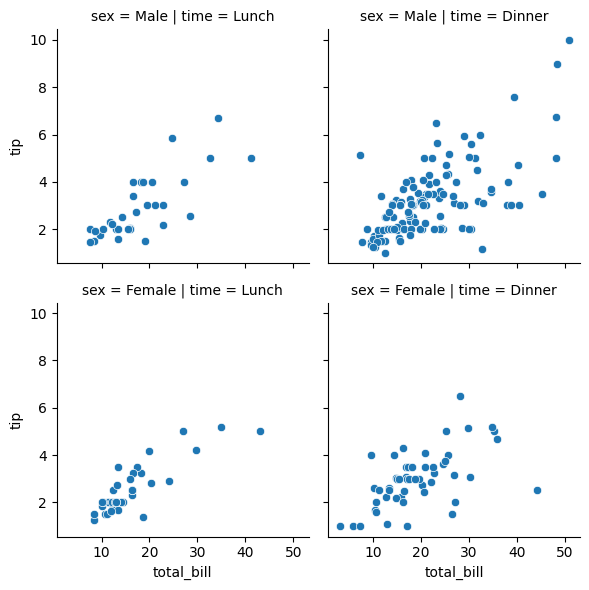

In [ ]:
# SEABORN
import seaborn as sns
import wandb

tips = sns.load_dataset("tips")

g = sns.FacetGrid(tips, col="time", row="sex")
g.map(sns.scatterplot, "total_bill", "tip")

In [ ]:
with wandb.init():
    wandb.log({"plot": g.figure})

# ARTIFACT